### **Итоговое задание Альмиры, Андрея Скороходова  и Соколова Александра**  
### по Проекту 5. Car Price prediction 
####  Юнит 6. Основные алгоритмы машинного обучения. Часть II (отредактирован 19.9.2020)
---

### 1. Импорт библиотек

In [69]:
import pandas as pd
# import pandas_profiling
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import re
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import ExtraTreeRegressor
from tqdm import tqdm
from itertools import combinations
from scipy.stats import ttest_ind
from catboost import CatBoostClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression

from importlib import reload

import os
print(os.listdir('./data'))
PATH_to_file = './data/'

['all_auto_ru_09_09_2020.csv', 'all_auto_ru_09_09_2020.zip', 'base_sub.csv', 'base_sub2.csv', 'df3.csv', 'df3_cols.csv', 'df3_v2.csv', 'df3_v2_cols.csv', 'df3_v3.csv', 'df3_v3_cols.csv', 'df9.csv', 'df9_cols.csv', 'sample_submission.csv', 'test.csv']


In [5]:
import utils_module09092020 as utils

In [6]:
RANDOM_SEED = 42
!pip freeze > requirements.txt
CURRENT_DATE = pd.to_datetime('19/09/2020')

### 2. Импорт данных

In [4]:
df_train = pd.read_csv(PATH_to_file+'all_auto_ru_09_09_2020.csv')
df_test = pd.read_csv(PATH_to_file+'test.csv')
df_submit = pd.read_csv(PATH_to_file+'sample_submission.csv')
pd.set_option('display.max_columns', None)
print('Размерность тренировочного датасета: ', df_train.shape)
display(df_train.head(2))
print('Размерность тестового датасета: ', df_test.shape)
display(df_test.head(2))
print('Размерность датасета c примером сабмишена: ', df_submit.shape)
display(df_submit.head(2))

Размерность тренировочного датасета:  (89378, 26)


bodyType brand   color fuelType  modelDate                   name  \
0    Седан  AUDI  040001   бензин     1990.0  2.8 MT (174 л.с.) 4WD   
1    Седан  AUDI  EE1D19   бензин     1982.0       1.8 MT (90 л.с.)   

   numberOfDoors  productionDate  vehicleConfiguration vehicleTransmission  \
0            4.0            1991  SEDAN MECHANICAL 2.8          MECHANICAL   
1            4.0            1986  SEDAN MECHANICAL 1.8          MECHANICAL   

  engineDisplacement  enginePower  \
0                2.8        174.0   
1                1.8         90.0   

                                         description  mileage Комплектация  \
0   Машина  в приличном состоянии ,не гнилая не р...   350000  {'id': '0'}   
1  Машина в оригинале не гнилая все вопросы по те...   173424  {'id': '0'}   

     Привод  Руль  Состояние  Владельцы       ПТС  Таможня Владение     price  \
0    полный  LEFT        NaN        3.0  ORIGINAL     True      NaN  200000.0   
1  передний  LEFT        NaN        3.0  ORIGINAL     True      NaN   60000.0   

             start_date  hidden model  
0  2019-10-03T08:09:11Z     NaN   100  
1  2020-09-06T06:49:40Z     NaN   100

Размерность тестового датасета:  (3837, 23)


bodyType brand   color fuelType  modelDate                     name  \
0    седан   BMW  чёрный   дизель     2016.0  520d 2.0d AT (190 л.с.)   
1    седан   BMW   белый   дизель     2018.0  318d 2.0d AT (150 л.с.)   

   numberOfDoors  productionDate vehicleConfiguration vehicleTransmission  \
0            4.0          2017.0  SEDAN AUTOMATIC 2.0      автоматическая   
1            4.0          2019.0  SEDAN AUTOMATIC 2.0      автоматическая   

  engineDisplacement enginePower  \
0            2.0 LTR     190 N12   
1            2.0 LTR     150 N12   

                                         description   mileage  \
0  В РОЛЬФ Ясенево представлено более 500 автомоб...  158836.0   
1  Автомобиль из демонстрационного парка по спец ...      10.0   

                                        Комплектация  Привод   Руль  \
0  ['[{"name":"Безопасность","values":["Антипробу...  задний  Левый   
1  ['[{"name":"Комфорт","values":["Круиз-контроль...  задний  Левый   

            Состояние   Владельцы       ПТС     Таможня Владение  id  
0  Не требует ремонта  1 владелец  Оригинал  Растаможен      NaN   0  
1  Не требует ремонта  1 владелец  Оригинал  Растаможен      NaN   1

Размерность датасета c примером сабмишена:  (3837, 2)


id      price
0   0  5299000.0
1   1  1580000.0

### 2. Проверка и доработка датасета после парсинга для слияния с тестом

In [5]:
# сравним датасеты 
utils.check_df_before_merg(df_train, df_test)

# уник_1                                  в первой строке_1    тип_1  \
0      168.0                                              Седан   object   
1       36.0                                               AUDI   object   
2       16.0                                             040001   object   
3        6.0                                             бензин   object   
4       78.0                                               1990  float64   
5     4484.0                              2.8 MT (174 л.с.) 4WD   object   
6        5.0                                                  4  float64   
7       80.0                                               1991    int64   
8     1860.0                               SEDAN MECHANICAL 2.8   object   
9        4.0                                         MECHANICAL   object   
10     534.0                                                2.8   object   
11     396.0                                                174  float64   
12   77568.0   Машина  в приличном состоянии ,не гнилая не р...   object   
13   17403.0                                             350000    int64   
14    5839.0                                        {'id': '0'}   object   
15       3.0                                             полный   object   
16       2.0                                               LEFT   object   
17       0.0                                                NaN  float64   
18       3.0                                                  3  float64   
19       2.0                                           ORIGINAL   object   
20       1.0                                               True     bool   
21     290.0                                                NaN   object   
22    8168.0                                             200000  float64   
23   75680.0                               2019-10-03T08:09:11Z   object   
24       0.0                                                NaN  float64   
25    1086.0                                                100   object   
26       NaN                                                NaN      NaN   

          имя признака_1        имя признака_2    тип_2  \
0               bodyType              bodyType   object   
1                  brand                 brand   object   
2                  color                 color   object   
3               fuelType              fuelType   object   
4              modelDate             modelDate  float64   
5                   name                  name   object   
6          numberOfDoors         numberOfDoors  float64   
7         productionDate        productionDate  float64   
8   vehicleConfiguration  vehicleConfiguration   object   
9    vehicleTransmission   vehicleTransmission   object   
10    engineDisplacement    engineDisplacement   object   
11           enginePower           enginePower   object   
12           description           description   object   
13               mileage               mileage  float64   
14          Комплектация          Комплектация   object   
15                Привод                Привод   object   
16                  Руль                  Руль   object   
17             Состояние             Состояние   object   
18             Владельцы             Владельцы   object   
19                   ПТС                   ПТС   object   
20               Таможня               Таможня   object   
21              Владение              Владение   object   
22                 price                   NaN      NaN   
23            start_date                   NaN      NaN   
24                hidden                   NaN      NaN   
25                 model                   NaN      NaN   
26                   NaN                    id    int64   

                                    в первой строке_2  # уник_2  
0                                               седан      11.0  
1                                                 BMW       1.0  
2                       

Резюме:
 1. Не совпали типы в:= 11 столбцах

2. Уникальные значения заоблачно различаются в:= 10 столбцах [0, 1, 4, 5, 7, 8, 10, 11, 12, 13]


имя признака_1 не совпадают типы  имя признака_2
index                                                  
7      productionDate    int64!=float64  productionDate
11        enginePower   float64!=object     enginePower
13            mileage    int64!=float64         mileage
17          Состояние   float64!=object       Состояние
18          Владельцы   float64!=object       Владельцы
20            Таможня      bool!=object         Таможня
22              price      float64!=nan             NaN
23         start_date       object!=nan             NaN
24             hidden      float64!=nan             NaN
25              model       object!=nan             NaN
26                NaN        nan!=int64              id

In [6]:
# починим датасет перед использованием и приведем его к виду теста

# на первый взгляд может, что перевод во float достаточно бесмыссленный шаг ведь кол-во дверей автомобиля это целое число. Но напомню что мы сейчас на этапе приведения датасета после парсинга к виду тестового. На этапе анализа датасета мы сможем более детально посмотреть что происходит в тестовом датасете (вероятно там есть ошибки которые надо исправить и мы можем потерять эту информацию не знаю сколько ошибок и какие они) 

# начнем с int64!=float64 и приведем все к float 
list_cols_to_repair = ['productionDate', 'mileage']
for col in list_cols_to_repair:
        df_train[col] = df_train[col].astype('float64')

# теперь починим int64!=float64 и приведем все к object
list_cols_to_repair = ['enginePower', 'Состояние', 'Владельцы']
for col in list_cols_to_repair:
        df_train[col] = df_train[col].astype('object')

# теперь починим bool!=object
# предварительно райдем в датасет и убедимся, что True соответсвует Растаможен зайдя на сайте (этот код тут не приводится, чтобы не нагружать ноутбук)
df_train['Таможня'] = df_train['Таможня'].map({True: 'Растаможен', False:'Не растаможен'})

In [7]:
utils.check_df_before_merg(df_train, df_test)

# уник_1                                  в первой строке_1    тип_1  \
0      168.0                                              Седан   object   
1       36.0                                               AUDI   object   
2       16.0                                             040001   object   
3        6.0                                             бензин   object   
4       78.0                                               1990  float64   
5     4484.0                              2.8 MT (174 л.с.) 4WD   object   
6        5.0                                                  4  float64   
7       80.0                                               1991  float64   
8     1860.0                               SEDAN MECHANICAL 2.8   object   
9        4.0                                         MECHANICAL   object   
10     534.0                                                2.8   object   
11     396.0                                                174   object   
12   77568.0   Машина  в приличном состоянии ,не гнилая не р...   object   
13   17403.0                                             350000  float64   
14    5839.0                                        {'id': '0'}   object   
15       3.0                                             полный   object   
16       2.0                                               LEFT   object   
17       0.0                                                NaN   object   
18       3.0                                                  3   object   
19       2.0                                           ORIGINAL   object   
20       1.0                                         Растаможен   object   
21     290.0                                                NaN   object   
22    8168.0                                             200000  float64   
23   75680.0                               2019-10-03T08:09:11Z   object   
24       0.0                                                NaN  float64   
25    1086.0                                                100   object   
26       NaN                                                NaN      NaN   

          имя признака_1        имя признака_2    тип_2  \
0               bodyType              bodyType   object   
1                  brand                 brand   object   
2                  color                 color   object   
3               fuelType              fuelType   object   
4              modelDate             modelDate  float64   
5                   name                  name   object   
6          numberOfDoors         numberOfDoors  float64   
7         productionDate        productionDate  float64   
8   vehicleConfiguration  vehicleConfiguration   object   
9    vehicleTransmission   vehicleTransmission   object   
10    engineDisplacement    engineDisplacement   object   
11           enginePower           enginePower   object   
12           description           description   object   
13               mileage               mileage  float64   
14          Комплектация          Комплектация   object   
15                Привод                Привод   object   
16                  Руль                  Руль   object   
17             Состояние             Состояние   object   
18             Владельцы             Владельцы   object   
19                   ПТС                   ПТС   object   
20               Таможня               Таможня   object   
21              Владение              Владение   object   
22                 price                   NaN      NaN   
23            start_date                   NaN      NaN   
24                hidden                   NaN      NaN   
25                 model                   NaN      NaN   
26                   NaN                    id    int64   

                                    в первой строке_2  # уник_2  
0                                               седан      11.0  
1                                                 BMW       1.0  
2                       

Резюме:
 1. Не совпали типы в:= 5 столбцах

2. Уникальные значения заоблачно различаются в:= 10 столбцах [0, 1, 4, 5, 7, 8, 10, 11, 12, 13]


имя признака_1 не совпадают типы имя признака_2
index                                                
22             price      float64!=nan            NaN
23        start_date       object!=nan            NaN
24            hidden      float64!=nan            NaN
25             model       object!=nan            NaN
26               NaN        nan!=int64             id

Резюме - несоответствие типов осталось в 5 столбцах \[price, start_date, hidden, model, id\], в том числе price - целевая переменная которую мы будем моделировать, три столбца чтобы попробовать обогатить данные, и столбцец id, который нам будет нужен для формирования файла submition.  
Теперь обратим внимание на значения и приведем их к общему виду 

In [8]:
# bodyType - надо привести значения к нижнему регистру (оставим закадром, проверку уникальных значений трейна и теста, чтобы прийти к такому выводу)
df_train['bodyType'] = df_train['bodyType'].apply(lambda x: str(x).lower())
utils.nunique_not_found(df_train, df_test, 'bodyType')


# color - цвета спарсились в шестнадцатеричном коде цветов. Но их всего 16 поэтому воспользуемся сайтом (https://hysy.org/color) и сделаем словарь цветов. (оставим закадром, проверку уникальных значений трейна и теста, чтобы сделать соответсвия цветов) 
dict_color = {'040001':'чёрный', 'EE1D19':'красный', '0000CC':'синий', 
              'CACECB':'серебристый', '007F00':'зелёный', 'FAFBFB':'белый', 
              '97948F':'серый', '22A0F8':'голубой', '660099':'пурпурный', 
              '200204':'коричневый', 'C49648':'бежевый', 'DEA522':'золотистый', 
              '4A2197':'фиолетовый', 'FFD600':'жёлтый', 'FF8649':'оранжевый', 
              'FFC0CB':'розовый'}
df_train['color'] = df_train['color'].map(dict_color)
utils.nunique_not_found(df_train, df_test, 'color')

# vehicleTransmission - тип трасмиссии по словарю из 4 значений
df_train['vehicleTransmission'] = df_train['vehicleTransmission'].map({'MECHANICAL':'механическая', 'AUTOMATIC':'автоматическая', 'ROBOT':'роботизированная', 'VARIATOR':'вариатор'})


# Руль - ну тут все просто - Правый или Левый в нижнем регистре с большой буквы
df_train['Руль'] = df_train['Руль'].map({'RIGHT':'Правый', 'LEFT':'Левый'})
utils.nunique_not_found(df_train, df_test, 'Руль')

# ПТС - тут все просто - Оригинал или Дубликат в нижнем регистре с большой буквы
df_train['ПТС'] = df_train['ПТС'].map({'ORIGINAL':'Оригинал', 'DUPLICATE':'Дубликат'})
utils.nunique_not_found(df_train, df_test, 'ПТС')

# Владельцы - Оригинал или Дубликат в нижнем регистре с большой буквы
df_train['Владельцы'] = df_train['Владельцы'].map({3.0:'3 или более', 2.0:'2\xa0владельца', 1.0:'1\xa0владелец'})
utils.nunique_not_found(df_train, df_test, 'Владельцы')

# Владение - в таблице сверху в первых строках Nan поэтому нужно отдельно проверить
# оказалось что в тесте очень сложная строковая запись тогда как в трейне в значениях более структурируемые словари (УчТЕМ этот момент и разберем этот столбец на этапе анализа, вероятно будет сразу полезно создать дополнительные временные фичи) 
utils.nunique_not_found(df_train, df_test, 'Владение');

в столбце:= bodyType в трейне НЕ НАЙДЕНО:= 0 уникальных значений из теста
в столбце:= color в трейне НЕ НАЙДЕНО:= 0 уникальных значений из теста
в столбце:= Руль в трейне НЕ НАЙДЕНО:= 0 уникальных значений из теста
в столбце:= ПТС в трейне НЕ НАЙДЕНО:= 0 уникальных значений из теста
в столбце:= Владельцы в трейне НЕ НАЙДЕНО:= 0 уникальных значений из теста
в столбце:= Владение в трейне НЕ НАЙДЕНО:= 157 уникальных значений из теста


Резюме - несоответсвие значений в одинаковых типах осталось только в одном столбце - Владение, но приведение к единому виду целеообразно оставить до детально анализа по переменным, так как там зашиты данные о годе и месяце владения и в процессе обработке может быть сразу целесообразно будет создавать новые временные фичи.  

### 3. Слияние датасетов в один

In [9]:
# ВАЖНО! для корректной обработки признаков объединяем трейн и тест в один датасет
df_train['Train'] = 1 # помечаем где у нас трейн
df_test['Train'] = 0 # помечаем где у нас тест

df = df_train.append(df_test, sort=False).reset_index(drop=True) # объединяем
#!Обратите внимание объединение датасетов является потенциальной опасностью для даталиков

In [10]:
# проверка  после слияния
df.head(2)

bodyType brand    color fuelType  modelDate                   name  \
0    седан  AUDI   чёрный   бензин     1990.0  2.8 MT (174 л.с.) 4WD   
1    седан  AUDI  красный   бензин     1982.0       1.8 MT (90 л.с.)   

   numberOfDoors  productionDate  vehicleConfiguration vehicleTransmission  \
0            4.0          1991.0  SEDAN MECHANICAL 2.8        механическая   
1            4.0          1986.0  SEDAN MECHANICAL 1.8        механическая   

  engineDisplacement enginePower  \
0                2.8         174   
1                1.8          90   

                                         description   mileage Комплектация  \
0   Машина  в приличном состоянии ,не гнилая не р...  350000.0  {'id': '0'}   
1  Машина в оригинале не гнилая все вопросы по те...  173424.0  {'id': '0'}   

     Привод   Руль Состояние    Владельцы       ПТС     Таможня Владение  \
0    полный  Левый       NaN  3 или более  Оригинал  Растаможен      NaN   
1  передний  Левый       NaN  3 или более  Оригинал  Растаможен      NaN   

      price            start_date  hidden model  Train  id  
0  200000.0  2019-10-03T08:09:11Z     NaN   100      1 NaN  
1   60000.0  2020-09-06T06:49:40Z     NaN   100      1 NaN

### 4. Предварительный анализ данных

In [ ]:
# Этот ноутбук - укороченная версия для отображения на гитхабе
# код ниже не запускался и не выполнялся так как сильно увеличивает размер ноутбука
# полная версия ноутбука доступна в этой же папке, 
# для просмотра вы можете сделать клон репы и просмотреть на локальном копьютере

# # анализ тренировочной части
# pandas_profiling.ProfileReport(df[df['Train']==1])

In [ ]:
# Этот ноутбук - укороченная версия для отображения на гитхабе
# код ниже не запускался и не выполнялся так как сильно увеличивает размер ноутбука
# полная версия ноутбука доступна в этой же папке, 
# для просмотра вы можете сделать клон репы и просмотреть на локальном копьютере

# # анализ валидационной части
# pandas_profiling.ProfileReport(df[df['Train']==0])

In [12]:
# выведем сводную информацию по датасету df без теста kaggle
utils.describe_without_plots_all_collumns(df[df['Train']==1], short=True)

имя признака      тип # значений # пропусков(NaN) # уникальных  \
0               bodyType   object      89378                0          168   
1                  brand   object      89378                0           36   
2                  color   object      89378                0           16   
3               fuelType   object      89378                0            6   
4              modelDate  float64      89377                1           78   
5                   name   object      89377                1         4484   
6          numberOfDoors  float64      89377                1            5   
7         productionDate  float64      89378                0           80   
8   vehicleConfiguration   object      89377                1         1860   
9    vehicleTransmission   object      89377                1            4   
10    engineDisplacement   object      89377                1          534   
11           enginePower   object      89377                1          396   
12           description   object      86124             3254        77568   
13               mileage  float64      89378                0        17403   
14          Комплектация   object      89378                0         5839   
15                Привод   object      89377                1            3   
16                  Руль   object      89378                0            2   
17             Состояние   object          0            89378            0   
18             Владельцы   object      75790            13588            3   
19                   ПТС   object      89017              361            2   
20               Таможня   object      89378                0            1   
21              Владение   object      29201            60177          290   
22                 price  float64      88968              410         8168   
23            start_date   object      89378                0        75680   
24                hidden  float64          0            89378            0   
25                 model   object      89378                0         1086   
26                 Train    int64      89378                0            1   
27                    id  float64          0            89378            0   

   минимум      среднее     макс медиана  
0      NaN          NaN      NaN     NaN  
1      NaN          NaN      NaN     NaN  
2      NaN          NaN      NaN     NaN  
3      NaN          NaN      NaN     NaN  
4     1904      2008.54     2020    2009  
5      NaN          NaN      NaN     NaN  
6        0      4.51047        5       5  
7     1904      2010.83     2020    2011  
8      NaN          NaN      NaN     NaN  
9      NaN          NaN      NaN     NaN  
10     NaN          NaN      NaN     NaN  
11     NaN          NaN      NaN     NaN  
12     NaN          NaN      NaN     NaN  
13       0       134829    1e+06  130000  
14     NaN          NaN      NaN     NaN  
15     NaN          NaN      NaN     NaN  
16     NaN          NaN      NaN     NaN  
17     NaN          NaN      NaN     NaN  
18     NaN          NaN      NaN     NaN  
19     NaN          NaN      NaN     NaN  
20     NaN          NaN      NaN     NaN  
21     NaN          NaN      NaN     NaN  
22   16000  1.29459e+06  9.9e+07  650000  
23     NaN          NaN      NaN     NaN  
24     NaN          NaN      NaN     NaN  
25     NaN          NaN      NaN     NaN  
26       1            1        1       1  
27     NaN          NaN      NaN     NaN

In [12]:
# выведем сводную информацию по тесту
utils.describe_without_plots_all_collumns(df[df['Train']==0], short=True)

имя признака      тип # значений # пропусков(NaN) # уникальных  \
0               bodyType   object       3837                0           11   
1                  brand   object       3837                0            1   
2                  color   object       3837                0           15   
3               fuelType   object       3837                0            4   
4              modelDate  float64       3837                0           31   
5                   name   object       3837                0          384   
6          numberOfDoors  float64       3837                0            4   
7         productionDate  float64       3837                0           37   
8   vehicleConfiguration   object       3837                0           99   
9    vehicleTransmission   object       3837                0            3   
10    engineDisplacement   object       3837                0           22   
11           enginePower   object       3837                0           75   
12           description   object       3837                0         3677   
13               mileage  float64       3837                0         1942   
14          Комплектация   object       3837                0         3295   
15                Привод   object       3837                0            3   
16                  Руль   object       3837                0            1   
17             Состояние   object       3837                0            1   
18             Владельцы   object       3837                0            3   
19                   ПТС   object       3837                0            2   
20               Таможня   object       3837                0            1   
21              Владение   object       1753             2084          157   
22                 price  float64          0             3837            0   
23            start_date   object          0             3837            0   
24                hidden  float64          0             3837            0   
25                 model   object          0             3837            0   
26                 Train    int64       3837                0            1   
27                    id  float64       3837                0         3837   

   минимум  среднее   макс медиана  
0      NaN      NaN    NaN     NaN  
1      NaN      NaN    NaN     NaN  
2      NaN      NaN    NaN     NaN  
3      NaN      NaN    NaN     NaN  
4     1975  2009.95   2019    2011  
5      NaN      NaN    NaN     NaN  
6        2  4.37503      5       5  
7     1981  2011.93   2019    2013  
8      NaN      NaN    NaN     NaN  
9      NaN      NaN    NaN     NaN  
10     NaN      NaN    NaN     NaN  
11     NaN      NaN    NaN     NaN  
12     NaN      NaN    NaN     NaN  
13       1   118536  1e+06  108000  
14     NaN      NaN    NaN     NaN  
15     NaN      NaN    NaN     NaN  
16     NaN      NaN    NaN     NaN  
17     NaN      NaN    NaN     NaN  
18     NaN      NaN    NaN     NaN  
19     NaN      NaN    NaN     NaN  
20     NaN      NaN    NaN     NaN  
21     NaN      NaN    NaN     NaN  
22     NaN      NaN    NaN     NaN  
23     NaN      NaN    NaN     NaN  
24     NaN      NaN    NaN     NaN  
25     NaN      NaN    NaN     NaN  
26       0        0      0       0  
27       0     1918   3836    1918

Резюме по предварительному анализу: (выводы идут по порядку выявления, а не по значимости)  
В тренировочной выборке 88968 строк, в тестовой 3837. Всего данных - 93215 строк. Всего 28 признаков, из них:
- 23 в тесте: 
  - 4 - числовых - mileage, modelDate, productionDate (один из них id - сервисный для генерации submition), 
  - 19 - категориальных (пока так, во время анализа, вероятно, какие-нибудь из них станут числовыми, например можность двигателя)
- 4 были добавлены во время парсинга: 1- числовой - price, 1 - временной ряд - start_date, 1 - бинарный - hidden, 1 - категориальный - model
- 1 - бинарный Train  - сервисный для разделения train и test
  
Детальная информация по трейну и тесту раздельно:  
- признак Таможня бесполезен так как содержит одно значение - Растаможен => удалим
- в трейне 2114 (2.4%) дубликатов по строкам => надо удалить
- высокая корреляция между modelDate и productionDate => надо еще внимательно посмотреть на этапе анализа перед тем как удалить
- пропуски в трейне:
  - description - 3254 (3.6%) => надо заполнить
  - Состояние - 89378 (100.0%) - мы не смогли во время парсинга раздобыть этот критерий => надо проанализировать заполненность этого признака в тесте и постараться заполнить по похожим критериям авто требующих ремонта - так как это влияет на цену 
  - Владельцы - 13588 (15.2%) => надо заполнить 
  - Владение - 60177 (67.3%) => очень много пропусков надо попробовать заполнить
  - hidden - 89378 (100.0%) => надо удалить
  - id - 89378 (100.0%) - это столбец для генерации файла submition => ничего не делаем
- пропуски в тесте:
  - Владение - 2084 (54.3%) => надо заполнить
  - price, start_date, hidden, model - 3837 (100.0%) - дополнительные фичи => надо проанализировать и использовать для генерации новых фич или удалить
- между vehicleConfiguration и еще тремя признаками: vehicleTransmission, engineDisplacement, numberOfDoors - высокая корреляция => надо проверить это при анализе и при необходимости удалить
- в тесте:
  - brand - только одно значение - "BMW" => надо дополнительно собрать информацию с обзоров цен на BMW и постараться оставить для анализа автомобили со схожими характеристиками, которые влюяют на цену
  - Руль - только одно значение - "Левый" => надо взять из трейна только авто с Левым рулем
  - Состояние - только одно значение - "Не требует ремонта" => надо обратить внимание на выбросы снизу по цене из трейна, чтобы не брать в учет авто требующие ремонта

Описания полей датасета
- bodyType - тип кузова автомобиля (https://ru.wikipedia.org/wiki/Типы_автомобильных_кузовов)
- brand - марка (бренд) автомобиля
- color	- цвет автомобиля (16 цветов: чёрный, красный, синий, серебристый, зелёный, белый, серый, голубой, пурпурный, коричневый, золотистый, фиолетовый, жёлтый, оранжевый, розовый)
- fuelType - тип топлива (5 видов топлива: бензин, дизель, электро, гибрид, газ)
- modelDate - дата выпуска модели (не путать с датой производства)
- name - комбинация нескольких характеристик (модели, объема двигателя и привода)
- numberOfDoors - кол-во дверей
- productionDate - дата производства авто
- vehicleConfiguration - комбинация типа трансмиссии, объема двигателя и мощности двигателя
- vehicleTransmission - тип трансмиссии (коробки передач) (4 вида: автоматическая, механическая, роботизированная, вариатор)
- engineDisplacement - объем двигателя в литрах
- enginePower - мощность двигателя (л.с.)
- description - дополнительные характеристики по комплектации авто
- mileage - пробег автомобиля (км.) - представляет собой общее количество километров, которое это транспортное средство проехало по дорогам с момента своего схода с конвейера производителя. 
- Комплектация - дополнительные характеристики по комплектации авто
- Привод - характеристика привода автомобиля, которое передает энергию от двигателя на колеса. Переднеприводные автомобили получают всю энергию двигателя на передние колеса. При заднем приводе энергия двигателя целиком поступает на задние колеса. Когда энергия двигателя передается на все четыре колеса автомобиля, такой привод является полным ('полный', 'передний', 'задний')
- Руль - характеристика руля по стороне расположения руля в автомобиле (Левый, Правый)
- Состояние - характеристика (необходимости проведения ремонта - требует ремонта или не требует ремонта)
- Владельцы - кол-во владельцев (3 значения: 1 владелец, 2 владельца, 3 и более)
- ПТС - тип ПТС (паспорт технического средства)(2 значения - оригинал, дубликат)
- Таможня - информация о том расстаможен автомобиль или нет (2 значения - Растаможен, Не ратаможен)
- Владение - срок владения автомобилем в годах и месяцах
- price - цена указанная в объявлении на авто.ру
- start_date - дата размещения объявления на авто.ру
- hidden - характеристика объявления на авто.ру
- model - название модели автомобиля (не путать с маркой (брендом), например: бренд или марка - BMW, модель - M6)
- Train - сервисный для разделения train и test
- id - - сервисный для генерации submition

In [11]:
# внесем данные по типам переменных из резюме в списки 
# временной ряд (1)
time_cols = ['start_date']
# бинарная переменная (0) (hidden - не включаем так как решили удалить) итого  (0+1=1)
bin_cols = []
# категориальные переменные (19), ('Таможня' - не включаем  так как решили удалить) (19+1=20)
cat_cols = ['bodyType', 'brand', 'color', 'fuelType', 'name',
       'numberOfDoors', 'vehicleConfiguration',
       'vehicleTransmission', 'engineDisplacement', 'enginePower',
       'description', 'Комплектация', 'Привод', 'Руль', 'Состояние',
       'Владельцы', 'ПТС', 'Владение', 'model']
# числовые переменные (3) 
num_cols = ['mileage', 'modelDate', 'productionDate']
# сервисные переменные (2)
servis_cols = ['Train', 'id']
# целевая переменная (1)
target_col = ['price']
# итого 1+1+20+3+2+1=28

all_cols =cat_cols+num_cols+time_cols+servis_cols+bin_cols+ target_col
print(f'Кол-во столбцов, для дальнейшей работы после предварительного анализа:= {len(all_cols)}')

Кол-во столбцов, для дальнейшей работы после предварительного анализа:= 26


In [12]:
# реализуем выводы из резюме перед детальным анализом по переменным
# берем только левый руль и тольк 26 столбцов
df = df.loc[df['Руль'] == 'Левый', all_cols]
# исключаем Руль из списка признаков для анализа итого остается 25 признаков из которых 2 сервисных (нужно проанализировать 23=25-2)
cat_cols.remove('Руль')
# удаляем дубликаты
df = df.drop_duplicates()
old_len_train = len(df[df['Train']==1])
print('Кол-во строк в трейне:= ', old_len_train)

Кол-во строк в трейне:=  85481


### 5. Сбор дополнительной информации о BMW
---
Какие то важные факты для дальнейшего анализа с дополнениями и выводами:
- статистика по ценам обычно приводится по моделям, а в тесте признака модель нет => надо попробовать его восстановить
- существует общепринятое деление по классам - \[малый средний класс, средний класс, бизнес класс, представительский класс, внедорожники, купе, кабриолеты и родстеры\] => надо проверить возможно такая группировка позволит найти какие-то закономерности внутри классов
- обычно эта марка не включается в какие-то программы поддержки продаж для диллеров (типа сниженный процент от государства и т.п.)
- в России автомобили BMW собираются в Калининграде («Автотор») (3 серия, 5 серия, 7 серия, X3, X5, X1, X6) => соотвественно нет необходимости расстамаживать эти марки автомобилей
- увеличенный на 22 мм клиренс, более жёсткие амортизаторы и усиленные стабилизаторы, адаптированная под морозы электроника, сборка менее чувствительна к качеству бензина - это основные отличия русской сборки => вероятно диллеры учитывают ньансы для продажи авто в России, надо обратить внимание что входит в комплектацию, возможно есть вещи, которые существенно увеличивают стоимость
- ранее 3-4 летние авто сильно теряли в цене, теперь этот порог сдвинулся до 5-6 лет => вероятно это из-за расширения сроков гарантии на авто, когда подходят гарантия или пониженный по стоимости и более долгий техосмотр, владельцы продают автомобили
- на рынке этой марки в отличии от других присутсвует некоторая философия БМВ - в новом авто предположительно очень большая доля так называемых транзакционных издержек (оверхедов) + стоимость бренда, которые после покупки авто первым владельцем "сильно" снижаются, дальше для рынка остается себестоимость машины. Эта себестоимость торгуется на рынке, но BMW находит своих приверженцев, которые также платят чуть дороже, но за BMW, за свой стиль жизни, комфорт, за свою философию BMW => надо проверить действительно ли это так, сделать несколько срезов по маркам и моделям и оставить для анализа либо только БМВ либо авто, которые попадают в конкурентные с БМВ ниши.  

Использованы материалы с ресурсов:
- https://auto.ru/stats/cars/bmw/
- https://ru.wikipedia.org/wiki/BMW
- https://zen.yandex.ru/media/id/5987885f1410c361e4ba0f9c/bmv-nemeckoi-sborki-v-chem-otlichie-ot-kaliningradskih-mashin-5d4da573ec575b00ad872a7a
- https://zen.yandex.ru/media/pitstop/chto-oznachaiut-bukvy-i-cifry-v-nazvaniiah-bmw-5b16229497b07500a945be0a  
и другие

### 6. Детальный анализ по переменным
---
### 6.1 bodyType 
начнем с типа кузова bodyType, чтобы убедиться в том что значения по всем маркам и моделям примерно одинаковые или наоборот и тогда убрать нерелевантные типы кузова

In [13]:
# так как признаков много создаем список проанализированных признаков, чтобы можно было посмотреть, что осталось сделать  
EDA_done_cols=[]

In [14]:
temp_df_Train = df[df['Train']==1]
temp_df_Test = df[df['Train']==0]
print(f'Всего в тесте типов кузова:= {temp_df_Test.bodyType.nunique()}')
print(f'Всего в трейне типов кузова:= {temp_df_Train.bodyType.nunique()}')

Всего в тесте типов кузова:= 11
Всего в трейне типов кузова:= 144


In [15]:
# посмотрим на них 
print(f'Список 11 типов кузова БМВ из теста:= {temp_df_Test.bodyType.unique()}')
print(f'Список первых 20 из 144 типов кузова из трейна:= {temp_df_Train.bodyType.unique()[:20]}')

Список 11 типов кузова БМВ из теста:= ['седан' 'внедорожник 5 дв.' 'хэтчбек 3 дв.' 'хэтчбек 5 дв.' 'купе'
 'родстер' 'лифтбек' 'универсал 5 дв.' 'кабриолет' 'седан 2 дв.'
 'компактвэн']
Список первых 20 из 144 типов кузова из трейна:= ['седан' 'универсал 5 дв.' 'хэтчбек 5 дв. sportback' 'хэтчбек 3 дв.'
 'хэтчбек 5 дв.' 'кабриолет' 'купе' 'лифтбек sportback' 'лифтбек'
 'седан long' 'внедорожник 5 дв.' 'кабриолет roadster' 'седан 2 дв.'
 'седан gran coupe' 'компактвэн' 'компактвэн gran tourer'
 'лифтбек gran turismo' 'хэтчбек 3 дв. compact' 'лифтбек gran coupe'
 'купе-хардтоп']


In [16]:
# оставляем только типы кузова как в тесте
list_bodyType_test = list(temp_df_Test.bodyType.unique())
df = df[df['bodyType'].isin(list_bodyType_test)]

***Резюме по bodyType:-*** Категориальный признак, оставили 11 типов кузовов, так как типы кузовов отличающиеся от кузовов в тесте очень специфичны и очень сильно влияют на класс автомобиля по которому по общим закономерностям формируется цена, оставим только типы кузова из теста, а потом после EDA проверим достаточно ли большая выборка трейна остается для моделирования или необходимо парсить другие сайты. Пропусков нет.

In [17]:
old_len_train, EDA_done_cols = utils.result_EDA_feature('bodyType', df[df['Train']==1], df[df['Train']==0], 23, EDA_done_cols, old_len_train)

В результате после EDA признака:= bodyType, обработано признаков:= 1, осталось:= 22
Кол-во строк в трейне:=  79193 . Убрали на данном шаге:=  6288
Кол-во строк в тесте:=  3837


### 6.2 enginePower
забежим вперед и обработаем мощность двигателя потому что она нам потребуется для анализа марок

In [18]:
# вспомним что по результатам предварительного анализа эта переменная была отнесена к категориальнымu, посмотрим почему
temp_df_Train = df[df['Train']==1]
temp_df_Test = df[df['Train']==0]
display(temp_df_Train.enginePower[:5])
display(temp_df_Test.enginePower[:5])

0    174
1     90
2    136
3     90
4    101
Name: enginePower, dtype: object

89378    190 N12
89379    150 N12
89380    407 N12
89381    249 N12
89382    381 N12
Name: enginePower, dtype: object

In [19]:
# проверим все значения теста по мощности 
temp_df_Test.enginePower.unique()

array(['190 N12', '150 N12', '407 N12', '249 N12', '381 N12', '245 N12',
       '177 N12', '184 N12', '115 N12', '231 N12', '156 N12', '306 N12',
       '218 N12', '136 N12', '235 N12', '286 N12', '122 N12', '265 N12',
       '258 N12', '340 N12', '355 N12', '170 N12', '333 N12', '192 N12',
       '610 N12', '264 N12', '555 N12', '313 N12', '272 N12', '450 N12',
       '445 N12', '400 N12', '320 N12', '530 N12', '204 N12', '269 N12',
       '560 N12', '143 N12', '431 N12', '575 N12', '193 N12', '140 N12',
       '420 N12', '163 N12', '105 N12', '326 N12', '625 N12', '300 N12',
       '329 N12', '367 N12', '460 N12', '197 N12', '360 N12', '113 N12',
       '100 N12', '370 N12', '374 N12', '462 N12', '188 N12', '544 N12',
       '129 N12', '102 N12', '600 N12', '118 N12', '125 N12', '507 N12',
       '609 N12', '252 N12', '410 N12', '347 N12', '449 N12', '243 N12',
       '230 N12', '211 N12', '90 N12'], dtype=object)

In [20]:
# в тесте вытащим значение мощности перед строкой ' N12'
df.loc[df['Train']==0, 'enginePower'] = df[df['Train']==0]['enginePower'].apply(lambda x: int(x.split()[0]))

In [21]:
# переводим в int64
df['enginePower'] = df['enginePower'].astype('int64')

# перенесем признак в числовые
cat_cols.remove('enginePower')
num_cols.append('enginePower')

In [22]:
utils.describe_without_plots('enginePower', df[df['Train']==1].enginePower)

enginePower
кол-во строк          79193
тип значений          int64
кол-во значений       79193
кол-во NaN                0
среднее             169.323
медиана                 150
мин                      11
макс                    800

In [23]:
# очень странное минимальное значение можности, давайте посмотрим минимум мощности на тесте 
utils.describe_without_plots('enginePower', df[df['Train']==0].enginePower)

enginePower
кол-во строк           3837
тип значений          int64
кол-во значений        3837
кол-во NaN                0
среднее             242.546
медиана                 231
мин                      90
макс                    625

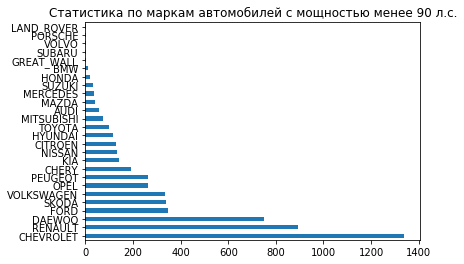

In [24]:
df[(df['Train']==1) & (df['enginePower']<90)]['brand'].value_counts().plot(kind = 'barh', title='Cтатистика по маркам автомобилей с мощностью менее 90 л.с.')

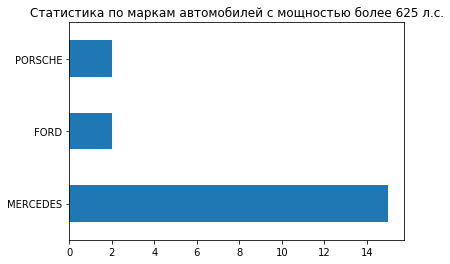

In [25]:
df[(df['Train']==1) & (df['enginePower']>625)]['brand'].value_counts().plot(kind = 'barh', title='Cтатистика по маркам автомобилей с мощностью более 625 л.с.')

In [26]:
# удалим значения мощностей меньше 90 и выше 625
df=df[(df['enginePower']<=625) & (df['enginePower']>=90)]

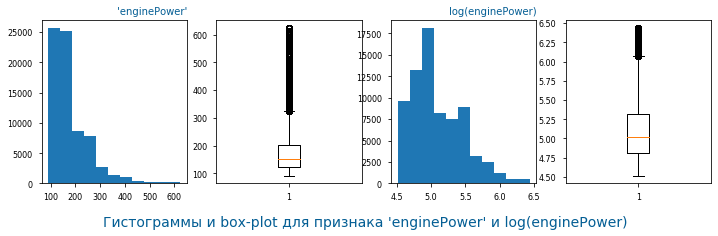

In [27]:
utils.four_plot_with_log2('enginePower', df[df['Train']==1])

***Резюме по enginePower:-*** обработали строки и перевели мощность в int64. Пропусков нет. Было какое-то небольшое значение мощности в трейне равное 11. Через это вышли на сравнение мощности с тестом и обрезали трейн по мощности двигателя то теста (более 90 и менее 625). О характере распределения и выбросах говорить пока рано, так как предстоит фильтрация по бренду, целесообразно вернуться к более детальному анализу после того как датасет устаканится. 

In [28]:
# записываем признак в список проанализированных признаков
old_len_train, EDA_done_cols = utils.result_EDA_feature('enginePower', df[df['Train']==1], df[df['Train']==0], 23, EDA_done_cols, old_len_train)

В результате после EDA признака:= enginePower, обработано признаков:= 2, осталось:= 21
Кол-во строк в трейне:=  73548 . Убрали на данном шаге:=  5645
Кол-во строк в тесте:=  3837


### 6.3 brand
теперь посмотрим на марки - brand

In [29]:
print(f'Всего в датасета марок:= {df.brand.nunique()}')

Всего в датасета марок:= 36


Вероятно не все из них нам подходят, сделаем сводные таблицы и посмотрим на средние значения цен по автомобилям по годам

In [ ]:
# Этот ноутбук - укороченная версия для отображения на гитхабе
# код ниже не запускался и не выполнялся так как сильно увеличивает размер ноутбука
# полная версия ноутбука доступна в этой же папке, 
# для просмотра вы можете сделать клон репы и просмотреть на локальном копьютере

# list_brand0 = utils.hbar_group_pivot_table(list_bodyType_test[0], 'price', df[df['Train']==1], 2013, 2020, 1.1)

In [ ]:
# Этот ноутбук - укороченная версия для отображения на гитхабе
# код ниже не запускался и не выполнялся так как сильно увеличивает размер ноутбука
# полная версия ноутбука доступна в этой же папке, 
# для просмотра вы можете сделать клон репы и просмотреть на локальном копьютере

# list_brand1 = utils.hbar_group_pivot_table(list_bodyType_test[1], 'price', df[df['Train']==1], 2015, 2019, 1.1)

In [ ]:
# Этот ноутбук - укороченная версия для отображения на гитхабе
# код ниже не запускался и не выполнялся так как сильно увеличивает размер ноутбука
# полная версия ноутбука доступна в этой же папке, 
# для просмотра вы можете сделать клон репы и просмотреть на локальном копьютере

# list_brand2 = utils.hbar_group_pivot_table(list_bodyType_test[2], 'price', df[df['Train']==1], 2000, 2010, 1.1)

In [ ]:
# Этот ноутбук - укороченная версия для отображения на гитхабе
# код ниже не запускался и не выполнялся так как сильно увеличивает размер ноутбука
# полная версия ноутбука доступна в этой же папке, 
# для просмотра вы можете сделать клон репы и просмотреть на локальном копьютере

# list_brand3 = utils.hbar_group_pivot_table(list_bodyType_test[3], 'price', df[df['Train']==1], 2015, 2019, 1.1)

In [ ]:
# Этот ноутбук - укороченная версия для отображения на гитхабе
# код ниже не запускался и не выполнялся так как сильно увеличивает размер ноутбука
# полная версия ноутбука доступна в этой же папке, 
# для просмотра вы можете сделать клон репы и просмотреть на локальном копьютере

# list_brand4 = utils.hbar_group_pivot_table(list_bodyType_test[4], 'price', df[df['Train']==1], 2015, 2019, 1.1)

In [ ]:
# Этот ноутбук - укороченная версия для отображения на гитхабе
# код ниже не запускался и не выполнялся так как сильно увеличивает размер ноутбука
# полная версия ноутбука доступна в этой же папке, 
# для просмотра вы можете сделать клон репы и просмотреть на локальном копьютере

# list_brand5 = utils.hbar_group_pivot_table(list_bodyType_test[5], 'price', df[df['Train']==1], 1990, 2010, 1.1)

In [ ]:
# Этот ноутбук - укороченная версия для отображения на гитхабе
# код ниже не запускался и не выполнялся так как сильно увеличивает размер ноутбука
# полная версия ноутбука доступна в этой же папке, 
# для просмотра вы можете сделать клон репы и просмотреть на локальном копьютере

# list_brand7 = utils.hbar_group_pivot_table(list_bodyType_test[7], 'price', df[df['Train']==1], 2000, 2005, 1.1)

In [ ]:
# Этот ноутбук - укороченная версия для отображения на гитхабе
# код ниже не запускался и не выполнялся так как сильно увеличивает размер ноутбука
# полная версия ноутбука доступна в этой же папке, 
# для просмотра вы можете сделать клон репы и просмотреть на локальном копьютере

# list_brand8 = utils.hbar_group_pivot_table(list_bodyType_test[8], 'price', df[df['Train']==1], 2000, 2010, 1.1)

In [ ]:
# Этот ноутбук - укороченная версия для отображения на гитхабе
# код ниже не запускался и не выполнялся так как сильно увеличивает размер ноутбука
# полная версия ноутбука доступна в этой же папке, 
# для просмотра вы можете сделать клон репы и просмотреть на локальном копьютере

# list_brand10 = utils.hbar_group_pivot_table(list_bodyType_test[10], 'price', df[df['Train']==1], 2015, 2019, 1.1)

In [39]:
# список всех релевантных моделей
list_final_brand=list(set(list_brand0+list_brand1+list_brand2+list_brand3+list_brand4+list_brand5+list_brand7+list_brand8+list_brand10))
print('Список релевантных брендов авто:\n',*list_final_brand, '\n, их кол-во:=', len(list_final_brand), 'из 36')
print()

Список релевантных брендов авто:
 SUBARU HONDA MAZDA RENAULT CHRYSLER JAGUAR LAND_ROVER INFINITI VOLVO MINI VOLKSWAGEN SUZUKI FORD PORSCHE MERCEDES CADILLAC NISSAN LEXUS TOYOTA AUDI JEEP 
, их кол-во:= 21 из 36



In [40]:
# кроме этого в трейне нет некоторых авто БМВ с типом кузова
print('В трейне не оказалось авто БМВ с типом кузова:=', list_bodyType_test[6])
temp_df_Train = df[df['Train']==1]
temp=list(temp_df_Train[temp_df_Train['bodyType']==list_bodyType_test[6]].brand.unique())
print('Список брендов авто с типом кузова', list_bodyType_test[6], ':=', *temp)

В трейне не оказалось авто БМВ с типом кузова:= лифтбек
Список брендов авто с типом кузова лифтбек := AUDI CHERY CITROEN FORD KIA MAZDA OPEL RENAULT SKODA TOYOTA VOLKSWAGEN MERCEDES


Резюме: Авто с типом кузова лифтбек содержат марки авто которые мы собираемся оставить так что все ок, не нужно ничего добавлять к списку сверху

In [41]:
# кроме этого в трейне нет некоторых авто БМВ с типом кузова
print('В трейне не оказалось авто БМВ с типом кузова:=', list_bodyType_test[9])
temp_df_Train = df[df['Train']==1]
temp=list(temp_df_Train[temp_df_Train['bodyType']==list_bodyType_test[9]].brand.unique())
print('Список брендов авто с типом кузова', list_bodyType_test[9], ':=', *temp)

В трейне не оказалось авто БМВ с типом кузова:= седан 2 дв.
Список брендов авто с типом кузова седан 2 дв. := BMW


In [42]:
temp_df_Train[temp_df_Train['bodyType']==list_bodyType_test[9]]

bodyType brand      color fuelType                  name  \
4084  седан 2 дв.   BMW  оранжевый   бензин     2.0 MT (101 л.с.)   
4902  седан 2 дв.   BMW     чёрный   бензин  318 1.8 MT (98 л.с.)   

      numberOfDoors          vehicleConfiguration vehicleTransmission  \
4084            2.0  SEDAN_2_DOORS MECHANICAL 2.0        механическая   
4902            2.0  SEDAN_2_DOORS MECHANICAL 318        механическая   

     engineDisplacement  enginePower  \
4084                2.0          101   
4902                318           98   

                                            description Комплектация  Привод  \
4084  В СССР прибыл новым. В семье с 1977 г. Один вл...  {'id': '0'}  задний   
4902  Автомобиль на ходу, брался под проект, стоит в...  {'id': '0'}  задний   

       Руль Состояние    Владельцы       ПТС                     Владение  \
4084  Левый       NaN   1 владелец  Оригинал  {'year': 1977, 'month': 12}   
4902  Левый       NaN  3 или более  Дубликат   {'year': 2020, 'month': 6}   

     model   mileage  modelDate  productionDate            start_date  Train  \
4084    02  117000.0     1966.0          1972.0  2019-05-25T20:43:16Z      1   
4902   3ER  500000.0     1975.0          1978.0  2020-08-02T14:29:15Z      1   

      id      price  
4084 NaN  1000000.0  
4902 NaN   160000.0

У нас всего два таких авто БМВ с таким типов кузова, можно заметить по году выпуска, что это раритетные автомобили, поэтому им не с кем было сравнится по цене

In [43]:
# оставляем 22 релевантных (21+BMW) бренд авто, остальные удаляем
df = df[df['brand'].isin(list_final_brand+['BMW'])]

***Резюме по brand*** - Проведен анализ средних и стандартных отклонений по ценам BMW по всем 11 типам кузова которые являются основным индикатором класса автомобиля. По результатам анализа выявлены 21 релевантные для моделирования цены бренды: AUDI CHERY CITROEN FORD KIA MAZDA OPEL RENAULT SKODA TOYOTA VOLKSWAGEN MERCEDES. Датасет урезан до этих брендов - осталось 22 вместе с BMW. Пропусков нет. 

In [44]:
# записываем признак в список проанализированных признаков
old_len_train, EDA_done_cols = utils.result_EDA_feature('brand', df[df['Train']==1], df[df['Train']==0], 23, EDA_done_cols, old_len_train)

В результате после EDA признака:= brand, обработано признаков:= 3, осталось:= 20
Кол-во строк в трейне:=  48715 . Убрали на данном шаге:=  24833
Кол-во строк в тесте:=  3837


### 6.4 fuelType

In [45]:
# вспомним что по результатам предварительного анализа в этой переменной было 6 уникальных значений в трейне и 4 в тесте
temp_df_Train = df[df['Train']==1]
temp_df_Test = df[df['Train']==0]
print(f'Список зачений по fuelType в трейне:= {list(temp_df_Train.fuelType.unique())}')
print(f'Список зачений по fuelType в тесте:= {list(temp_df_Test.fuelType.unique())}')

Список зачений по fuelType в трейне:= ['бензин', 'дизель', 'электро', 'гибрид', 'газ']
Список зачений по fuelType в тесте:= ['дизель', 'бензин', 'гибрид', 'электро']


In [46]:
# уберем газ так как автомобилей на газе нет в тесте
list_fuelType_test = temp_df_Test.fuelType.unique()
df = df[df['fuelType'].isin(list_fuelType_test)]

In [47]:
# Посмотрим сколько элекромобилей в тесте
print('Распределение по кол-ву зачений по fuelType в трейне:= \n',temp_df_Train.fuelType.value_counts())
print('Распределение по кол-ву зачений по fuelType в тесте:= \n',temp_df_Test.fuelType.value_counts())

Распределение по кол-ву зачений по fuelType в трейне:= 
 бензин     39906
дизель      8571
гибрид       160
электро       68
газ           10
Name: fuelType, dtype: int64
Распределение по кол-ву зачений по fuelType в тесте:= 
 бензин     2471
дизель     1358
гибрид        7
электро       1
Name: fuelType, dtype: int64


In [48]:
# посмотрим на автомобили БМВ в трейне и в тесте
temp_df = temp_df_Train[(temp_df_Train['fuelType']=='электро')&(temp_df_Train['brand']=='BMW')]
print(f'Кол-во электрокаров BMW в трейне:= {len(temp_df)}')
display(temp_df)

display(temp_df_Test[(temp_df_Test['fuelType']=='электро')&(temp_df_Test['brand']=='BMW')])

Кол-во электрокаров BMW в трейне:= 7


bodyType brand        color fuelType                       name  \
8256  хэтчбек 5 дв.   BMW  серебристый  электро       Electro AT (126 кВт)   
8257  хэтчбек 5 дв.   BMW        белый  электро       Electro AT (126 кВт)   
8261  хэтчбек 5 дв.   BMW        белый  электро  94Ah Electro AT (126 кВт)   
8263  хэтчбек 5 дв.   BMW        серый  электро       Electro AT (126 кВт)   
8266  хэтчбек 5 дв.   BMW        серый  электро  94Ah Electro AT (126 кВт)   
8267  хэтчбек 5 дв.   BMW       чёрный  электро       Electro AT (126 кВт)   
8269  хэтчбек 5 дв.   BMW       чёрный  электро       Electro AT (126 кВт)   

      numberOfDoors                 vehicleConfiguration vehicleTransmission  \
8256            5.0  HATCHBACK_5_DOORS AUTOMATIC Electro      автоматическая   
8257            5.0  HATCHBACK_5_DOORS AUTOMATIC Electro      автоматическая   
8261            5.0     HATCHBACK_5_DOORS AUTOMATIC 94Ah      автоматическая   
8263            5.0  HATCHBACK_5_DOORS AUTOMATIC Electro      автоматическая   
8266            5.0     HATCHBACK_5_DOORS AUTOMATIC 94Ah      автоматическая   
8267            5.0  HATCHBACK_5_DOORS AUTOMATIC Electro      автоматическая   
8269            5.0  HATCHBACK_5_DOORS AUTOMATIC Electro      автоматическая   

     engineDisplacement  enginePower  \
8256            Electro          170   
8257            Electro          170   
8261               94Ah          170   
8263            Electro          170   
8266               94Ah          170   
8267            Electro          170   
8269            Electro          170   

                                            description  \
8256  Производство 12 месяц 2014 года. В наличии! Ав...   
8257  Автомобиль в наличии Москве , с ПТС , производ...   
8261  Автомобиль в наличии с ПТС , ГЛОНАС и ТД!!! Мо...   
8263  Авто в наличии в Московской области с июня 202...   
8266  Состояние нового автомобиля . \nФото ИМЕННО ЭТ...   
8267  Автомобиль BMW i3 (полностью электрический )за...   
8269  BMW i3 Электромобиль с бензиновым генератором,...   

                                           Комплектация  Привод   Руль  \
8256                                        {'id': '0'}  задний  Левый   
8257  {'id': '21624597', 'name': 'i3 120 Ah', 'avail...  задний  Левый   
8261                                        {'id': '0'}  задний  Левый   
8263                                        {'id': '0'}  задний  Левый   
8266                                        {'id': '0'}  задний  Левый   
8267                                        {'id': '0'}  задний  Левый   
8269                                        {'id': '0'}  задний  Левый   

     Состояние   Владельцы       ПТС                    Владение model  \
8256       NaN  1 владелец  Оригинал                         NaN    I3   
8257       NaN  1 владелец  Оригинал                         NaN    I3   
8261       NaN  1 владелец  Оригинал  {'year': 2020, 'month': 2}    I3   
8263       NaN  1 владелец  Оригинал  {'year': 2020, 'month': 5}    I3   
8266       NaN  1 владелец  Оригинал  {'year': 2020, 'month': 2}    I3   
8267       NaN  1 владелец  Оригинал                         NaN    I3   
8269       NaN  1 владелец  Оригинал  {'year': 2017, 'month': 9}    I3   

      mileage  modelDate  productionDate            start_date  Train  id  \
8256  89942.0     2013.0          2014.0  2020-08-17T08:51:48Z      1 NaN   
8257  25000.0     2017.0          2018.0  2020-08-22T09:38:05Z      1 NaN   
8261  41000.0     2013.0          2017.0  2020-07-21T18:32:26Z      1 NaN   
8263  45053.0     2013.0          2016.0  2020-06-27T09:53:48Z      1 NaN   
8266  20000.0     2013.0          2017.0  2020-07-10T17:13:21Z      1 NaN   
8267  78000.0     2013.0          2016.0  2020-07-24T10:36:20Z      1 NaN   
8269  39500.0     2017.0          2017.0  2020-05-12T14:12:15Z      1 NaN   

          price  
8256  1430000.0  
8257  2319000.0  
8261  2299000.0  
8263  1690000.0  
8266  2099000.0  
8267  1899999.0  
8269  2385286.0

bodyType brand  color fuelType                  name  \
90201  хэтчбек 5 дв.   BMW  белый  электро  Electro AT (126 кВт)   

       numberOfDoors         vehicleConfiguration vehicleTransmission  \
90201            5.0  HATCHBACK_5_DOORS AUTOMATIC      автоматическая   

      engineDisplacement  enginePower  \
90201      undefined LTR          170   

                                             description  \
90201  Комплектация с Rex(бензиновый генератор которы...   

                                            Комплектация  Привод   Руль  \
90201  ['[{"name":"Безопасность","values":["Антипробу...  задний  Левый   

                Состояние   Владельцы       ПТС Владение model  mileage  \
90201  Не требует ремонта  1 владелец  Оригинал      NaN   NaN  52900.0   

       modelDate  productionDate start_date  Train     id  price  
90201     2013.0          2016.0        NaN      0  823.0    NaN

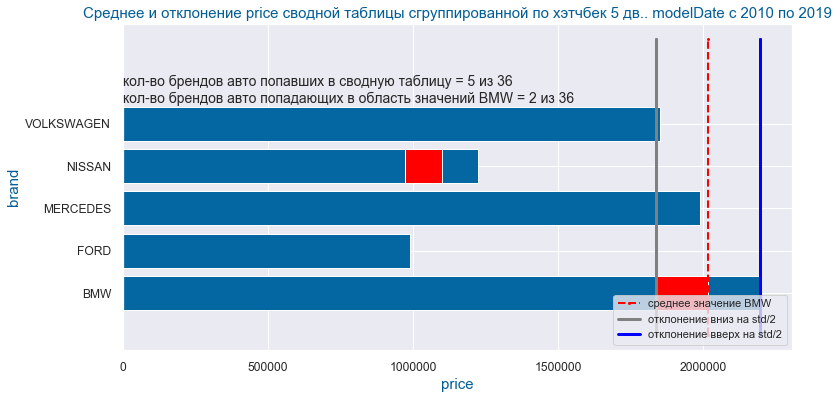

Список релевантных брендов:  MERCEDES VOLKSWAGEN


In [49]:
# посмотрим какие бренды в остальных (68-7=61) электрокаров трейна и как распределены по ним цены
temp_df = temp_df_Train[(temp_df_Train['fuelType']=='электро')] 
list_brand = utils.hbar_group_pivot_table(list_bodyType_test[3], 'price', temp_df, 2010, 2019, 1.1)

***Резюме по fuelType:-*** Категориальный признак. 4 значения ('газ' удалили). Электрокаров BMW в трейне - 7, в тесте - 1. Остальные 61 электрокар существенно ниже по цене, что может привести к снижению цены при моделировании БМВ. Кроме этого, визуальный осмотр значений электрокаров показал что стоит обратить внимание на обрабортку признака объем двигателя по этой группе. К сожалению нет фиксированной связи между можностью автомобиля и объемом двигателя, поэтому для моделирования важно сохранить оба признака, но по электрокарам нет значений и надо будет их как-то заполнить (может быть вывести из киловатов, но и они заполнены не везде)    

In [50]:
# записываем признак в список проанализированных признаков
old_len_train, EDA_done_cols = utils.result_EDA_feature('fuelType', df[df['Train']==1], df[df['Train']==0], 23, EDA_done_cols, old_len_train)

В результате после EDA признака:= fuelType, обработано признаков:= 4, осталось:= 19
Кол-во строк в трейне:=  48705 . Убрали на данном шаге:=  10
Кол-во строк в тесте:=  3837


### 6.5 engineDisplacement

In [51]:
# обработаем значения с помощью регулярных выражений найдя значения объема в литра типа 2.0 и переведем их см3 
def engineDisplacement_to_float(row):
    row = str(row)
    volume = re.findall('\d\.\d', row)
    if volume == []:
        return None
    return int(float(volume[0])*1000)
# поле engineDisplacement заполненно не полностью именно мощностью, в отличии от поля name
# поэтому вытаскиваем мощность из поля name
df['engineDisplacement2'] = df['name'].apply(engineDisplacement_to_float)

In [52]:
# посмотрим сколько пропусков
len(df[df['engineDisplacement2'].isna()])

67

In [53]:
# подозрительно знакомое число видимо это электрокары, проверим 
df[df['engineDisplacement2'].isna()].fuelType.unique()

array(['электро'], dtype=object)

In [54]:
# посмотрим что там внутри 
temp_df_Train = df[df['Train']==1]
temp_df = temp_df_Train[temp_df_Train['engineDisplacement2'].isna() & (temp_df_Train['brand']=='BMW')]
display(temp_df.head(2))
display(temp_df.describe())

bodyType brand        color fuelType                  name  \
8256  хэтчбек 5 дв.   BMW  серебристый  электро  Electro AT (126 кВт)   
8257  хэтчбек 5 дв.   BMW        белый  электро  Electro AT (126 кВт)   

      numberOfDoors                 vehicleConfiguration vehicleTransmission  \
8256            5.0  HATCHBACK_5_DOORS AUTOMATIC Electro      автоматическая   
8257            5.0  HATCHBACK_5_DOORS AUTOMATIC Electro      автоматическая   

     engineDisplacement  enginePower  \
8256            Electro          170   
8257            Electro          170   

                                            description  \
8256  Производство 12 месяц 2014 года. В наличии! Ав...   
8257  Автомобиль в наличии Москве , с ПТС , производ...   

                                           Комплектация  Привод   Руль  \
8256                                        {'id': '0'}  задний  Левый   
8257  {'id': '21624597', 'name': 'i3 120 Ah', 'avail...  задний  Левый   

     Состояние   Владельцы       ПТС Владение model  mileage  modelDate  \
8256       NaN  1 владелец  Оригинал      NaN    I3  89942.0     2013.0   
8257       NaN  1 владелец  Оригинал      NaN    I3  25000.0     2017.0   

      productionDate            start_date  Train  id      price  \
8256          2014.0  2020-08-17T08:51:48Z      1 NaN  1430000.0   
8257          2018.0  2020-08-22T09:38:05Z      1 NaN  2319000.0   

      engineDisplacement2  
8256                  NaN  
8257                  NaN

numberOfDoors  enginePower       mileage    modelDate  productionDate  \
count            7.0          7.0      7.000000     7.000000        7.000000   
mean             5.0        170.0  48356.428571  2014.142857     2016.428571   
std              0.0          0.0  26144.396735     1.951800        1.272418   
min              5.0        170.0  20000.000000  2013.000000     2014.000000   
25%              5.0        170.0  32250.000000  2013.000000     2016.000000   
50%              5.0        170.0  41000.000000  2013.000000     2017.000000   
75%              5.0        170.0  61526.500000  2015.000000     2017.000000   
max              5.0        170.0  89942.000000  2017.000000     2018.000000   

       Train   id         price  engineDisplacement2  
count    7.0  0.0  7.000000e+00                  0.0  
mean     1.0  NaN  2.017469e+06                  NaN  
std      0.0  NaN  3.601556e+05                  NaN  
min      1.0  NaN  1.430000e+06                  NaN  
25%      1.0  NaN  1.795000e+06                  NaN  
50%      1.0  NaN  2.099000e+06                  NaN  
75%      1.0  NaN  2.309000e+06                  NaN  
max      1.0  NaN  2.385286e+06                  NaN

In [55]:
# чтож заполним пропуски аналогичными объемами двигателей автомобилей со следующими параметрами:
# 1 bodyType == хэтчбек 5 дв.
# 2 modelDate от 2013 до 2017
# 3 enginePower = около 170
# 4 price = 2.017469e+06	+ std(3.601556e+05) = (1657314, 2377624) 
# 5 brand == BMW
# 6 fuelType != 'электро'

temp_df = temp_df_Train[(temp_df_Train['bodyType']==list_bodyType_test[3]) & (temp_df_Train['brand']=='BMW') & (temp_df_Train['modelDate']>=2013) & (temp_df_Train['modelDate']<=2017)& (temp_df_Train['price']>=1657314) & (temp_df_Train['modelDate']<=2377624)& (temp_df_Train['enginePower']>=170-10) & (temp_df_Train['enginePower']<=170+10)& (temp_df_Train['fuelType']!='электро')]
display(temp_df.head(2))
display(temp_df.describe())

bodyType brand        color fuelType                       name  \
8254  хэтчбек 5 дв.   BMW  серебристый   гибрид  94Ah 0.7hyb AT (170 л.с.)   
8255  хэтчбек 5 дв.   BMW       чёрный   гибрид  94Ah 0.7hyb AT (170 л.с.)   

      numberOfDoors              vehicleConfiguration vehicleTransmission  \
8254            5.0  HATCHBACK_5_DOORS AUTOMATIC 94Ah      автоматическая   
8255            5.0  HATCHBACK_5_DOORS AUTOMATIC 94Ah      автоматическая   

     engineDisplacement  enginePower  \
8254               94Ah          170   
8255               94Ah          170   

                                            description Комплектация  Привод  \
8254  2017 год (выпущен в сентябре 2017 года) \n94 A...  {'id': '0'}  задний   
8255                                                NaN  {'id': '0'}  задний   

       Руль Состояние   Владельцы       ПТС                    Владение model  \
8254  Левый       NaN  1 владелец  Оригинал  {'year': 2020, 'month': 4}    I3   
8255  Левый       NaN  1 владелец  Оригинал                         NaN    I3   

      mileage  modelDate  productionDate            start_date  Train  id  \
8254  23000.0     2013.0          2017.0  2020-08-30T20:10:49Z      1 NaN   
8255  27000.0     2013.0          2017.0  2020-08-30T08:35:06Z      1 NaN   

          price  engineDisplacement2  
8254  2331000.0                700.0  
8255  1840000.0                700.0

numberOfDoors  enginePower       mileage   modelDate  productionDate  \
count            8.0          8.0      8.000000     8.00000        8.000000   
mean             5.0        170.0  35856.125000  2014.00000     2016.625000   
std              0.0          0.0  13522.039897     1.85164        1.407886   
min              5.0        170.0  17000.000000  2013.00000     2014.000000   
25%              5.0        170.0  26000.000000  2013.00000     2016.500000   
50%              5.0        170.0  35797.500000  2013.00000     2017.000000   
75%              5.0        170.0  44313.500000  2014.00000     2017.250000   
max              5.0        170.0  57000.000000  2017.00000     2018.000000   

       Train   id         price  engineDisplacement2  
count    8.0  0.0  8.000000e+00                  8.0  
mean     1.0  NaN  2.008125e+06                700.0  
std      0.0  NaN  2.436505e+05                  0.0  
min      1.0  NaN  1.699000e+06                700.0  
25%      1.0  NaN  1.830000e+06                700.0  
50%      1.0  NaN  1.932500e+06                700.0  
75%      1.0  NaN  2.257500e+06                700.0  
max      1.0  NaN  2.331000e+06                700.0

In [56]:
# похоже что с такой низкой мощностью близкиеми оказались только гибриды, но 67 пропусков не так много - заполним мощность 700 см3, это на самом деле не объем двигателя гибрида действительно около 700 см3 мощностью 34 л.с, к которым добавляется 170 л.с электромотра в случае экземпляров из первых двух строк выше. И правильно было бы перевести их в усредненный объем двигателя соответсвующий 200 л.с., но с другой стороны все гибриды и электрокары будут с таким маленьким объемом и возможно он сможет найти закономерность и понять что гибриды и электрокары дороже своих аналогов 
df['engineDisplacement2'].fillna(700, inplace = True)

In [57]:
# добавим мощность двигателя engineDisplacement2 в числовые признаки, а engineDisplacement удалим
cat_cols.remove('engineDisplacement') 
num_cols.append('engineDisplacement2')

In [58]:
utils.describe_without_plots('engineDisplacement2', df[df['Train']==1].engineDisplacement2)

engineDisplacement2
кол-во строк                  48705
тип значений                float64
кол-во значений               48705
кол-во NaN                        0
среднее                     2415.81
медиана                        2000
мин                               0
макс                           8200

In [59]:
# надо посмотреть где получились нули
df[df['engineDisplacement2']==0].head(5)

bodyType     brand   color fuelType  \
83620  внедорожник 5 дв.  MERCEDES  чёрный  электро   
83621  внедорожник 5 дв.  MERCEDES  чёрный  электро   

                                 name  numberOfDoors  \
83620  400 Electro AT (300.0 кВт) 4WD            5.0   
83621  400 Electro AT (300.0 кВт) 4WD            5.0   

                vehicleConfiguration vehicleTransmission engineDisplacement  \
83620  ALLROAD_5_DOORS AUTOMATIC 400      автоматическая                400   
83621  ALLROAD_5_DOORS AUTOMATIC 400      автоматическая                400   

       enginePower                                        description  \
83620          408  Комплектация:\nСлужбы "MB-Connect" для навигац...   
83621          408  2020 г. в. MERCEDES-BENZ EQC400 AWD, полный пр...   

                  Комплектация  Привод   Руль Состояние   Владельцы       ПТС  \
83620  {'id': '0', 'name': ''}  полный  Левый       NaN  1 владелец  Оригинал   
83621  {'id': '0', 'name': ''}  полный  Левый       NaN  1 владелец  Оригинал   

                         Владение model  mileage  modelDate  productionDate  \
83620                         NaN   EQC   1771.0     2019.0          2020.0   
83621  {'year': 2020, 'month': 7}   EQC     90.0     2019.0          2020.0   

                 start_date  Train  id      price  engineDisplacement2  
83620  2020-07-07T13:34:32Z      1 NaN  7600000.0                  0.0  
83621  2020-07-19T14:55:05Z      1 NaN  8076322.0                  0.0

In [60]:
# это два электрокара 2019 года выпуска с ценой выше в 2 раза средней по BMW
# удаляем
df = df[df['engineDisplacement2']!=0]

In [61]:
utils.describe_without_plots('engineDisplacement2', df[df['Train']==1].engineDisplacement2)

engineDisplacement2
кол-во строк                  48703
тип значений                float64
кол-во значений               48703
кол-во NaN                        0
среднее                     2415.91
медиана                        2000
мин                             700
макс                           8200

In [62]:
# а какой максимум по BMW в тесте
temp_df = df[df['Train']==0 & (df['brand']=='BMW')]
utils.describe_without_plots('engineDisplacement2', temp_df.engineDisplacement2)

engineDisplacement2
кол-во строк                   3837
тип значений                float64
кол-во значений                3837
кол-во NaN                        0
среднее                     2628.82
медиана                        2500
мин                             700
макс                           6600

In [63]:
# какие авто с объемом двигателя более 6600 см3
temp_df= df[df['engineDisplacement2']>6600]
display(temp_df.head(3))
print(f'Кол-во авто с объемом двигателя более 6600 см3:= {len(temp_df)}')
print(f'Бренды авто с объемом двигателя более 6600 см3:= {list(temp_df.brand.unique())}')

bodyType     brand      color fuelType               name  \
11532  кабриолет  CADILLAC      белый   бензин  8.2 AT (218 л.с.)   
11683      седан  CADILLAC      белый   бензин  7.0 AT (313 л.с.)   
16098      седан  CHRYSLER  пурпурный   бензин  6.8 AT (340 л.с.)   

       numberOfDoors  vehicleConfiguration vehicleTransmission  \
11532            2.0  CABRIO AUTOMATIC 8.2      автоматическая   
11683            4.0   SEDAN AUTOMATIC 7.0      автоматическая   
16098            4.0   SEDAN AUTOMATIC 6.8      автоматическая   

      engineDisplacement  enginePower  \
11532                8.2          218   
11683                7.0          313   
16098                6.8          340   

                                             description Комплектация  \
11532  После реставрация. \nНа учёте. Полностью честн...  {'id': '0'}   
11683  Кадиллак флитвуд 1961 года! (КЦ! Бумаги есть о...  {'id': '0'}   
16098  Крайслер Ньюйоркер 1961, хардтоп, мотор golden...  {'id': '0'}   

         Привод   Руль Состояние    Владельцы       ПТС  \
11532  передний  Левый       NaN  2 владельца  Оригинал   
11683    задний  Левый       NaN  3 или более  Оригинал   
16098    задний  Левый       NaN   1 владелец  Дубликат   

                         Владение       model  mileage  modelDate  \
11532                         NaN    ELDORADO  25000.0     1971.0   
11683                         NaN   FLEETWOOD  70000.0     1956.0   
16098  {'year': 2017, 'month': 2}  NEW_YORKER  70000.0     1960.0   

       productionDate            start_date  Train  id      price  \
11532          1974.0  2020-07-15T21:21:02Z      1 NaN  2600000.0   
11683          1961.0  2020-01-09T23:12:05Z      1 NaN  1650000.0   
16098          1961.0  2020-07-19T07:43:31Z      1 NaN  1600000.0   

       engineDisplacement2  
11532               8200.0  
11683               7000.0  
16098               6800.0

Кол-во авто с объемом двигателя более 6600 см3:= 9
Бренды авто с объемом двигателя более 6600 см3:= ['CADILLAC', 'CHRYSLER', 'FORD']


In [64]:
# удаляем эти 9
df = df[df['engineDisplacement2']<=6600]

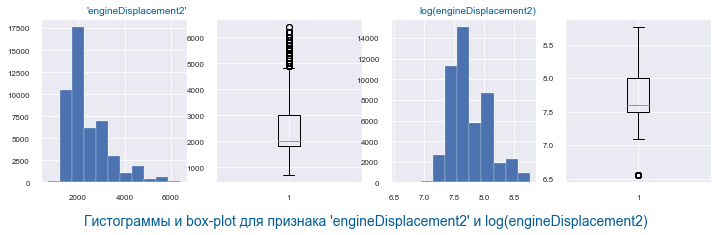

In [65]:
utils.four_plot_with_log2('engineDisplacement2', df[df['Train']==1])

In [66]:
# добавим новый признак логарифм
df['engineDisplacement2_log'] = np.log(df['engineDisplacement2'] + 1)
num_cols.append('engineDisplacement2_log')

***Резюме по engineDisplacement:-*** Создан новый числовой признак объем двигателя в см3. После обработки пропуски оказались по электромобилям. Заполнили пропуски средними значениями по похожим параметрам - ими оказались гибриды с объемом 700 см3. Также удалили выбросы по порогу мин-макс теста по БМВ. Распределение скорее логнормальное - создали новый признак engineDisplacement2_log. 

In [67]:
# записываем признак в список проанализированных признаков
old_len_train, EDA_done_cols = utils.result_EDA_feature('engineDisplacement', df[df['Train']==1], df[df['Train']==0], 23, EDA_done_cols, old_len_train)

В результате после EDA признака:= engineDisplacement, обработано признаков:= 5, осталось:= 18
Кол-во строк в трейне:=  48694 . Убрали на данном шаге:=  11
Кол-во строк в тесте:=  3837


### 6.6 numberOfDoors

In [68]:
# переведем в int64 критерий numberOfDoors
df['numberOfDoors'] = df['numberOfDoors'].astype('int64')

In [69]:
# посмотрим на зависимсть среднего значения цены от кол-ва дверей
df.groupby('numberOfDoors').mean().sort_values(by = 'price').price

numberOfDoors
3    5.236487e+05
4    1.091194e+06
5    1.915941e+06
2    2.815255e+06
Name: price, dtype: float64

In [70]:
utils.describe_without_plots('numberOfDoors', df[df['Train']==1].numberOfDoors)

numberOfDoors
кол-во строк            48694
тип значений            int64
кол-во значений         48694
кол-во NaN                  0
среднее               4.51592
медиана                     5
мин                         2
макс                        5

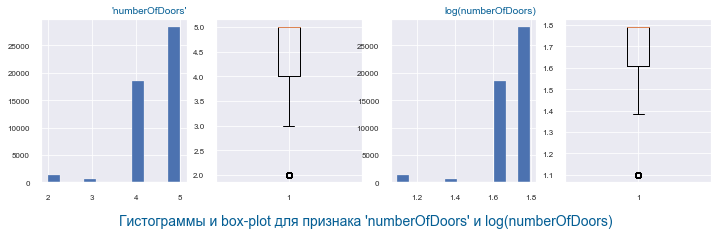

In [71]:
utils.four_plot_with_log2('numberOfDoors', df[df['Train']==1])

In [72]:
# фактически это категориальный признак с 4 значениями, но для корректной групповой обработки числовых признаков переведем его в числовые
cat_cols.remove('numberOfDoors')
num_cols.append('numberOfDoors')

In [73]:
# записываем признак в список проанализированных признаков
old_len_train, EDA_done_cols = utils.result_EDA_feature('numberOfDoors', df[df['Train']==1], df[df['Train']==0], 23, EDA_done_cols, old_len_train)

В результате после EDA признака:= numberOfDoors, обработано признаков:= 6, осталось:= 17
Кол-во строк в трейне:=  48694 . Убрали на данном шаге:=  0
Кол-во строк в тесте:=  3837


### 6.7 mileage

In [74]:
# переведем в int64 критерий numberOfDoors
df['mileage'] = df['mileage'].astype('int64')

In [75]:
utils.describe_without_plots('mileage', df[df['Train']==1].mileage)

mileage
кол-во строк      48694
тип значений      int64
кол-во значений   48694
кол-во NaN            0
среднее          132723
медиана          129000
мин                   0
макс              1e+06

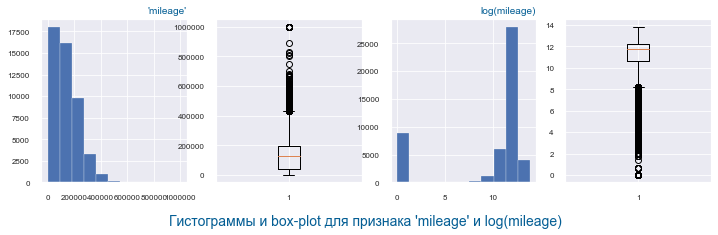

In [76]:
utils.four_plot_with_log2('mileage', df[df['Train']==1])

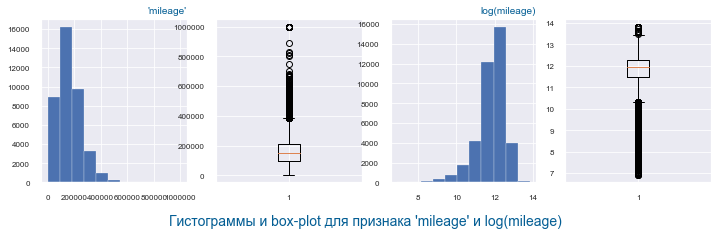

In [77]:
# посмотрим гистограммы на не новых автомобилях
utils.four_plot_with_log2('mileage', df[(df['Train']==1) & (df['mileage']>1000)])

In [78]:
# посмотрим где проходят границы выбросов 
utils.borders_of_outliers('mileage',df[df['Train']==1], log = False)

левая      правая
границы выбросов            -194543.125  431925.875
кол-во значений за границей       0.000     451.000

In [79]:
# посмотрим какие это марки с такими пробегами более 432000
df[(df['Train']==1) & (df['mileage']>432000)].brand.value_counts()

MERCEDES      85
AUDI          73
BMW           73
VOLKSWAGEN    59
TOYOTA        42
NISSAN        26
VOLVO         23
FORD          17
MAZDA          9
SUBARU         8
LAND_ROVER     6
HONDA          6
LEXUS          5
RENAULT        5
SUZUKI         3
CADILLAC       2
JEEP           2
CHRYSLER       1
INFINITI       1
Name: brand, dtype: int64

In [80]:
# посмотрим статистику на тесте по пробегу
utils.describe_without_plots('mileage', df[df['Train']==0].mileage)

mileage
кол-во строк       3837
тип значений      int64
кол-во значений    3837
кол-во NaN            0
среднее          118536
медиана          108000
мин                   1
макс              1e+06

In [81]:
# сколько авто в тесте за границей
df[(df['Train']==0) & (df['mileage']>432000)].brand.value_counts()

BMW    21
Name: brand, dtype: int64

In [82]:
# это полпроцента от объема теста удаляем все пробеги выше 432000 в трейне
df = df[((df['Train']==1) & (df['mileage']<=432000)) | ((df['Train']==0))]

***Резюме по mileage (пробег) *** - признак числовой. Удалили 446 выбросов с пробегом выше 432000 км из трейна. Пропусков нет.

In [83]:
# записываем признак в список проанализированных признаков
old_len_train, EDA_done_cols = utils.result_EDA_feature('mileage', df[df['Train']==1], df[df['Train']==0], 23, EDA_done_cols, old_len_train)

В результате после EDA признака:= mileage, обработано признаков:= 7, осталось:= 16
Кол-во строк в трейне:=  48248 . Убрали на данном шаге:=  446
Кол-во строк в тесте:=  3837


### 6.8 Владельцы

In [84]:
# напомню на этапе предварительного анализа мы не приводили этот признак к единому с тестом виду, поэтому надо будет полностью проанализировать значения и уже сразу понять в каком виде лучше их оставить для дальнейшего моделирования
# статистика по значениям в трейне
temp_df = df[df['Train']==1]
temp_df['Владельцы'].value_counts(normalize=True)

3 или более    0.496169
2 владельца    0.272799
1 владелец     0.231032
Name: Владельцы, dtype: float64

In [85]:
# статистика по значениям в тесте
temp_df = df[df['Train']==0]
temp_df['Владельцы'].value_counts(normalize=True)

3 или более    0.395100
1 владелец     0.341152
2 владельца    0.263748
Name: Владельцы, dtype: float64

In [86]:
# на этапе предварительного анализа были пропуски , проверим
len(df[df['Владельцы'].isna()])

8959

In [87]:
temp_df['Владельцы'].unique()

array(['1\xa0владелец', '2\xa0владельца', '3 или более'], dtype=object)

In [88]:
# посмотрим статистику по пробегу по 2 владельцам 
df[(df['Владельцы']=='2\xa0владельца') & (df['mileage']>0)].mileage.describe()

count     11730.000000
mean     141839.052515
std       75009.179429
min          10.000000
25%       89000.000000
50%      132000.000000
75%      182000.000000
max      432000.000000
Name: mileage, dtype: float64

In [89]:
# посмотрим статистику по пробегу по 3 и более владельцам 
df[(df['Владельцы']=='3 или более') & (df['mileage']>0)].mileage.describe()

count     21010.000000
mean     193407.181009
std       81179.099860
min           5.000000
25%      136788.750000
50%      183000.000000
75%      240249.250000
max      520416.000000
Name: mileage, dtype: float64

In [90]:
# переведем в числовой формат 
# вытащим значение мощности перед первым пробелом'
df.loc[:, 'Владельцы'] = df['Владельцы'].apply(lambda x: int(x.split()[0]) if type(x)==str else None)

In [91]:
# заполним Владельцев по следующему принципу
# пробег от 100000 км - 2 владельца
# пробег от 150000 км - 3 владельца
# если меньше 100000 км - 1 владелец
# и тут нас ждет фиаско потому что пробег по этим автомобилям 0
df.loc[df['Владельцы'].isna()].mileage.describe()

count    8959.0
mean        0.0
std         0.0
min         0.0
25%         0.0
50%         0.0
75%         0.0
max         0.0
Name: mileage, dtype: float64

In [92]:
# ну чтож посмотрим на пропуски в пробеге
df.loc[df['Владельцы'].isna()].head(3)

bodyType brand        color fuelType                name  numberOfDoors  \
332    седан  AUDI        серый   бензин  1.4 AMT (150 л.с.)              4   
333    седан  AUDI  серебристый   бензин  1.4 AMT (150 л.с.)              4   
336    седан  AUDI        синий   бензин  1.4 AMT (150 л.с.)              4   

    vehicleConfiguration vehicleTransmission engineDisplacement  enginePower  \
332      SEDAN ROBOT 1.4    роботизированная                1.4          150   
333      SEDAN ROBOT 1.4    роботизированная                1.4          150   
336      SEDAN ROBOT 1.4    роботизированная                1.4          150   

                                           description  \
332  Эксклюзивные условия в Ауди Центре Север.\nТол...   
333  Эксклюзивные условия в Ауди Центре Север.\nТол...   
336  Новый дилерский центр Ауди в Москве.\n\nУникал...   

                                          Комплектация    Привод   Руль  \
332  {'id': '21597097', 'name': '35 TFSI S tronic',...  передний  Левый   
333  {'id': '21597097', 'name': '35 TFSI S tronic',...  передний  Левый   
336  {'id': '20838807', 'name': 'Basis', 'available...  передний  Левый   

    Состояние  Владельцы       ПТС Владение model  mileage  modelDate  \
332       NaN        NaN  Оригинал      NaN    A3        0     2016.0   
333       NaN        NaN  Оригинал      NaN    A3        0     2016.0   
336       NaN        NaN  Оригинал      NaN    A3        0     2016.0   

     productionDate            start_date  Train  id      price  \
332          2020.0  2020-08-10T18:16:24Z      1 NaN  1885400.0   
333          2020.0  2020-08-10T18:16:24Z      1 NaN  1885400.0   
336          2020.0  2020-08-04T16:44:36Z      1 NaN  1885400.0   

     engineDisplacement2  engineDisplacement2_log  
332               1400.0                 7.244942  
333               1400.0                 7.244942  
336               1400.0                 7.244942

In [93]:
# вроде бы это новые автомобили, проверим
df.loc[df['Владельцы'].isna()].productionDate.describe()

count    8959.000000
mean     2019.915839
std         0.298194
min      2018.000000
25%      2020.000000
50%      2020.000000
75%      2020.000000
max      2020.000000
Name: productionDate, dtype: float64

In [94]:
# статистика по году производства в %
df[df['Владельцы'].isna()].productionDate.value_counts(normalize=True)

2020.0    0.921755
2019.0    0.072330
2018.0    0.005916
Name: productionDate, dtype: float64

In [95]:
# видно что это новые автомобили, поэтому заполним Владельцев нулями
df['Владельцы'].fillna(0.0, inplace=True)

In [96]:
# переводим в int64
df['Владельцы'] = df['Владельцы'].astype('int64')

In [97]:
utils.describe_without_plots('Владельцы', df[df['Train']==1].Владельцы)

Владельцы
кол-во строк        48248
тип значений        int64
кол-во значений     48248
кол-во NaN              0
среднее           1.84453
медиана                 2
мин                     0
макс                    3

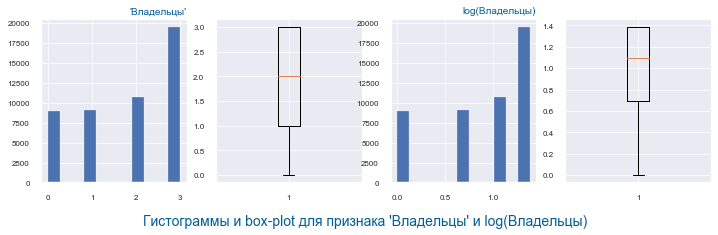

In [98]:
utils.four_plot_with_log2('Владельцы', df[df['Train']==1])

In [99]:
# фактически это категориальный признак с 4 значениями, но для корректной групповой обработки числовых признаков переведем его в числовые
cat_cols.remove('Владельцы')
num_cols.append('Владельцы')

***Резюме по Владельцы*** - категориальный признак с 4 значениями. В ходе EDA выяснилось, что пропуски в новых автомобилях с годом производства 2020-2019 год, поэтому было добавлено еще одно значение 0. Теперь пропусков нет. Распределение с хвостом слева. 

In [100]:
# записываем признак в список проанализированных признаков
old_len_train, EDA_done_cols = utils.result_EDA_feature('Владельцы', df[df['Train']==1], df[df['Train']==0], 23, EDA_done_cols, old_len_train)

В результате после EDA признака:= Владельцы, обработано признаков:= 8, осталось:= 15
Кол-во строк в трейне:=  48248 . Убрали на данном шаге:=  0
Кол-во строк в тесте:=  3837


### 6.9 price  
Посмотрим на стоимость выбранных нами авто из тренировочной выборки

In [101]:
# сначала посмотрим на кол-во пропусков 
df[df['Train']==1]['price'].isna().sum()

220

In [102]:
# затем как распределены пропуски по брендам
df[(df['Train']==1)&(df['price'].isna())]['brand'].value_counts()

MERCEDES      28
BMW           26
TOYOTA        22
NISSAN        21
VOLKSWAGEN    21
FORD          16
VOLVO         11
MAZDA         11
AUDI          10
RENAULT        8
LEXUS          8
LAND_ROVER     7
HONDA          5
SUZUKI         5
INFINITI       4
PORSCHE        4
JEEP           3
CADILLAC       3
SUBARU         2
CHRYSLER       2
JAGUAR         2
MINI           1
Name: brand, dtype: int64

In [103]:
# Пропуски цены есть практически во всех моделях. Удаляем эти данные, т.к. их менее 1%, и даже если мы их будем заполнять ближними значениями, тратить смысл на подгонку целевых переменных нет
df = df[((df['Train']==1)&(df['price'].isna()==False)) | (df['Train']==0)]

In [104]:
utils.describe_without_plots('price', df[df['Train']==1].price)

price
кол-во строк           48028
тип значений         float64
кол-во значений        48028
кол-во NaN                 0
среднее          1.62375e+06
медиана               850000
мин                    23000
макс                 9.9e+07

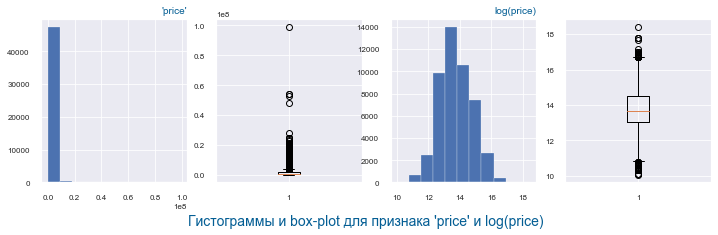

In [105]:
utils.four_plot_with_log2('price', df[df['Train']==1])

In [106]:
# распределение выглядит как логнормальное, посмотрим на выбросы и статистику мин-макс на BMW
# посмотрим где проходят границы выбросов 
utils.borders_of_outliers('price',df[df['Train']==1], log = True)

левая        правая
границы выбросов с логарифмом      10.815196  1.668669e+01
границы выбросов без логарифма  49770.416237  1.765777e+07
кол-во значений за границей        66.000000  4.500000e+01

In [107]:
# а что по БМВ?
utils.describe_without_plots('price', df[(df['Train']==1) & (df['brand']=='BMW')].price)

price
кол-во строк            6400
тип значений         float64
кол-во значений         6400
кол-во NaN                 0
среднее          2.30215e+06
медиана             1.55e+06
мин                    60000
макс             1.47812e+07

In [108]:
# посмотрим сколько выбросов менее 60000 (мин БМВ) и более 	1.47812e+07 (макс БМВ)
len(df[(df['price']<60000) | (df['price']>1.47812e+07)])

252

In [109]:
# не много взглянем на них
df[(df['price']<60000) | (df['price']>1.47812e+07)].head(3)

bodyType brand        color fuelType               name  numberOfDoors  \
63    седан  AUDI   коричневый   бензин  1.9 MT (100 л.с.)              4   
77    седан  AUDI  серебристый   бензин   1.8 MT (90 л.с.)              4   
96    седан  AUDI      красный   бензин   1.8 MT (90 л.с.)              4   

    vehicleConfiguration vehicleTransmission engineDisplacement  enginePower  \
63  SEDAN MECHANICAL 1.9        механическая                1.9          100   
77  SEDAN MECHANICAL 1.8        механическая                1.8           90   
96  SEDAN MECHANICAL 1.8        механическая                1.8           90   

                                          description Комплектация    Привод  \
63  Продам Аudi 100.Состояние среднее, под восстан...  {'id': '0'}  передний   
77                                           На ходу.  {'id': '0'}  передний   
96  На ходу, много новых деталей. Требует косметик...  {'id': '0'}  передний   

     Руль Состояние  Владельцы       ПТС Владение model  mileage  modelDate  \
63  Левый       NaN          3  Оригинал      NaN   100   100000     1982.0   
77  Левый       NaN          3  Оригинал      NaN   100   180000     1982.0   
96  Левый       NaN          1  Оригинал      NaN   100   318800     1982.0   

    productionDate            start_date  Train  id    price  \
63          1983.0  2020-02-15T12:37:28Z      1 NaN  30000.0   
77          1985.0  2019-07-25T15:54:27Z      1 NaN  40000.0   
96          1984.0  2020-01-10T07:43:01Z      1 NaN  45000.0   

    engineDisplacement2  engineDisplacement2_log  
63               1900.0                 7.550135  
77               1800.0                 7.496097  
96               1800.0                 7.496097

In [110]:
# вроде как визуально старые авто проверим
df[(df['price']<60000) | (df['price']>1.47812e+07)].modelDate.value_counts(bins=5)

(2006.2, 2020.0]     115
(1978.6, 1992.4]     102
(1992.4, 2006.2]      27
(1950.93, 1964.8]      5
(1964.8, 1978.6]       3
Name: modelDate, dtype: int64

In [111]:
# нет не старые совсем даже
# убедимся что БМВ среди них нет и будем удалять
df[(df['price']<60000) | (df['price']>1.47812e+07)].brand.value_counts()

MERCEDES      117
AUDI           31
VOLKSWAGEN     27
FORD           17
NISSAN         16
MAZDA          11
VOLVO           9
RENAULT         7
TOYOTA          5
LAND_ROVER      4
CADILLAC        2
HONDA           2
SUBARU          2
PORSCHE         1
CHRYSLER        1
Name: brand, dtype: int64

In [112]:
# удаляем выбросы по цене 
df = df[((df['Train']==1) & (df['price']>=60000) & (df['price']<1.47812e+07)) | (df['Train']==0)]

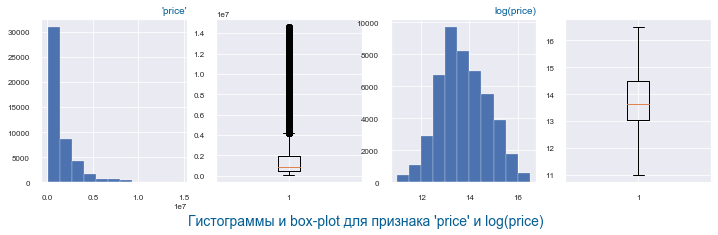

In [113]:
# еще раз смотрим на гистограммы
utils.four_plot_with_log2('price', df[df['Train']==1])

In [114]:
# ну теперь получилось очень красивое логнормальное распределение, хотя конечно необходимо было сначала проверить гипотезу о нормальном распределении, мы этот момент опустили из-за нехватки времени, просто создаем новый признак price_log логарифм от цены
df['price_log']=df['price'].apply(lambda x: np.log(x))

# добавим новый признак в список целевых, посмотрим что лучше обрабатывает медель потом при необходимости менее эффективный удалим
target_col.append('price_log')

***Резюме по price (стоимость)*** - целевая переменная. Удалили 220 пропусков из трейна. Удалили 253 выброса по цене снизу и сверху. Распределение скорее логнормальное и чистое без выросов. Добавили новый признак логарифм от прайса. Теперь пропусков нет.

In [115]:
# записываем признак в список проанализированных признаков
old_len_train, EDA_done_cols = utils.result_EDA_feature('price', df[df['Train']==1], df[df['Train']==0], 23, EDA_done_cols, old_len_train)

В результате после EDA признака:= price, обработано признаков:= 9, осталось:= 14
Кол-во строк в трейне:=  47775 . Убрали на данном шаге:=  473
Кол-во строк в тесте:=  3837


### 6.10 modelDate

In [116]:
utils.describe_without_plots('modelDate', df[df['Train']==1].modelDate)

modelDate
кол-во строк        47775
тип значений      float64
кол-во значений     47775
кол-во NaN              0
среднее            2009.2
медиана              2010
мин                  1951
макс                 2020

In [117]:
utils.describe_without_plots('modelDate', df[df['Train']==0].modelDate)

modelDate
кол-во строк         3837
тип значений      float64
кол-во значений      3837
кол-во NaN              0
среднее           2009.95
медиана              2011
мин                  1975
макс                 2019

In [118]:
# пропусков нет
# в тесте нет моделей 2020 нет моделей младше 1975 года 
# посмотрим сколько их
len(df[(df['Train']==1) & ((df['modelDate']<1975) | (df['modelDate']>2019))])

782

In [119]:
# посмотрим на марки датой выпуска меньше 1975
df[(df['Train']==1) & (df['modelDate']<1975)].brand.value_counts()

MERCEDES    24
VOLVO        5
BMW          3
FORD         3
CADILLAC     2
PORSCHE      1
Name: brand, dtype: int64

In [120]:
# их немного 38 удаляем точно, а что с марками датой выпуска 2020
df[(df['Train']==1) & (df['modelDate']==2020)].brand.value_counts()

VOLKSWAGEN    287
MERCEDES      252
BMW           174
RENAULT        21
MINI            8
VOLVO           2
Name: brand, dtype: int64

In [121]:
# можно было не смотреть марки 2020 года так как мы строим модель прогноза цен где таких моделей нет их нужно просто удалить по порогу и все
df = df[((df['Train']==1) & (df['modelDate']>=1975) & (df['modelDate']<=2019)) | (df['Train']==0)]

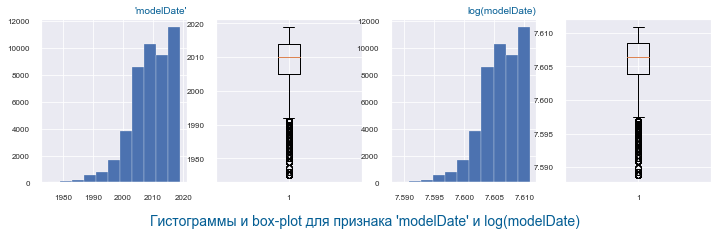

In [122]:
# посмотрим гистограммы
utils.four_plot_with_log2('modelDate', df[df['Train']==1])

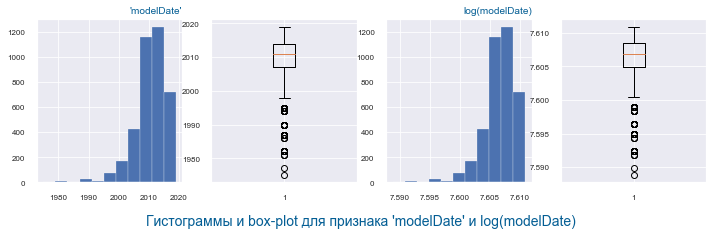

In [123]:
# посмотрим на тест
utils.four_plot_with_log2('modelDate', df[df['Train']==0])

In [124]:
# визуально можно заметить что основная часть автомобилей, что в тестовой, что в тренировочной выборке начинается с начала-середины 90х
# посмотрим еще срезы по кол-ву значений чтоы убедиться в этом
# статистика по значениям modelDate в трейне
temp_df = df[df['Train']==1]
temp_df['modelDate'].value_counts(bins=10)

(2005.8, 2010.2]      13770
(2014.6, 2019.0]      11537
(2010.2, 2014.6]       9487
(2001.4, 2005.8]       6562
(1997.0, 2001.4]       2830
(1992.6, 1997.0]       1596
(1988.2, 1992.6]        607
(1983.8, 1988.2]        446
(1979.4, 1983.8]        112
(1974.955, 1979.4]       46
Name: modelDate, dtype: int64

In [125]:
# статистика по значениям modelDate в тесте
temp_df = df[df['Train']==0]
temp_df['modelDate'].value_counts(bins=10)

(2005.8, 2010.2]      1364
(2010.2, 2014.6]      1235
(2014.6, 2019.0]       719
(2001.4, 2005.8]       271
(1997.0, 2001.4]       146
(1992.6, 1997.0]        52
(1983.8, 1988.2]        21
(1979.4, 1983.8]        14
(1988.2, 1992.6]        13
(1974.955, 1979.4]       2
Name: modelDate, dtype: int64

***Резюме по modelDate*** - числовой признак, удалили выбросы 782 авто старше 1975 года и за 2020 год. Пропусков нет. Не удалось составить статистику завсисимости цены от года выпуска, даты производства и бренда авто, чтобы отделить раритетные автомобили и правильно прогнозировать по ним цену. Целевая метрика очень чувствительна к ошибкам - так если мы все автомобили угадаем на 100%, а в 50 автомобилях старше 1992 года сделаем ошибку в два раза на 500000 рублей при их стоимости примерно 500000 рублей, то  MAPE вырастет на = 1/3837\*(50\*100%) = 1.32%. С учетом того, что на лб разница между 10-м (9.76) и 20 местом (11.26) = 1.5%, то нужно стремиться научить модель предсказывать все автомобили достаточно хорошо. Мы не будем здесь расскрывать тему того, что целевая метрика обладает большими недостатками и плохо оценивает эффективность алгоритма прогнозирования. Мы сделаем это ниже.

In [126]:
# записываем признак в список проанализированных признаков
old_len_train, EDA_done_cols = utils.result_EDA_feature('modelDate', df[df['Train']==1], df[df['Train']==0], 23, EDA_done_cols, old_len_train)

В результате после EDA признака:= modelDate, обработано признаков:= 10, осталось:= 13
Кол-во строк в трейне:=  46993 . Убрали на данном шаге:=  782
Кол-во строк в тесте:=  3837


### 6.11 productionDate

In [127]:
# посмотрим на трейн
utils.describe_without_plots('productionDate', df[df['Train']==1].productionDate)

productionDate
кол-во строк             46993
тип значений           float64
кол-во значений          46993
кол-во NaN                   0
среднее                2011.18
медиана                   2012
мин                       1976
макс                      2020

In [128]:
# теперь на тест
utils.describe_without_plots('productionDate', df[df['Train']==0].productionDate)

productionDate
кол-во строк              3837
тип значений           float64
кол-во значений           3837
кол-во NaN                   0
среднее                2011.93
медиана                   2013
мин                       1981
макс                      2019

In [129]:
# посмотрим сколько авто с датой производства 2020
len(df[(df['Train']==1) & (df['productionDate']>2019)])

7609

In [130]:
# такое большое кол-во это нормально так как датасет для соревнования формировался в феврале, то в тесте авто с датой производства 2020 нет - удалим их
# посмотрим сколько авто с датой производства менее 1981 в трейне
len(df[(df['Train']==1) & (df['productionDate']<1981)])

8

In [131]:
# удалим выбросы по порогу
df = df[((df['Train']==1) & (df['productionDate']>=1981) & (df['productionDate']<=2019)) | (df['Train']==0)]

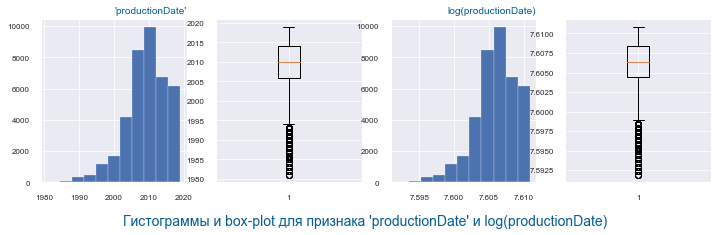

In [132]:
utils.four_plot_with_log2('productionDate', df[df['Train']==1])

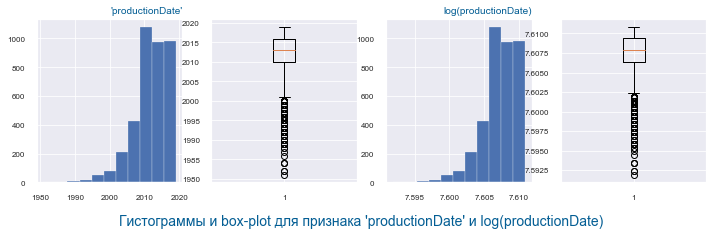

In [133]:
utils.four_plot_with_log2('productionDate', df[df['Train']==0])

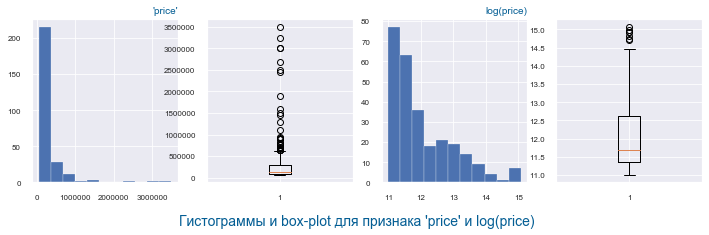

In [134]:
# Посмотрим, как влияет год выпуска на распределение стоимости автомобиля
utils.four_plot_with_log2('price', df[(df['Train']==1)&(df['productionDate']<1990)])

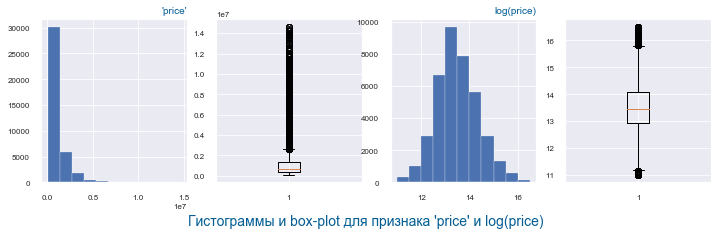

In [135]:
utils.four_plot_with_log2('price', df[(df['Train']==1)&(df['productionDate']>1990)])

In [136]:
df[(df['Train']==1)&(df['productionDate']<1990)].price.describe()

count    2.690000e+02
mean     3.069347e+05
std      5.103985e+05
min      6.000000e+04
25%      8.500000e+04
50%      1.200000e+05
75%      3.000000e+05
max      3.500000e+06
Name: price, dtype: float64

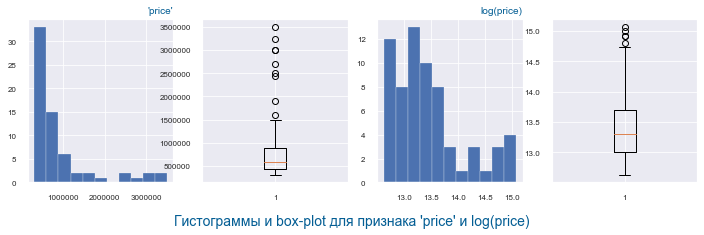

In [137]:
# Посмотрим на авто, стоимость которых заметно выше остальных:
utils.four_plot_with_log2('price', df[(df['Train']==1)&(df['productionDate']<1990)&(df['price']>300000)])

In [138]:
# Добавим дополнительный признак 'intensity', который равен пробегу, поделенному на возраст авто, а также 'dateModelProdDiff', равный разнице между годом выпуска авто и годом начала производства модели
current_year = 2020
df['intensity']=df['mileage']/(current_year-df['productionDate'])
df['dateModelProdDiff']=df['productionDate']-df['modelDate']

# добавляем новые признаки
num_cols.append('intensity')
num_cols.append('dateModelProdDiff')

In [139]:
# Посмотрим на стоимость еще внимательнее
df[(df['Train']==1)&(df['productionDate']<1990)&(df['price']>1000000)].describe()

numberOfDoors  enginePower  Владельцы        mileage    modelDate  \
count      13.000000    13.000000  13.000000      13.000000    13.000000   
mean        2.923077   209.923077   2.230769  151611.230769  1980.692308   
std         1.037749    51.870771   0.926809   88210.896944     3.326275   
min         2.000000   125.000000   1.000000    4500.000000  1976.000000   
25%         2.000000   160.000000   1.000000  108000.000000  1979.000000   
50%         2.000000   218.000000   3.000000  128000.000000  1979.000000   
75%         4.000000   242.000000   3.000000  194446.000000  1985.000000   
max         4.000000   295.000000   3.000000  339000.000000  1985.000000   

       productionDate  Train   id         price  engineDisplacement2  \
count       13.000000   13.0  0.0  1.300000e+01            13.000000   
mean      1985.230769    1.0  NaN  2.248846e+06          3915.384615   
std          2.087816    0.0  NaN  8.137417e+05          1500.470012   
min       1982.000000    1.0  NaN  1.100000e+06          1300.000000   
25%       1984.000000    1.0  NaN  1.500000e+06          2800.000000   
50%       1985.000000    1.0  NaN  2.450000e+06          3800.000000   
75%       1986.000000    1.0  NaN  3.000000e+06          5400.000000   
max       1989.000000    1.0  NaN  3.500000e+06          5600.000000   

       engineDisplacement2_log  price_log    intensity  dateModelProdDiff  
count                13.000000  13.000000    13.000000          13.000000  
mean                  8.188177  14.559786  4406.140586           4.538462  
std                   0.457360   0.387581  2513.417412           3.381700  
min                   7.170888  13.910821   118.421053           0.000000  
25%                   7.937732  14.220976  3000.000000           1.000000  
50%                   8.243019  14.711599  3941.176471           5.000000  
75%                   8.594339  14.914123  5719.000000           6.000000  
max                   8.630700  15.068274  9162.162162          10.000000

In [140]:
df[(df['Train']==1)&(df['productionDate']<1990)&(df['price']<1000000)].describe()

numberOfDoors  enginePower   Владельцы        mileage    modelDate  \
count     256.000000   256.000000  256.000000     256.000000   256.000000   
mean        3.976562   126.601562    2.750000  257421.742188  1983.949219   
std         0.644310    41.331817    0.538699  103961.155674     3.319780   
min         2.000000    90.000000    1.000000     200.000000  1975.000000   
25%         4.000000    90.000000    3.000000  189250.000000  1982.000000   
50%         4.000000   114.000000    3.000000  267500.000000  1984.000000   
75%         4.000000   136.250000    3.000000  341068.500000  1987.000000   
max         5.000000   310.000000    3.000000  422000.000000  1988.000000   

       productionDate  Train   id          price  engineDisplacement2  \
count      256.000000  256.0  0.0     256.000000           256.000000   
mean      1986.906250    1.0  NaN  208322.039062          2323.046875   
std          2.112289    0.0  NaN  201532.874831           820.936871   
min       1981.000000    1.0  NaN   60000.000000          1600.000000   
25%       1986.000000    1.0  NaN   80000.000000          1800.000000   
50%       1988.000000    1.0  NaN  120000.000000          2000.000000   
75%       1989.000000    1.0  NaN  230000.000000          2300.000000   
max       1989.000000    1.0  NaN  950000.000000          5600.000000   

       engineDisplacement2_log   price_log     intensity  dateModelProdDiff  
count               256.000000  256.000000    256.000000         256.000000  
mean                  7.705584   11.912977   7862.185175           2.957031  
std                   0.280545    0.760399   3296.673556           2.355242  
min                   7.378384   11.002100      6.060606           0.000000  
25%                   7.496097   11.289782   5748.355263           1.000000  
50%                   7.601402   11.695247   8064.516129           2.000000  
75%                   7.741099   12.345835  10322.580645           5.000000  
max                   8.630700   13.764217  13252.645161          13.000000

In [141]:
# Пока непонятно как выделять раритеты (~10% от датасета), предположим, что на это влияет интенсивность использования. 75% для раритетов это около 4215 км/год, а для не раритетов 25% начинается с 5670 км/год. Попробуем разделить по границе 5000 км/год, добавим дополнительный признак 'rarity'
df['rarity']=(df['intensity']<5000)&(df['productionDate']<1990)

# добавляем новые признаки
bin_cols.append('rarity')

In [ ]:
# Этот ноутбук - укороченная версия для отображения на гитхабе
# код ниже не запускался и не выполнялся так как сильно увеличивает размер ноутбука
# полная версия ноутбука доступна в этой же папке, 
# для просмотра вы можете сделать клон репы и просмотреть на локальном копьютере

# # Посмотрим как меняется стоимость авто в зависимости от года выпуска
# df_temp = df[(df['Train']==1)&(df['productionDate']<2020)&(df['rarity']==False)]
# df_temp_bmw = df_temp[df['brand']=='BMW']
# year = df_temp['productionDate'].values
# price = df_temp['price'].values
# year_bmw = df_temp_bmw['productionDate'].values
# price_bmw = df_temp_bmw['price'].values
# plt.figure(figsize=(20,10))
# plt.scatter(year,price,c='b')
# plt.scatter(year_bmw,price_bmw,c='r')

***Резюме*** Визуально характер стоимости делится на несколько участков:
- первые пять лет стоимость падает очень  быстро (видимо падает престиж)
- следующие 10 лет медленнее (авто перестает быть аттрибутом, становится инструментом)
- остальные посмотрим внимательнее

In [ ]:
# Этот ноутбук - укороченная версия для отображения на гитхабе
# код ниже не запускался и не выполнялся так как сильно увеличивает размер ноутбука
# полная версия ноутбука доступна в этой же папке, 
# для просмотра вы можете сделать клон репы и просмотреть на локальном копьютере

# df_temp = df[(df['Train']==1)&(df['productionDate']<2005)&(df['rarity']==False)]
# df_temp_bmw = df_temp[df['brand']=='BMW']
# year = df_temp['productionDate'].values
# price = df_temp['price'].values
# year_bmw = df_temp_bmw['productionDate'].values
# price_bmw = df_temp_bmw['price'].values
# plt.figure(figsize=(20,10))
# plt.scatter(year,price,c='b')
# plt.scatter(year_bmw,price_bmw,c='r')

***Резюме*** - Еще 15 лет стоимость как то держится, уменьшается количество машин, дальше уже начинаются непредсказуемые вещи, которые зависят от характера использования авто. Разделим датасет на несколько периодов:  
1. новее 2015  
2. 2015-2005  
3. 2005-1990  
4. старше 1990  

Чем старше авто, тем меньше в нем всяких электронных фич, тем больше мощность, посмотрим, будет ли этот признак иметь значение

In [144]:
# добавляем 4 новых признака
df['pDate_more_2015']=df['productionDate']>=2015
df['pDate_more_2005']=(df['productionDate']>=2005)&(df['productionDate']<2015)
df['pDate_more_1990']=(df['productionDate']>=1990)&(df['productionDate']<2005)
df['pDate_less_1990']=(df['productionDate']<1990)

# добавляем новые признаки
bin_cols.append('pDate_more_2015')
bin_cols.append('pDate_more_2005')
bin_cols.append('pDate_more_1990')
bin_cols.append('pDate_less_1990')

***Резюме по productionDate*** - числовой признак,   
добавили 2 числовых признака: 
- intensity 
- dateModelProdDiff  

и 5 бинарных признаков:
- rarity
- pDate_more_2015
- pDate_more_2005
- pDate_more_1990
- pDate_less_1990

In [145]:
# записываем признак в список проанализированных признаков
old_len_train, EDA_done_cols = utils.result_EDA_feature('productionDate', df[df['Train']==1], df[df['Train']==0], 23, EDA_done_cols, old_len_train)

В результате после EDA признака:= productionDate, обработано признаков:= 11, осталось:= 12
Кол-во строк в трейне:=  39376 . Убрали на данном шаге:=  7617
Кол-во строк в тесте:=  3837


### 6.12 vehicleConfiguration

In [146]:
temp_df = df[df['Train']==1]
temp_df['vehicleConfiguration'].value_counts(normalize=True)

SEDAN MECHANICAL 1.6                0.046424
SEDAN AUTOMATIC 1.6                 0.031644
ALLROAD_5_DOORS AUTOMATIC 2.0       0.027326
ALLROAD_5_DOORS AUTOMATIC 3.0d      0.025447
ALLROAD_5_DOORS VARIATOR 2.0        0.025295
                                      ...   
COUPE AUTOMATIC 1.7                 0.000025
HATCHBACK_3_DOORS AUTOMATIC 120d    0.000025
ROADSTER AUTOMATIC 1.9              0.000025
HATCHBACK_3_DOORS AUTOMATIC 2.5     0.000025
SEDAN ROBOT 1.5                     0.000025
Name: vehicleConfiguration, Length: 1076, dtype: float64

In [147]:
# статистика по значениям в тесте
temp_df = df[df['Train']==0]
temp_df['vehicleConfiguration']

89378              SEDAN AUTOMATIC 2.0
89379              SEDAN AUTOMATIC 2.0
89380              SEDAN AUTOMATIC 4.4
89381    ALLROAD_5_DOORS AUTOMATIC 3.0
89382    ALLROAD_5_DOORS AUTOMATIC 3.0
                     ...              
93210              SEDAN AUTOMATIC 2.0
93211    ALLROAD_5_DOORS AUTOMATIC 3.0
93212              SEDAN AUTOMATIC 2.5
93213              SEDAN AUTOMATIC 2.0
93214    ALLROAD_5_DOORS AUTOMATIC 4.4
Name: vehicleConfiguration, Length: 3837, dtype: object

***Резюме по vehicleConfiguration*** - в нем есть все, что есть в других колонках, можно удалять

In [148]:
# удаляем
cat_cols.remove('vehicleConfiguration')

In [149]:
# записываем признак в список проанализированных признаков
old_len_train, EDA_done_cols = utils.result_EDA_feature('vehicleConfiguration', df[df['Train']==1], df[df['Train']==0], 23, EDA_done_cols, old_len_train)

В результате после EDA признака:= vehicleConfiguration, обработано признаков:= 12, осталось:= 11
Кол-во строк в трейне:=  39376 . Убрали на данном шаге:=  0
Кол-во строк в тесте:=  3837


### 6.13 vehicleTransmission

In [150]:
# статистика по значениям в трейне
temp_df = df[df['Train']==1]
temp_df['vehicleTransmission'].value_counts()

автоматическая      23876
механическая         8311
роботизированная     3614
вариатор             3575
Name: vehicleTransmission, dtype: int64

In [151]:
# статистика по значениям в тесте
temp_df = df[df['Train']==0]
temp_df['vehicleTransmission'].value_counts()

автоматическая      3677
механическая         111
роботизированная      49
Name: vehicleTransmission, dtype: int64

In [152]:
# удалим вариатор
df = df[((df['Train']==1) & (df['vehicleTransmission']!='вариатор')) | (df['Train']==0)]

In [153]:
# посмотрим на кол-во пропусков 
df[df['Train']==1]['vehicleTransmission'].isna().sum()

0

***Резюме по vehicleTransmission*** - категориальный признак, 4 значения, пропусков нет

In [154]:
# записываем признак в список проанализированных признаков
old_len_train, EDA_done_cols = utils.result_EDA_feature('vehicleTransmission', df[df['Train']==1], df[df['Train']==0], 23, EDA_done_cols, old_len_train)

В результате после EDA признака:= vehicleTransmission, обработано признаков:= 13, осталось:= 10
Кол-во строк в трейне:=  35801 . Убрали на данном шаге:=  3575
Кол-во строк в тесте:=  3837


### 6.14 Комплектация

In [155]:
# можно вспомнить предварительный анализ трейна с помощью PandasProffiling из которого следовало что этот признак не заполнен даже на половину (это значение "{'id': '0'}" было доминирующим). Посмотрим что изменилось
temp_df = df[df['Train']==1]
(temp_df['Комплектация']=="{'id': '0'}").sum()/len(temp_df)

0.7574090109214826

In [156]:
# более 75% процентов признака не заполнено в трейне, удаляем
cat_cols.remove('Комплектация')

***Резюме по Комплектация*** - более 75% процентов признака не заполнено в трейне, удаляем

In [157]:
# записываем признак в список проанализированных признаков
old_len_train, EDA_done_cols = utils.result_EDA_feature('Комплектация', df[df['Train']==1], df[df['Train']==0], 23, EDA_done_cols, old_len_train)

В результате после EDA признака:= Комплектация, обработано признаков:= 14, осталось:= 9
Кол-во строк в трейне:=  35801 . Убрали на данном шаге:=  0
Кол-во строк в тесте:=  3837


### 6.15 description

In [158]:
# Описание в трейне
temp_df = df[df['Train']==1]
temp_df['description'].iloc[2]

'ПТС Оригинал!\nПолный комплект ключей!\nПо результатам комплексной диагностики автомобиля серьезных замечаний не выявлено.\n\nКомплектация:\n•\tАнтиблокировочная система\n•\tАнтипробуксовочная система\n•\tСистема курсовой устойчивости\n•\tБлокировка замков задних дверей\n•\tСигнализация\n•\tИммобилайзер\n•\tЦентральный замок\n•\tУсилитель руля\n•\tАктивный усилитель руля\n•\tЭлектропривод зеркал\n•\tАудиосистема\n•\tАудиоподготовка\n•\tРозетка 12V\nБолее 200 автомобилей с пробегом в наличии!\n- выгода до 70 000 рублей за Трейд Ин\n- выкуп Вашего автомобиля на спец. условиях\n- выгода до 40 000 рублей при покупке в кредит\n- более 10 банков – партнеров на выбор\n- Комиссионная продажа вашего автомобиля на ваших условиях!\n\n\nГК АВТОМИР, Автомобили с пробегом - это Ваш надежный партнер, на рынке автомобилей с пробегом.\nНаша компания более 20 лет занимается направлением автомобилей с пробегом, все специалисты имеют огромный и продуктивный опыт в автомобильном бизнесе.\n\nКомплектация:\

In [159]:
# Описание в тесте
temp_df = df[df['Train']==0]
temp_df['description'].iloc[8]

'Куплена новым в 2013 году в официальном дилере, по ПТС 2011 года, по факту 1 собственник.\nОтличное состояние, в родной краске, вложений не требует, родной пробег.\nХорошая комплектация, заводится с кнопки, электробагажник, парктроники, камера заднего вида и боковые, доводчики дверей, навигация, передние сидения с ломающейся спинкой и т.д.\nПолный комплект ключей, своевременное обслуживание.\nХранится в отапливаемом паркинге, готов на любые проверки.\nКомплект зимних шин на дисках в подарок.\nЗвоните, подробнее расскажу по телефону.'

***Резюме*** В тестовой выборке в данном признаке содержится в основном либо реклама салона, либо описание машины от владельца. В трейне иногда дополнительно содержится комплектация машины. Нужно очень много времени, чтобы проанализировать весь текст. Так что мы выделим некоторые особенности и отсеем их этапом ниже, если они будут давать плохой результат

In [160]:
# заполним пропуски
df['description'] = df['description'].fillna('[]')

# запишем списки слов в описании в отдельный столбец
df['words_in_description'] = df['description'].apply(lambda x: [str(i).lower() for i in x.split()])

In [161]:
# создаем новый признак кол-во слов в описании
df['count_words_d'] = df['description'].apply(lambda x: len(x.split()))

vectorizer = CountVectorizer()
text_feat = vectorizer.fit_transform(df['description'])

# создаем новые признаки кол-во среднее кол-во токенов и их сумма в описании
df['mean_c_w'] = text_feat.mean(axis=1)
df['sum_c_w'] = text_feat.sum(axis=1)

# удаляем 'description'
cat_cols.remove('description')

# добавляем 'count_words_d', 'mean_c_w', 'sum_c_w'
num_cols.append('count_words_d')
num_cols.append('mean_c_w')
num_cols.append('sum_c_w')

In [162]:
print(*df['words_in_description'][:3], sep='===')

['машина', 'в', 'приличном', 'состоянии', ',не', 'гнилая', 'не', 'ржавая', '.по', 'менины', 'этим', 'летом', 'коренные', 'и', 'шатунные', 'вкладыши', '.масло', 'не', 'ест', '.', 'цвет', 'черный', '.год', 'выпуска', '1991.двигатель', '2.8.привод', 'полный', 'кватро.все', 'стеклоподъемники', '.кожаный', 'салон', '.']===['машина', 'в', 'оригинале', 'не', 'гнилая', 'все', 'вопросы', 'по', 'телефону.', 'птс', 'оригинал,', 'двигатель', '1.8', '90', 'л/с,', 'карбюратор', 'родной', 'двигатель', 'масло', 'не', 'ест.']===['птс', 'оригинал!', 'полный', 'комплект', 'ключей!', 'по', 'результатам', 'комплексной', 'диагностики', 'автомобиля', 'серьезных', 'замечаний', 'не', 'выявлено.', 'комплектация:', '•', 'антиблокировочная', 'система', '•', 'антипробуксовочная', 'система', '•', 'система', 'курсовой', 'устойчивости', '•', 'блокировка', 'замков', 'задних', 'дверей', '•', 'сигнализация', '•', 'иммобилайзер', '•', 'центральный', 'замок', '•', 'усилитель', 'руля', '•', 'активный', 'усилитель', 'руля',

In [163]:
# обработка слов в description
# выделяем словосочетания которые могут влиять на цену авто (дополнительный тюнинг или допопции при покупке нового авто) 
# защита картера  - crankcase protection
df['c_p_des1']= df['words_in_description'].apply(lambda x: 1 if ('защита' and 'картера') in x else 0)
bin_cols.append('c_p_des1')

# мультифункциональный руль - multifunction steering wheel
df['m_s_w_des2']= df['words_in_description'].apply(lambda x: 1 if ('мультифункциональный' and 'руль') in x else 0)
bin_cols.append('m_s_w_des2')

# датчики дождя и света - rain and light sensors
df['r_l_s_des3']= df['words_in_description'].apply(lambda x: 1 if ('датчики' and 'дождя' and 'света') in x else 0)
bin_cols.append('r_l_s_des3')

# АБС
df['abs_des4']= df['words_in_description'].apply(lambda x: 1 if ('антиблокировочная' and 'система') in x else 0)
bin_cols.append('abs_des4')

# круиз контроль - cruise control
df['c_c_des5']= df['words_in_description'].apply(lambda x: 1 if ('круиз-контроль') in x else 0)
bin_cols.append('c_c_des5')

# легкосплавные диски - alloy wheels
df['a_w_des6']= df['words_in_description'].apply(lambda x: 1 if ('легкосплавные' and 'диски') in x else 0)
bin_cols.append('a_w_des6')

# камера заднего вида - rear view camera
df['r_v_c_des7']= df['words_in_description'].apply(lambda x: 1 if ('камера' and 'видеокамера') in x else 0)
bin_cols.append('r_v_c_des7')

***Резюме по description*** - Выделили какие-то характерные признаки, вынесли их в отдельные столбцы. Вообще на анализ описания можно потратить достаточно много времени, поэтому пока остановимся

In [164]:
# записываем признак в список проанализированных признаков
old_len_train, EDA_done_cols = utils.result_EDA_feature('description', df[df['Train']==1], df[df['Train']==0], 23, EDA_done_cols, old_len_train)

В результате после EDA признака:= description, обработано признаков:= 15, осталось:= 8
Кол-во строк в трейне:=  35801 . Убрали на данном шаге:=  0
Кол-во строк в тесте:=  3837


### 6.16  Привод

In [165]:
temp_df = df[df['Train']==1]
temp_df['Привод'].value_counts()

полный      16551
передний    14802
задний       4448
Name: Привод, dtype: int64

In [166]:
# статистика по значениям в тесте
temp_df = df[df['Train']==0]
temp_df['Привод'].value_counts()

полный      2444
задний      1378
передний      15
Name: Привод, dtype: int64

In [167]:
# посмотрим на кол-во пропусков 
df[df['Train']==1]['Привод'].isna().sum()

0

***Резюме по Привод*** - категориальный признак, 3 значения, пропусков нет

In [168]:
# записываем признак в список проанализированных признаков
old_len_train, EDA_done_cols = utils.result_EDA_feature('Привод', df[df['Train']==1], df[df['Train']==0], 23, EDA_done_cols, old_len_train)

В результате после EDA признака:= Привод, обработано признаков:= 16, осталось:= 7
Кол-во строк в трейне:=  35801 . Убрали на данном шаге:=  0
Кол-во строк в тесте:=  3837


### 6.17  Состояние

In [169]:
temp_df = df[df['Train']==0]
temp_df['Состояние'].value_counts()

Не требует ремонта    3837
Name: Состояние, dtype: int64

In [170]:
# удалим Состояние потому что не понятно как его обработать
cat_cols.remove('Состояние')

***Резюме по Состояние*** - мы не смогли заполнить этот признак во время парсинга, но как вид по тесту тоже только одно значение поэтому удаляем этот признак

In [171]:
# записываем признак в список проанализированных признаков
old_len_train, EDA_done_cols = utils.result_EDA_feature('Состояние', df[df['Train']==1], df[df['Train']==0], 23, EDA_done_cols, old_len_train)

В результате после EDA признака:= Состояние, обработано признаков:= 17, осталось:= 6
Кол-во строк в трейне:=  35801 . Убрали на данном шаге:=  0
Кол-во строк в тесте:=  3837


### 6.18 ПТС

In [172]:
temp_df = df[df['Train']==1]
temp_df['ПТС'].value_counts()

Оригинал    30513
Дубликат     5268
Name: ПТС, dtype: int64

In [173]:
temp_df['ПТС'].isna().sum()

20

In [174]:
temp_df[temp_df['ПТС'].isna()].head(3)

bodyType brand    color fuelType  \
2591            лифтбек  AUDI  голубой   бензин   
3034  внедорожник 5 дв.  AUDI    серый   бензин   
3929  внедорожник 5 дв.  AUDI    белый   бензин   

                                name  numberOfDoors  \
2591  55 TFSI 3.0 AMT (340 л.с.) 4WD              5   
3034      35 TFSI 1.4 AMT (150 л.с.)              5   
3929   55 TFSI 3.0 AT (340 л.с.) 4WD              5   

              vehicleConfiguration vehicleTransmission engineDisplacement  \
2591             LIFTBACK ROBOT 55    роботизированная                 55   
3034      ALLROAD_5_DOORS ROBOT 35    роботизированная                 35   
3929  ALLROAD_5_DOORS AUTOMATIC 55      автоматическая                 55   

      enginePower                                        description  \
2591          340  Автомобиль представлен ГК Авто Премиум.\nКрупн...   
3034          150  Ауди Центр Тверь\nОфициальный дилер Audi в Тве...   
3929          340  Безупречные условия в Ауди Центре Алтуфьево!\n...   

                                           Комплектация    Привод   Руль  \
2591  {'id': '21321888', 'name': '55 TFSI quattro S ...    полный  Левый   
3034  {'id': '21668149', 'name': 'Sport 35 TFSI S tr...  передний  Левый   
3929  {'id': '21425160', 'name': '55 TFSI', 'availab...    полный  Левый   

     Состояние  Владельцы  ПТС Владение model  mileage  modelDate  \
2591       NaN          0  NaN      NaN    A7        0     2018.0   
3034       NaN          0  NaN      NaN    Q3        0     2018.0   
3929       NaN          0  NaN      NaN    Q8        0     2018.0   

      productionDate            start_date  Train  id      price  \
2591          2019.0  2020-07-21T16:10:16Z      1 NaN  5785000.0   
3034          2019.0  2020-05-18T07:12:16Z      1 NaN  3036000.0   
3929          2019.0  2020-04-08T11:48:21Z      1 NaN  5904368.0   

      engineDisplacement2  engineDisplacement2_log  price_log  intensity  \
2591               3000.0                 8.006701  15.570779        0.0   
3034               1400.0                 7.244942  14.926051        0.0   
3929               3000.0                 8.006701  15.591203        0.0   

      dateModelProdDiff  rarity  pDate_more_2015  pDate_more_2005  \
2591                1.0   False             True            False   
3034                1.0   False             True            False   
3929                1.0   False             True            False   

      pDate_more_1990  pDate_less_1990  \
2591            False            False   
3034            False            False   
3929            False            False   

                                   words_in_description  count_words_d  \
2591  [автомобиль, представлен, гк, авто, премиум., ...            430   
3034  [ауди, центр, тверь, официальный, дилер, audi,...            400   
3929  [безупречные, условия, в, ауди, центре, алтуфь...            240   

      mean_c_w  sum_c_w  c_p_des1  m_s_w_des2  r_l_s_des3  abs_des4  c_c_des5  \
2591  0.004466      371         0           0           0         1         0   
3034  0.004262      354         0           0           0         0         0   
3929  0.002456      204         0           0           0         0         0   

      a_w_des6  r_v_c_des7  
2591         1           0  
3034         0           0  
3929         0           0

In [175]:
# статистика по значениям в тесте
temp_df = df[df['Train']==0]
temp_df['ПТС'].value_counts()

Оригинал    3463
Дубликат     374
Name: ПТС, dtype: int64

In [176]:
# Заполним отсутствующие значения вариантом "нет", т.к. это новые авто без ПТС
df['ПТС'].fillna('Нет', inplace = True)

***Резюме по ПТС*** - категориальный признак, 2 значения, пропусков нет

In [177]:
# записываем признак в список проанализированных признаков
old_len_train, EDA_done_cols = utils.result_EDA_feature('ПТС', df[df['Train']==1], df[df['Train']==0], 23, EDA_done_cols, old_len_train)

В результате после EDA признака:= ПТС, обработано признаков:= 18, осталось:= 5
Кол-во строк в трейне:=  35801 . Убрали на данном шаге:=  0
Кол-во строк в тесте:=  3837


### 6.18  Владение

In [178]:
# Значения в трейне
temp_df = df[df['Train']==1]
temp_df['Владение'].value_counts()

{'year': 2019, 'month': 8}     244
{'year': 2018, 'month': 10}    243
{'year': 2018, 'month': 11}    238
{'year': 2019, 'month': 10}    228
{'year': 2019, 'month': 4}     221
                              ... 
{'year': 2001, 'month': 10}      1
{'year': 1993, 'month': 1}       1
{'year': 2000, 'month': 12}      1
{'year': 2000, 'month': 11}      1
{'year': 2003, 'month': 4}       1
Name: Владение, Length: 256, dtype: int64

In [179]:
# Значения в тесте
temp_df = df[df['Train']==0]
temp_df['Владение']

89378                   NaN
89379                   NaN
89380      7 лет и 2 месяца
89381                   NaN
89382                   NaN
                ...        
93210                   NaN
93211                   NaN
93212     1 год и 7 месяцев
93213    6 лет и 10 месяцев
93214     7 лет и 5 месяцев
Name: Владение, Length: 3837, dtype: object

***Резюме*** Мы видим, что формат записи и смысл у поля разный в разных датасетах: в тренировочном это английский язык и дата с момента начала владения, в тестовом - русский язык и время владения. Преобразуем эти значения в месяцы владения

In [180]:
#заполняем пропуски значением nodata
df['Владение'] = df['Владение'].fillna('nodata')

def months_to_sent(months):
    if months == 1:
        return f'{months} месяц'
    elif 2 <= months <= 4:
        return f'{months} месяца'
    return f'{months} месяцев'
def years_to_sent(years):
    if 11 <= years <= 14 or 5 <= years%10 <= 9 or years%10 == 0:
        return f'{years} лет'
    elif years%10 == 1:
        return f'{years} год'
    elif 2 <= years%10 <= 4:
        return f'{years} годa'
def tenure(row):
    row = re.findall('\d+',row)
    if row != []:
        years = 2020 - (int(row[0])+1)
        months = 2 +(12 - int(row[1]))
        if years < 0:
            return months_to_sent(int(row[1]))
        elif years == 0 and months < 12:
            return months_to_sent(months)
        elif years >= 0 and months == 12:
            return years_to_sent(years + 1)
        elif years >= 0 and months > 12:
            return years_to_sent(years + 1)+' и '+months_to_sent(months - 12)
        elif years > 0 and months < 12:
            return years_to_sent(years)+' и '+months_to_sent(months)
        return None
    
df.loc[df['Train']==1,'Владение'] = df[df['Train']==1]['Владение'].apply(tenure)

In [181]:
def num_of_months(row):
    if pd.notnull(row) and row!='nodata':
        list_ownership = row.split()
        if len(list_ownership) == 2:
            if list_ownership[1] in ['год', 'года', 'лет']:
                return int(list_ownership[0])*12
            return int(list_ownership[0])
        return int(list_ownership[0])*12 + int(list_ownership[3])

In [182]:
df['num_of_month'] = df['Владение'].apply(num_of_months)
# добавляем кол-во месяцев владения
num_cols.append('num_of_month')
# удаляем владение 
cat_cols.remove('Владение')

In [183]:
df['num_of_month'].value_counts(bins=50, normalize=True)[:10]

(0.644, 8.1]    0.066477
(15.2, 22.3]    0.043367
(8.1, 15.2]     0.042232
(22.3, 29.4]    0.028886
(29.4, 36.5]    0.027499
(36.5, 43.6]    0.025556
(64.9, 72.0]    0.019047
(43.6, 50.7]    0.019022
(57.8, 64.9]    0.016550
(50.7, 57.8]    0.016424
Name: num_of_month, dtype: float64

In [184]:
df['num_of_month'].describe()

count    15456.000000
mean        45.002717
std         41.062700
min          1.000000
25%         14.000000
50%         32.000000
75%         67.000000
max        356.000000
Name: num_of_month, dtype: float64

In [185]:
df[df['num_of_month']>0].describe()

numberOfDoors   enginePower     Владельцы        mileage     modelDate  \
count   15456.000000  15456.000000  15456.000000   15456.000000  15456.000000   
mean        4.453610    202.591615      2.260093  158293.141369   2007.337927   
std         0.716435     88.554547      0.809936   88522.695986      6.223893   
min         2.000000     90.000000      1.000000       1.000000   1975.000000   
25%         4.000000    140.000000      2.000000   94000.000000   2005.000000   
50%         5.000000    184.000000      2.000000  150000.000000   2008.000000   
75%         5.000000    245.000000      3.000000  210000.000000   2011.000000   
max         5.000000    625.000000      3.000000  520416.000000   2019.000000   

       productionDate         Train           id         price  \
count    15456.000000  15456.000000  1753.000000  1.370300e+04   
mean      2009.377847      0.886581  1921.471192  1.047746e+06   
std          5.945473      0.317114  1111.576272  1.097510e+06   
min       1981.000000      0.000000     2.000000  6.000000e+04   
25%       2006.000000      1.000000   963.000000  4.100000e+05   
50%       2010.000000      1.000000  1931.000000  7.000000e+05   
75%       2013.000000      1.000000  2895.000000  1.299000e+06   
max       2019.000000      1.000000  3836.000000  1.380000e+07   

       engineDisplacement2  engineDisplacement2_log     price_log  \
count         15456.000000             15456.000000  13703.000000   
mean           2529.994824                 7.773230     13.494152   
std             965.877028                 0.345582      0.846180   
min             700.000000                 6.552508     11.002100   
25%            1800.000000                 7.496097     12.923912   
50%            2100.000000                 7.650169     13.458836   
75%            3000.000000                 8.006701     14.077105   
max            6200.000000                 8.732466     16.440179   

           intensity  dateModelProdDiff  count_words_d      mean_c_w  \
count   15456.000000       15456.000000   15456.000000  15456.000000   
mean    16068.863013           2.039920      76.410197      0.000827   
std      7886.958821           1.466643     101.368626      0.001098   
min         1.000000          -1.000000       0.000000      0.000000   
25%     11423.038961           1.000000      24.000000      0.000265   
50%     15076.923077           2.000000      50.000000      0.000542   
75%     19250.000000           3.000000      95.000000      0.001023   
max    147441.000000          29.000000    4545.000000      0.049405   

            sum_c_w      c_p_des1    m_s_w_des2    r_l_s_des3      abs_des4  \
count  15456.000000  15456.000000  15456.000000  15456.000000  15456.000000   
mean      68.657285      0.006211      0.026074      0.016757      0.067611   
std       91.209136      0.078568      0.159361      0.128365      0.251086   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%       22.000000      0.000000      0.000000      0.000000      0.000000   
50%       45.000000      0.000000      0.000000      0.000000      0.000000   
75%       85.000000      0.000000      0.000000      0.000000      0.000000   
max     4104.000000      1.000000      1.000000      1.000000      1.000000   

           c_c_des5      a_w_des6    r_v_c_des7  num_of_month  
count  15456.000000  15456.000000  15456.000000  15456.000000  
mean       0.011905      0.114066      0.002847     45.002717  
std        0.108461      0.317901      0.053281     41.062700  
min        0.000000      0.000000      0.000000      1.000000  
25%        0.000000      0.000000      0.000000     14.000000  
50%        0.000000      0.000000      0.000000     32.000000  
75%        0.000000      0.000000      0.000000     67.000000  
max        1.000000      1.000000      1.000000    356.000000

In [186]:
# колво пропусков месяцев с нулевым пробегом
len(df[df['num_of_month'].isna() & (df['mileage']==0)])

463

In [187]:
df[df['num_of_month']<3].head(3)

bodyType brand    color fuelType                name  numberOfDoors  \
73     седан  AUDI   чёрный   бензин   2.3 MT (133 л.с.)              4   
197    седан  AUDI  зелёный   бензин   2.0 MT (115 л.с.)              4   
426    седан  AUDI    белый   бензин  1.4 AMT (125 л.с.)              4   

     vehicleConfiguration vehicleTransmission engineDisplacement  enginePower  \
73   SEDAN MECHANICAL 2.3        механическая                2.3          133   
197  SEDAN MECHANICAL 2.0        механическая                2.0          115   
426       SEDAN ROBOT 1.4    роботизированная                1.4          125   

                                           description Комплектация    Привод  \
73   Вложено много сил , временни и денег , минусы ...  {'id': '0'}  передний   
197  Состояние нормальное, на ходу аккумулятор новы...  {'id': '0'}  передний   
426  Машина в идеальном техническом состоянии, ника...  {'id': '0'}  передний   

      Руль Состояние  Владельцы       ПТС Владение model  mileage  modelDate  \
73   Левый       NaN          3  Оригинал  1 месяц   100   225000     1990.0   
197  Левый       NaN          3  Оригинал  1 месяц    80   389300     1991.0   
426  Левый       NaN          2  Оригинал   2 годa    A3    85000     2012.0   

     productionDate            start_date  Train  id      price  \
73           1994.0  2020-07-17T09:30:19Z      1 NaN   140000.0   
197          1995.0  2020-05-13T16:59:57Z      1 NaN   114000.0   
426          2015.0  2020-03-29T16:27:13Z      1 NaN  1000000.0   

     engineDisplacement2  engineDisplacement2_log  price_log     intensity  \
73                2300.0                 7.741099  11.849398   8653.846154   
197               2000.0                 7.601402  11.643954  15572.000000   
426               1400.0                 7.244942  13.815511  17000.000000   

     dateModelProdDiff  rarity  pDate_more_2015  pDate_more_2005  \
73                 4.0   False            False            False   
197                4.0   False            False            False   
426                3.0   False             True            False   

     pDate_more_1990  pDate_less_1990  \
73              True            False   
197             True            False   
426            False            False   

                                  words_in_description  count_words_d  \
73   [вложено, много, сил, ,, временни, и, денег, ,...             19   
197  [состояние, нормальное,, на, ходу, аккумулятор...             10   
426  [машина, в, идеальном, техническом, состоянии,...             21   

     mean_c_w  sum_c_w  c_p_des1  m_s_w_des2  r_l_s_des3  abs_des4  c_c_des5  \
73   0.000169       14         0           0           0         0         0   
197  0.000120       10         0           0           0         0         0   
426  0.000229       19         0           0           0         0         0   

     a_w_des6  r_v_c_des7  num_of_month  
73          0           0           1.0  
197         0           0           1.0  
426         0           0           2.0

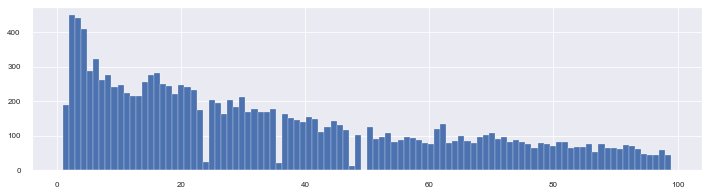

In [188]:
df[(df['num_of_month']>0)&(df['num_of_month']<100)]['num_of_month'].hist(bins=100)

Время владения авто - это некий показатель надежности.
Если срок владения большой (более двух лет) - значит человек ездил на машине и ему было норм.
Если менее двух лет, то тоже норм, но ничего сказать не можем.
А вот если менее трех месяцев - то подозрительно, т.к. мало кто продает авто просто так: срочно или есть косяки, значит стоимость должна быть ниже.
Идея была в том, чтобы сравнить цены на одни и те же модели с длинным и коротким сроком владения. Но пока не смог придумать как это визуализировать. Но в любом случае, нужно этот признак попробовать как отдельный.
Сам по себе заполненный признак владения (если это не автосалон) - показатель надежности продажи. Если сможем вытащить из описания признак продажи от салона, то сделаем заполненный признак владения от частника отдельным признаком.
Пока же просто выделим отдельный категориальный признак Tenure:
-1 = срок владения менее 3 месяцев
0  = нет данных
1  = срок владения более трех месяцев

In [189]:
# надо удалить владение, так как перед тем как над ним применять какиенибудь преобразования надо его заполнить, я заполнить его не представляется возможным так как много пропусков
num_cols.remove('num_of_month')

***Резюме по Владение*** - очень много пропусков. Сделали один отрицательный признак, если авто во владении менее 3 месяцев и два положительных, если более 3 месяцев и более года. Возможно, эти цифры надо подправить.

In [190]:
# записываем признак в список проанализированных признаков
old_len_train, EDA_done_cols = utils.result_EDA_feature('Владение', df[df['Train']==1], df[df['Train']==0], 23, EDA_done_cols, old_len_train)

В результате после EDA признака:= Владение, обработано признаков:= 19, осталось:= 4
Кол-во строк в трейне:=  35801 . Убрали на данном шаге:=  0
Кол-во строк в тесте:=  3837


### 6.20  name

In [191]:
# Значения в трейне
temp_df = df[df['Train']==1]
temp_df['name'].value_counts()

1.6 MT (105 л.с.)                     713
1.8 MT (125 л.с.)                     494
1.6 AT (105 л.с.)                     455
1.6 AT (110 л.с.)                     384
2.3 AT (238 л.с.) 4WD                 334
                                     ... 
Carrera 4 3.4 AMT (350 л.с.) 4WD        1
500 e 3.0hyb AT (333 л.с.) 4WD          1
840d xDrive 3.0d AT (320 л.с.) 4WD      1
2.4 MT (200 л.с.) 4WD                   1
2.0 MT (107 л.с.)                       1
Name: name, Length: 2304, dtype: int64

In [192]:
# Значения в тесте
temp_df = df[df['Train']==0]
temp_df['name']

89378              520d 2.0d AT (190 л.с.)
89379              318d 2.0d AT (150 л.с.)
89380    550i xDrive 4.4 AT (407 л.с.) 4WD
89381           30d 3.0d AT (249 л.с.) 4WD
89382          M50d 3.0d AT (381 л.с.) 4WD
                       ...                
93210               520i 2.0 AT (184 л.с.)
93211           30d 3.0d AT (249 л.с.) 4WD
93212          525xi 2.5 AT (218 л.с.) 4WD
93213    528i xDrive 2.0 AT (245 л.с.) 4WD
93214            50i 4.4 AT (407 л.с.) 4WD
Name: name, Length: 3837, dtype: object

In [193]:
# добавим что-то напоминающее модель в категориальные признаки 
df['model2'] = df['name'].apply(lambda x: str(x).split()[0])
cat_cols.append('model2')
# добавим что-то напоминающее характеристику модели в категориальные признаки 
df['model2_2'] = df['name'].apply(lambda x: str(x).split()[1])
cat_cols.append('model2_2')

***Резюме по name*** - выделили отдельные модели авто, признак категориальный. Добавили новый признак model2 - первое слово до пробела из name. name пока не удаляем из списка нужных приззнаков потому что он потребуется нам при обработке model

In [194]:
# записываем признак в список проанализированных признаков
old_len_train, EDA_done_cols = utils.result_EDA_feature('name', df[df['Train']==1], df[df['Train']==0], 23, EDA_done_cols, old_len_train)

В результате после EDA признака:= name, обработано признаков:= 20, осталось:= 3
Кол-во строк в трейне:=  35801 . Убрали на данном шаге:=  0
Кол-во строк в тесте:=  3837


### 6.21 model

In [195]:
# заполним значения модели по тесту , так как модель определяет класс автомобиля. А класс определяет цену. Сделаем это с помощью CatBoost

# приведем числовые критерии к int64 для CatBoost
for col in ['modelDate', 'productionDate', 'engineDisplacement2']:
    df[col] = df[col].astype('int64')

In [196]:
# позволяет закрепить random_state во всей ячейке исполнения
np.random.seed(42)

le = LabelEncoder()

le.fit(df['bodyType'])
df['bodyType_'] = le.transform(df['bodyType'])

le.fit(df['name'])
df['name_'] = le.transform(df['name'])

le.fit(df['model2'])
df['model2_'] = le.transform(df['model2'])

le.fit(df['model2_2'])
df['model2_2_'] = le.transform(df['model2_2'])

le.fit(df['Привод'])
df['Привод_'] = le.transform(df['Привод'])

le.fit(df['fuelType'])
df['fuelType_'] = le.transform(df['fuelType'])

le.fit(df['vehicleTransmission'])
df['vehicleTransmission_'] = le.transform(df['vehicleTransmission'])

le.fit( df[df['Train']==1]['model'])
df.loc[df['Train']==1, 'model_'] = le.transform(df[df['Train']==1]['model'])

In [197]:
# выведем соответсвия номеров в model_ и моделей БМВ
temp_train = df[(df['Train']==1) & (df['brand']=='BMW')]
list_model = list(temp_train.model_.unique())
for i in list_model:
    print(i, '==', temp_train[temp_train['model_']==i].model.values[0])

2.0 == 1ER
245.0 == M1
7.0 == 2ER
6.0 == 2ACTIVETOURER
13.0 == 3ER
15.0 == 4
20.0 == 5ER
23.0 == 6ER
27.0 == 7ER
30.0 == 8ER
209.0 == I3
210.0 == I8
246.0 == M2
247.0 == M3
248.0 == M4
249.0 == M5
250.0 == M6
410.0 == X1
411.0 == X2
412.0 == X3
413.0 == X4
414.0 == X5
415.0 == X5_M
416.0 == X6
417.0 == X6_M
418.0 == X7
439.0 == Z1
440.0 == Z3
441.0 == Z3M
442.0 == Z4


In [198]:
# создаем список признаков для CatBoost
cols_for_CatBoost = ['bodyType_', 'name_', 'model2_', 'model2_2_', 'modelDate', 'engineDisplacement2', 'Привод_', 'fuelType_', 'enginePower', 'vehicleTransmission_']

In [199]:
temp_train = df[(df['Train']==1) & (df['brand']=='BMW')]
temp_test = df[(df['Train']==0)]
train_data = temp_train[cols_for_CatBoost] # обучающая выборка
train_labels = temp_train['model_'] # метки принадлежности к классу
test_data = temp_test[cols_for_CatBoost] # тестовая выборка

model = CatBoostClassifier(iterations=50, learning_rate = 0.5, random_state=RANDOM_SEED) # классификатор
model.fit(train_data, train_labels) # обучение классификатора
prediction = model.predict(test_data) # передача тестовой выборки в модель
print(*list(prediction[:10])) # вывод результата "предсказания"

0:	learn: 1.2125625	total: 146ms	remaining: 7.15s
1:	learn: 1.4764947	total: 211ms	remaining: 5.06s
2:	learn: 1.0448103	total: 273ms	remaining: 4.27s
3:	learn: 0.5596550	total: 336ms	remaining: 3.86s
4:	learn: 0.3877922	total: 410ms	remaining: 3.69s
5:	learn: 0.3417192	total: 473ms	remaining: 3.47s
6:	learn: 0.3135431	total: 533ms	remaining: 3.27s
7:	learn: 0.2704794	total: 601ms	remaining: 3.16s
8:	learn: 0.2461714	total: 666ms	remaining: 3.03s
9:	learn: 0.2325654	total: 735ms	remaining: 2.94s
10:	learn: 0.2017442	total: 801ms	remaining: 2.84s
11:	learn: 0.1905056	total: 859ms	remaining: 2.72s
12:	learn: 0.1775517	total: 921ms	remaining: 2.62s
13:	learn: 0.1710551	total: 994ms	remaining: 2.56s
14:	learn: 0.1660887	total: 1.06s	remaining: 2.48s
15:	learn: 0.1432457	total: 1.12s	remaining: 2.39s
16:	learn: 0.1377974	total: 1.19s	remaining: 2.31s
17:	learn: 0.1353145	total: 1.25s	remaining: 2.23s
18:	learn: 0.1138905	total: 1.31s	remaining: 2.15s
19:	learn: 0.1104990	total: 1.41s	remaini

In [200]:
# проверим первые 10 элементов теста
temp_test[['brand','bodyType', 'name', 'model', 'model2', 'modelDate', 'engineDisplacement2', 'Привод', 'fuelType', 'enginePower', 'vehicleTransmission']][:10]

brand           bodyType                               name model  \
89378   BMW              седан            520d 2.0d AT (190 л.с.)   NaN   
89379   BMW              седан            318d 2.0d AT (150 л.с.)   NaN   
89380   BMW              седан  550i xDrive 4.4 AT (407 л.с.) 4WD   NaN   
89381   BMW  внедорожник 5 дв.         30d 3.0d AT (249 л.с.) 4WD   NaN   
89382   BMW  внедорожник 5 дв.        M50d 3.0d AT (381 л.с.) 4WD   NaN   
89383   BMW  внедорожник 5 дв.         30d 3.0d AT (249 л.с.) 4WD   NaN   
89384   BMW  внедорожник 5 дв.   28i xDrive 2.0 AT (245 л.с.) 4WD   NaN   
89385   BMW  внедорожник 5 дв.         20d 2.0d AT (177 л.с.) 4WD   NaN   
89386   BMW  внедорожник 5 дв.         30d 3.0d AT (245 л.с.) 4WD   NaN   
89387   BMW              седан             520i 2.0 AT (184 л.с.)   NaN   

      model2  modelDate  engineDisplacement2  Привод fuelType  enginePower  \
89378   520d       2016                 2000  задний   дизель          190   
89379   318d       2018                 2000  задний   дизель          150   
89380   550i       2009                 4400  полный   бензин          407   
89381    30d       2014                 3000  полный   дизель          249   
89382   M50d       2014                 3000  полный   дизель          381   
89383    30d       2013                 3000  полный   дизель          249   
89384    28i       2010                 2000  полный   бензин          245   
89385    20d       2006                 2000  полный   дизель          177   
89386    30d       2010                 3000  полный   дизель          245   
89387   520i       2013                 2000  задний   бензин          184   

      vehicleTransmission  
89378      автоматическая  
89379      автоматическая  
89380      автоматическая  
89381      автоматическая  
89382      автоматическая  
89383      автоматическая  
89384      автоматическая  
89385      автоматическая  
89386      автоматическая  
89387      автоматическая

In [201]:
# выведем соотстсвующие номера после проверки
print(*[20, 13, 20, 416, 414, 416, 412, 410, 412, 20])

20 13 20 416 414 416 412 410 412 20


In [202]:
print(*list(prediction[:10])) # вывод результата "предсказания"

[20.] [13.] [20.] [416.] [416.] [414.] [412.] [412.] [414.] [20.]


авто с параметрами 30d 3.0d AT (249 л.с.) 4WD соответвуют X1, X3, X5, X6 и различие есть только по годам выпуска. Так что CatBoost успешно справился с задачей заполним модели по тесту

In [203]:
df.loc[df['Train']==0, 'model_']=prediction

In [204]:
# больше name нам не нужно удалим его
cat_cols.remove('name')
# также удалим model потому что теперьу нас есть числовой признак модели model_
cat_cols.remove('model')
# добавим новый признак
cat_cols.append('model_')

In [205]:
# сохраним список номеров всех моделей BMW
list_all_num_model_BMW = df[df['brand']=='BMW'].model_.unique()

In [206]:
# проверим пропуски
df['model_'].isna().sum()

0

***Резюме по model *** - категориальный признак, заполнен по тесту с помощью Catboost. Результат записан в новый признак model_. Пропусков нет. Всего 443 значения моделей в признаке.

In [207]:
# записываем признак в список проанализированных признаков
old_len_train, EDA_done_cols = utils.result_EDA_feature('model', df[df['Train']==1], df[df['Train']==0], 23, EDA_done_cols, old_len_train)

В результате после EDA признака:= model, обработано признаков:= 21, осталось:= 2
Кол-во строк в трейне:=  35801 . Убрали на данном шаге:=  0
Кол-во строк в тесте:=  3837


### 6.22 start_date

In [208]:
# удалим start_date потому что не понятно как его обработать
time_cols.remove('start_date')

In [209]:
# записываем признак в список проанализированных признаков
old_len_train, EDA_done_cols = utils.result_EDA_feature('start_date', df[df['Train']==1], df[df['Train']==0], 23, EDA_done_cols, old_len_train)

В результате после EDA признака:= start_date, обработано признаков:= 22, осталось:= 1
Кол-во строк в трейне:=  35801 . Убрали на данном шаге:=  0
Кол-во строк в тесте:=  3837


### 6.23 color

In [210]:
# Значения в трейне
temp_df = df[df['Train']==1]
temp_df['color'].value_counts()

чёрный         11768
белый           5535
серебристый     4269
серый           4031
синий           3584
красный         1652
коричневый      1537
зелёный         1015
бежевый          624
голубой          526
золотистый       333
пурпурный        300
фиолетовый       247
жёлтый           214
оранжевый        155
розовый           11
Name: color, dtype: int64

In [211]:
# Значения в трейне
temp_df = df[df['Train']==0]
temp_df['color'].value_counts()

чёрный         1395
белый           767
синий           510
серый           453
коричневый      216
серебристый     191
красный         115
бежевый          46
голубой          35
зелёный          33
оранжевый        27
золотистый       23
пурпурный        20
фиолетовый        5
жёлтый            1
Name: color, dtype: int64

***Резюме по color*** - категориальный признак, 16 значений, в тесте 15. пропусков нет

In [212]:
# записываем признак в список проанализированных признаков
EDA_done_cols.append('color')
old_len_train, EDA_done_cols = utils.result_EDA_feature('', df[df['Train']==1], df[df['Train']==0], 23, EDA_done_cols, old_len_train)

В результате после EDA признака:= , обработано признаков:= 24, осталось:= -1
Кол-во строк в трейне:=  35801 . Убрали на данном шаге:=  0
Кол-во строк в тесте:=  3837


### 7. Сохранение датасета после EDA 
---
датасет сохраняется на локальной машине, чтобы потом не было необходимости заново запускать ячейки ноутбука 

In [213]:
# сохраняем все переменные из списков
all_cols_df2 =cat_cols+num_cols+time_cols+servis_cols+bin_cols+target_col

In [214]:
# образаем исходный датасет только переменными, которые мы решили оставить
df2 = df.loc[:, all_cols_df2].copy()
utils.describe_without_plots_all_collumns(df2, short=True)

имя признака      тип # значений # пропусков(NaN) # уникальных  \
0                  bodyType   object      39638                0           11   
1                     brand   object      39638                0           22   
2                     color   object      39638                0           16   
3                  fuelType   object      39638                0            4   
4       vehicleTransmission   object      39638                0            3   
5                    Привод   object      39638                0            3   
6                       ПТС   object      39638                0            3   
7                    model2   object      39638                0          344   
8                  model2_2   object      39638                0          102   
9                    model_  float64      39638                0          443   
10                  mileage    int64      39638                0        10381   
11                modelDate    int64      39638                0           44   
12           productionDate    int64      39638                0           39   
13              enginePower    int64      39638                0          299   
14      engineDisplacement2    int64      39638                0           50   
15  engineDisplacement2_log  float64      39638                0           50   
16            numberOfDoors    int64      39638                0            4   
17                Владельцы    int64      39638                0            4   
18                intensity  float64      39638                0        13420   
19        dateModelProdDiff  float64      39638                0           20   
20            count_words_d    int64      39638                0          794   
21                 mean_c_w  float64      39638                0         1258   
22                  sum_c_w    int64      39638                0          723   
23                    Train    int64      39638                0            2   
24                       id  float64       3837            35801         3837   
25                   rarity     bool      39638                0            2   
26          pDate_more_2015     bool      39638                0            2   
27          pDate_more_2005     bool      39638                0            2   
28          pDate_more_1990     bool      39638                0            2   
29          pDate_less_1990     bool      39638                0            2   
30                 c_p_des1    int64      39638                0            2   
31               m_s_w_des2    int64      39638                0            2   
32               r_l_s_des3    int64      39638                0            2   
33                 abs_des4    int64      39638                0            2   
34                 c_c_des5    int64      39638                0            2   
35                 a_w_des6    int64      39638                0            2   
36               r_v_c_des7    int64      39638                0            2   
37                    price  float64      35801             3837         3001   
38                price_log  float64      35801             3837         3001   

    минимум      среднее        макс      медиана  
0       NaN          NaN         NaN          NaN  
1       NaN          NaN         NaN          NaN  
2       NaN          NaN         NaN          NaN  
3       NaN          NaN         NaN          NaN  
4       NaN          NaN         NaN          NaN  
5       NaN          NaN         NaN          NaN  
6       NaN          NaN         NaN          NaN  
7       NaN          NaN         NaN          NaN  
8       NaN          NaN         NaN          NaN  
9         0      201.327         442          190  
10        0       155728       1e+06       149662  
11     1975      2007.46        2019         2008  
12     1981       2009.5        2019         2010  
13       90       201.87         625          

In [215]:
# # этот блок закомментирован потому что используется один раз при сохранении датасета
# # сохранение датасета и названий столбцов, чтобы потом его заново не генерить
# df2.to_csv(PATH_to_file+'df3_v3.csv', index=False)

In [225]:
# # этот блок закомментирован потому что используется один раз при сохранении списков
# # также сохраняем названия столбцов по типам
# df_cols = pd.DataFrame()
# df_cols['cat_cols']=[','.join(cat_cols)]
# df_cols['num_cols']=[','.join(num_cols)]
# df_cols['servis_cols']=[','.join(servis_cols)]
# df_cols['bin_cols']=[','.join(bin_cols)]
# df_cols['target_col']=[','.join(target_col)]
# df_cols['list_all_num_model_BMW']=[','.join(list(map(str,list(list_all_num_model_BMW))))]
# df_cols.to_csv(PATH_to_file+'df3_v3_cols.csv', index=False)

In [7]:
# это блок закомментирован и требуется для закачивания готового датасета

df3 = pd.read_csv(PATH_to_file+'df3_v3.csv')
df_test = pd.read_csv(PATH_to_file+'test.csv')
df_submit = pd.read_csv(PATH_to_file+'sample_submission.csv')
pd.set_option('display.max_columns', None)
print('Размерность тренировочного датасета: ', df3.shape)
display(df3.head(2))
print('Размерность тестового датасета: ', df_test.shape)
display(df_test.head(2))
print('Размерность датасета c примером сабмишена: ', df_submit.shape)
display(df_submit.head(2))

Размерность тренировочного датасета:  (39638, 39)


bodyType brand    color fuelType vehicleTransmission    Привод       ПТС  \
0    седан  AUDI   чёрный   бензин        механическая    полный  Оригинал   
1    седан  AUDI  красный   бензин        механическая  передний  Оригинал   

  model2 model2_2  model_  mileage  modelDate  productionDate  enginePower  \
0    2.8       MT     0.0   350000       1990            1991          174   
1    1.8       MT     0.0   173424       1982            1986           90   

   engineDisplacement2  engineDisplacement2_log  numberOfDoors  Владельцы  \
0                 2800                 7.937732              4          3   
1                 1800                 7.496097              4          3   

      intensity  dateModelProdDiff  count_words_d  mean_c_w  sum_c_w  Train  \
0  12068.965517                1.0             32  0.000361       30      1   
1   5100.705882                4.0             21  0.000217       18      1   

   id  rarity  pDate_more_2015  pDate_more_2005  pDate_more_1990  \
0 NaN   False            False            False             True   
1 NaN   False            False            False            False   

   pDate_less_1990  c_p_des1  m_s_w_des2  r_l_s_des3  abs_des4  c_c_des5  \
0            False         0           0           0         0         0   
1             True         0           0           0         0         0   

   a_w_des6  r_v_c_des7     price  price_log  
0         0           0  200000.0  12.206073  
1         0           0   60000.0  11.002100

Размерность тестового датасета:  (3837, 23)


bodyType brand   color fuelType  modelDate                     name  \
0    седан   BMW  чёрный   дизель     2016.0  520d 2.0d AT (190 л.с.)   
1    седан   BMW   белый   дизель     2018.0  318d 2.0d AT (150 л.с.)   

   numberOfDoors  productionDate vehicleConfiguration vehicleTransmission  \
0            4.0          2017.0  SEDAN AUTOMATIC 2.0      автоматическая   
1            4.0          2019.0  SEDAN AUTOMATIC 2.0      автоматическая   

  engineDisplacement enginePower  \
0            2.0 LTR     190 N12   
1            2.0 LTR     150 N12   

                                         description   mileage  \
0  В РОЛЬФ Ясенево представлено более 500 автомоб...  158836.0   
1  Автомобиль из демонстрационного парка по спец ...      10.0   

                                        Комплектация  Привод   Руль  \
0  ['[{"name":"Безопасность","values":["Антипробу...  задний  Левый   
1  ['[{"name":"Комфорт","values":["Круиз-контроль...  задний  Левый   

            Состояние   Владельцы       ПТС     Таможня Владение  id  
0  Не требует ремонта  1 владелец  Оригинал  Растаможен      NaN   0  
1  Не требует ремонта  1 владелец  Оригинал  Растаможен      NaN   1

Размерность датасета c примером сабмишена:  (3837, 2)


id      price
0   0  5299000.0
1   1  1580000.0

In [8]:
df3_cols= pd.read_csv(PATH_to_file+'df3_v3_cols.csv')
cat_cols=df3_cols['cat_cols'][0].split(',')
num_cols = df3_cols['num_cols'][0].split(',')
servis_cols = df3_cols['servis_cols'][0].split(',')
bin_cols = df3_cols['bin_cols'][0].split(',')
target_col= df3_cols['target_col'][0].split(',')
list_all_num_model_BMW = df3_cols['list_all_num_model_BMW'][0].split(',')

### 8. Перекрестный анализ между переменными и целевой переменной price
---
#### 8.1 Оценка корреляций

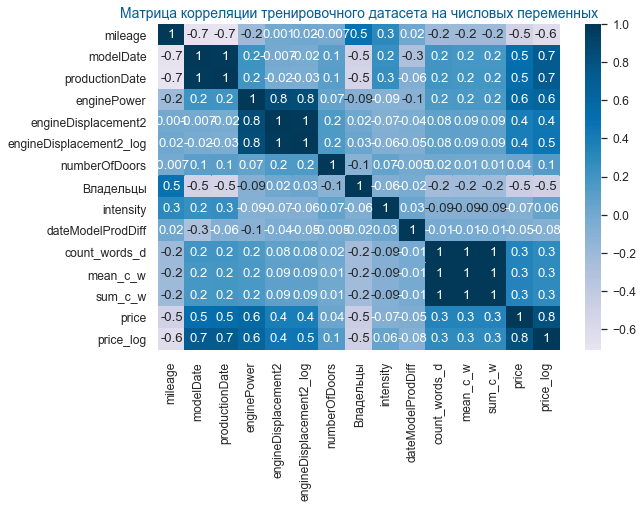

In [231]:
utils.simple_heatmap('Матрица корреляции тренировочного датасета на числовых переменных',df3[df3['Train']==1], num_cols+target_col, 1.1, 1, 9)

***Выводы по матрице корелляции по всем маркам***: - c таргетом выше всего скоррелированы (по убыванию):
- modelDate (дата выхода модели)
- productionDate (дата производства)
- mileage (пробег)
- enginePower(мощность авто л.с.)
- engineDisplacement2_log (логарифм от объема двигателя)
- engineDisplacement2 (объем двигателя)
- Владельцы (кол-во)
- count_words_d, mean_c_w, sum_c_w (это данные из description кол-во слов всего, среднее и сумма не пересекающ.) 

и замыкают список интенсивность использования авто и разница в датах между выпуском и производством

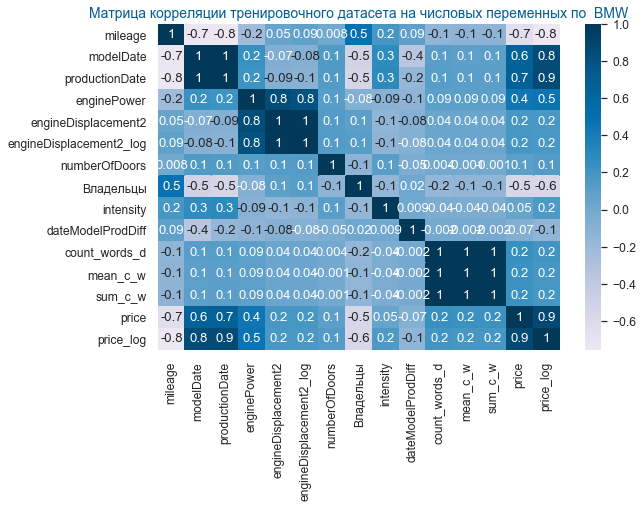

In [232]:
temp_df = df3[(df3['Train']==1) & (df3['brand']=='BMW')]
utils.simple_heatmap('Матрица корреляции тренировочного датасета на числовых переменных по  BMW',temp_df, num_cols+target_col, 1.1, 1, 9)

***Выводы по матрице корелляции ТОЛЬКО по BMW***: 
- c таргетом выше всего скоррелированы (по убыванию) :
- productionDate (дата производства)
- modelDate (дата выхода модели)
- mileage (пробег)
- Владельцы (кол-во)
- enginePower(мощность авто л.с.)
- engineDisplacement2_log (логарифм от объема двигателя), engineDisplacement2 (объем двигателя), count_words_d, mean_c_w, sum_c_w (это данные из description кол-во слов всего, среднее и сумма не пересекающ.) - примерно на одном уровне  
и замыкает список разница в датах между выпуском и производством  

Другие выводы:
- кореляция с таргетом enginePower(мощность авто л.с.) по BMW ниже чем по всем маркам
- кореляция с таргетом интенсивность использования авто и разница в датах между выпуском и производством выше на порядки, чем по всем маркам

***Выводы из матрицы корреляции ОБЩИЕ***:
- между собой высокоскоррелированны признаки:
  - modelDate (дата выхода модели), productionDate (дата производства), mileage (пробег). Владельцы (кол-во)
  - count_words_d, mean_c_w, sum_c_w (это данные из description кол-во слов всего, среднее и сумма не пересекающ.)
  - enginePower(мощность авто л.с.), engineDisplacement2_log (логарифм от объема двигателя) и engineDisplacement2 (объем двигателя)  
  
На текущем этапе мы пока не будем делать выводов об исключении признаков, а просто примем ко вниманию эту информацию

#### 8.2 Значимость непрерывных переменных по ANOVA F test

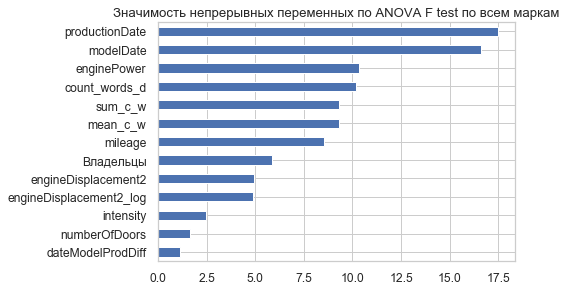

In [233]:
temp_df = df3[df3['Train']==1]
imp_num = pd.Series(f_classif(temp_df[num_cols], temp_df['price_log'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh', title='Значимость непрерывных переменных по ANOVA F test по всем маркам')

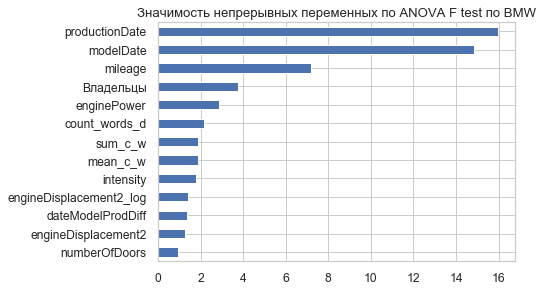

In [234]:
temp_df = df3[(df3['Train']==1) & (df3['brand']=='BMW')]
imp_num = pd.Series(f_classif(temp_df[num_cols], temp_df['price_log'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh', title='Значимость непрерывных переменных по ANOVA F test по BMW')

***Выводы:*** 
- значимость тройки признаков - count_words_d, mean_c_w, sum_c_w (это данные из description кол-во слов всего, среднее и сумма не пересекающ.) снижается на BMW и приходит к уровню productionDate (дата производства) и modelDate (дата выхода модели
- значимость engineDisplacement2 (объем двигателя) падает на авто БМВ
- значимость интенсивность использования авто и разница в датах между выпуском не вырастает на БМВ, а за счет падения значимости остальных приходит в норму на БМВ

#### 8.3 Проверим статистическую значимость по всем не числовым признакам по тесту Стьюдента

In [9]:
# переведем категориальные признаки в dummies переменные
# но сначала сохраним список переменных чтобы можно было сделать список добавленных
list_cols_bef_dumm = list(df3.columns)

# а также мы хотим преобразовать числовые признаки 'Владельцы' и 'engineDisplacement2'
# поэтому сохраним их дубликаты
arr_Владельцы = np.array(df3['Владельцы'])

# преобразуем переменные в дамми переменные
df3 = pd.get_dummies(df3, columns = ['bodyType', 'brand', 'color', 'fuelType', 'vehicleTransmission', 'Привод', 'Владельцы', 'ПТС', 'model_', 'engineDisplacement2'])

# вернем владельцев
df3['Владельцы'] = arr_Владельцы 

# теперь создадим список дамми переменных
list_cols_aft_dumm = list(df3.columns)
dumm_cols= list(set(list_cols_aft_dumm)-set(list_cols_bef_dumm ))

In [10]:
print(f'Мы добавили:{len(dumm_cols)} dummies featuries')

Мы добавили:559 dummies featuries


In [11]:
# удалим 'engineDisplacement2' из числовых признаков - они нам больше не понадобятся
num_cols.remove('engineDisplacement2')

# а также удалим категориальные признаки преобразованные в dummies их уже нет
drop_list_cols = ['bodyType', 'brand', 'color', 'fuelType', 'vehicleTransmission', 'Привод', 'ПТС', 'model_']
for col in drop_list_cols:
    cat_cols.remove(col)

In [12]:
# Проверим, есть ли статистическая разница в распределении оценок по всем категориальным признакам, 
# с помощью теста Стьюдента. Проверим нулевую гипотезу о том, 
# что распределения price_log по различным параметрам неразличимы:
def get_stat_dif(d_column, d_df):
    cols = d_df.loc[:, d_column].value_counts().index[:]
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        ttest = ttest_ind(d_df.loc[d_df.loc[:, d_column] == comb[0], 'price_log'].dropna(),
                          d_df.loc[d_df.loc[:, d_column] == comb[1], 'price_log'].dropna()).pvalue
        if  ttest<= 0.05/len(combinations_all): # Учли поправку Бонферони
            return(d_column)
            break

In [13]:
stat_sign_diff_cols=[]

temp_df = df3[(df3['Train']==1)]
for col in bin_cols+dumm_cols:
    stat_sign_diff_cols.append(get_stat_dif(col,temp_df))
stat_sign_diff_cols = list(filter(None, stat_sign_diff_cols))

In [14]:
not_stat_sign_diff_cols=list(set(bin_cols+dumm_cols) - set(stat_sign_diff_cols))
print(f'по тесту Стьюдента {len(not_stat_sign_diff_cols)} признаков из {len(bin_cols+dumm_cols)} бинарных и dummies признаков НЕ СОДЕРЖАТ СТАТИСТИЧЕСКИ ЗНАЧИМЫХ РАЗЛИЧИЙ с таргетом')
print('вот они:= ', *sorted(not_stat_sign_diff_cols))

по тесту Стьюдента 188 признаков из 571 бинарных и dummies признаков НЕ СОДЕРЖАТ СТАТИСТИЧЕСКИ ЗНАЧИМЫХ РАЗЛИЧИЙ с таргетом
вот они:=  bodyType_седан 2 дв. brand_MINI engineDisplacement2_1300 engineDisplacement2_2500 engineDisplacement2_3400 engineDisplacement2_3900 engineDisplacement2_4200 engineDisplacement2_4900 engineDisplacement2_5300 engineDisplacement2_6600 model__1.0 model__103.0 model__104.0 model__105.0 model__109.0 model__112.0 model__113.0 model__114.0 model__115.0 model__116.0 model__118.0 model__119.0 model__12.0 model__120.0 model__122.0 model__123.0 model__124.0 model__128.0 model__13.0 model__132.0 model__133.0 model__136.0 model__139.0 model__14.0 model__140.0 model__141.0 model__142.0 model__143.0 model__148.0 model__150.0 model__151.0 model__157.0 model__158.0 model__16.0 model__160.0 model__164.0 model__165.0 model__166.0 model__169.0 model__170.0 model__172.0 model__176.0 model__179.0 model__18.0 model__19.0 model__193.0 model__195.0 model__196.0 model__198.0 mode

***Резюме*** 
- brand - MINI можно удалить
- про bodyType_седан 2 дв мы помним там два раритетных авто, которые нам нужны (потому что что? правильно тип метрики в задаче такой, что нам нужно угадать всех особенно с низкими ценами иначе нас покарает MAPE)
- про объемы мы тоже помним - во впервых мы их обрезали снизу и сверху по БМВ. Но так как у гибридов минимальный объем двига 700 кубиков поэтому наверняка между гибридами и обычными авто остались объемы которые не делают погоды, но мы их пока трагать не будем
- проанализируем модели и избавимся от статистически не значимых не БМВ

In [15]:
dumm_cols.remove('brand_MINI')
df3 = df3[df3['brand_MINI']!=1]

In [16]:
check_list_model = [x for x in sorted(not_stat_sign_diff_cols) if 'model' in x]
print(f'всего моделей на проверку на удаление:= {len(check_list_model)}')

всего моделей на проверку на удаление:= 178


In [17]:
# ранее мы сохранили список всех номеров моделей БМВ
print(*list_all_num_model_BMW)

2.0 245.0 7.0 6.0 13.0 15.0 20.0 23.0 27.0 30.0 209.0 210.0 246.0 247.0 248.0 249.0 250.0 410.0 411.0 412.0 413.0 414.0 415.0 416.0 417.0 418.0 439.0 440.0 441.0 442.0


In [18]:
check_list_model_BMW = ['model__'+ str(x) for x in list_all_num_model_BMW]
print(*check_list_model_BMW)

model__2.0 model__245.0 model__7.0 model__6.0 model__13.0 model__15.0 model__20.0 model__23.0 model__27.0 model__30.0 model__209.0 model__210.0 model__246.0 model__247.0 model__248.0 model__249.0 model__250.0 model__410.0 model__411.0 model__412.0 model__413.0 model__414.0 model__415.0 model__416.0 model__417.0 model__418.0 model__439.0 model__440.0 model__441.0 model__442.0


In [19]:
fin_drop_list_model = list(set(check_list_model)-set(check_list_model_BMW))
print(f'всего удаляем моделей после проверки:= {len(fin_drop_list_model)}')

всего удаляем моделей после проверки:= 171


In [20]:
for col in fin_drop_list_model:
    dumm_cols.remove(col)
    df3 = df3[df3[col]!=1]

### 8.4 Проверим важность признаков с помощью случайного леса и отсечки по белому шуму
---
#### 8.4.1 Разбиваем датасет на тренировочный и валидационный (валидационный формирем похожим на тестовый по типу топлива и по датам выпуска)

In [21]:
# сколько в трейне
len(df3[df3['Train']==1])

32021

In [22]:
# посмотрим сколько осталось авто БМВ в трейне
len(df3[(df3['Train']==1) & (df3['brand_BMW']==1)])

4491

In [23]:
# сколько в тесте
len(df3[df3['Train']==0])

3837

Даже если бы мы делали прогноз цен по метрике MAPE 3837 авто из теста только по 4491 BMW из трейна, то этого было бы достаточно чтобы сделать оценку MAPE c точностью ниже 6.69 (1 место на лб). Это можно проверить с помощью дверительных интервалов. Так что ничего дополнительно парсить по БМВ с других сайтов не надо.

In [24]:
# псомотрим еще раз на распределение авто бмв в тесте по дате марки
df3[(df3['Train']==0) & (df3['brand_BMW']==1)].productionDate.value_counts(bins=10, normalize=True)

(2011.4, 2015.2]      0.354183
(2015.2, 2019.0]      0.255147
(2007.6, 2011.4]      0.239771
(2003.8, 2007.6]      0.084441
(2000.0, 2003.8]      0.032578
(1996.2, 2000.0]      0.020328
(1992.4, 1996.2]      0.005994
(1988.6, 1992.4]      0.004952
(1980.961, 1984.8]    0.001564
(1984.8, 1988.6]      0.001042
Name: productionDate, dtype: float64

In [25]:
# Сделаем валидационную выборку из 800 авто
temp_ser = df3[(df3['Train']==0) & (df3['brand_BMW']==1)].productionDate.value_counts(bins=10, normalize=True)
temp_list = []
for interval in list(temp_ser.index):
    temp_list.append([interval, int(temp_ser[interval]*800)])
temp_list

[[Interval(2011.4, 2015.2, closed='right'), 283],
 [Interval(2015.2, 2019.0, closed='right'), 204],
 [Interval(2007.6, 2011.4, closed='right'), 191],
 [Interval(2003.8, 2007.6, closed='right'), 67],
 [Interval(2000.0, 2003.8, closed='right'), 26],
 [Interval(1996.2, 2000.0, closed='right'), 16],
 [Interval(1992.4, 1996.2, closed='right'), 4],
 [Interval(1988.6, 1992.4, closed='right'), 3],
 [Interval(1980.961, 1984.8, closed='right'), 1],
 [Interval(1984.8, 1988.6, closed='right'), 0]]

In [26]:
# пронумеруем трейн чтобы убрать из трейна то что попаедет в валидационнную выборку
df3.loc[df3['Train']==1,'id'] = np.array(range(1000000, 1000000+len(df3[df3['Train']==1])))

In [27]:
# позволяет закрепить random_state во всей ячейке исполнения
np.random.seed(42)

df_val = pd.DataFrame()
i = 0
dict_id_val = {}
for interval in temp_list:
    df_sample = df3[(df3['Train']==1) & (df3['brand_BMW']==1) & (df3['productionDate'] > interval[0].left) & (df3['productionDate'] <= interval[0].right)].sample(interval[1]).copy()
    dict_id_val[i]=list(df_sample.id.unique())
    df_val = pd.concat([df_val, df_sample])
    i += 1
len(df_val)

795

In [28]:
# визуальный контроль
df_val.head(2)

model2 model2_2  mileage  modelDate  productionDate  enginePower  \
5662    35i      3.0    83390       2010            2012          306   
3660   535i   xDrive    88000       2009            2012          306   

      engineDisplacement2_log  numberOfDoors  intensity  dateModelProdDiff  \
5662                 8.006701              5   10423.75                2.0   
3660                 8.006701              4   11000.00                3.0   

      count_words_d  mean_c_w  sum_c_w  Train         id  rarity  \
5662             76  0.000807       67      1  1005501.0   False   
3660              9  0.000084        7      1  1003499.0   False   

      pDate_more_2015  pDate_more_2005  pDate_more_1990  pDate_less_1990  \
5662            False             True            False            False   
3660            False             True            False            False   

      c_p_des1  m_s_w_des2  r_l_s_des3  abs_des4  c_c_des5  a_w_des6  \
5662         0           0           0         0         0         0   
3660         0           0           0         0         0         0   

      r_v_c_des7      price  price_log  bodyType_внедорожник 5 дв.  \
5662           0  1500000.0  14.220976                           1   
3660           0  1550000.0  14.253765                           0   

      bodyType_кабриолет  bodyType_компактвэн  bodyType_купе  \
5662                   0                    0              0   
3660                   0                    0              0   

      bodyType_лифтбек  bodyType_родстер  bodyType_седан  \
5662                 0                 0               0   
3660                 0                 0               1   

      bodyType_седан 2 дв.  bodyType_универсал 5 дв.  bodyType_хэтчбек 3 дв.  \
5662                     0                         0                       0   
3660                     0                         0                       0   

      bodyType_хэтчбек 5 дв.  brand_AUDI  brand_BMW  brand_CADILLAC  \
5662                       0           0          1               0   
3660                       0           0          1               0   

      brand_CHRYSLER  brand_FORD  brand_HONDA  brand_INFINITI  brand_JAGUAR  \
5662               0           0            0               0             0   
3660               0           0            0               0             0   

      brand_JEEP  brand_LAND_ROVER  brand_LEXUS  brand_MAZDA  brand_MERCEDES  \
5662           0                 0            0            0               0   
3660           0                 0            0            0               0   

      brand_MINI  brand_NISSAN  brand_PORSCHE  brand_RENAULT  brand_SUBARU  \
5662           0             0              0              0             0   
3660           0             0              0              0             0   

      brand_SUZUKI  brand_TOYOTA  brand_VOLKSWAGEN  brand_VOLVO  \
5662             0             0                 0            0   
3660             0             0                 0            0   

      color_бежевый  color_белый  color_голубой  color_жёлтый  color_зелёный  \
5662              0            0              0             0              0   
3660              0            0              0             0              0   

      color_золотистый  color_коричневый  color_красный  color_оранжевый  \
5662                 0                 0              0                0   
3660                 0                 0              0                0   

      color_пурпурный  color_розовый  color_серебристый  color_серый  \
5662                0              0                  0            0   
3660                0              0                  0            0   

      color_синий  color_фиолетовый  color_чёрный  fuelType_бензин  \
5662            0                 0             1                1   
3660            0                 0             1                1   

      fuelType_гибрид  fuelType_дизель  fuelT

In [29]:
df_train = df3[df3['Train']==1].copy()
# сделаем трейн без авто в валидационной выборке
for elem in dict_id_val:
    df_train = df_train[~df_train['id'].isin(dict_id_val[elem])]
len(df_train)

31226

In [30]:
# проверка сумма длин трайна и валидации = первоначальному трейну
len(df_train)+len(df_val) == len(df3[df3['Train']==1])

True

In [31]:
# проверим распределение по типу топлива, чтобы убедиться что у нас в валидации доставточно гибридов и электрокаров
dumm_fuelType_cols = [x for x in dumm_cols if 'fuelType' in x]

print('Распределение fuelType в валидации:')
for col in dumm_fuelType_cols:
    print(col, ':=', int(len(df_val[df_val[col]==1])/len(df_val)*10000)/100, '%')

Распределение fuelType в валидации:
fuelType_бензин := 67.54 %
fuelType_дизель := 31.94 %
fuelType_электро := 0.25 %
fuelType_гибрид := 0.25 %


In [32]:
# проверим распределение по типу топлива, чтобы убедиться что у нас в валидации доставточно гибридов и электрокаров
dumm_fuelType_cols = [x for x in dumm_cols if 'fuelType' in x]
temp_df = df3[df3['Train']==0]
print('Распределение fuelType в тесте:')
for col in dumm_fuelType_cols:
    print(col, ':=', int(len(temp_df[temp_df[col]==1])/len(temp_df)*100000)/1000, '%')

Распределение fuelType в тесте:
fuelType_бензин := 64.399 %
fuelType_дизель := 35.392 %
fuelType_электро := 0.026 %
fuelType_гибрид := 0.182 %


***Резюме*** Совсем уж так неполучится добавить, потому что добавление 1 авто к 795 это 0.1256%.У нас сейчас два электро и 2 гибрида. Поэтому удалим один электрокар, добавим 5 гибридов, чтобы отношение между гибридами и электрокарами 0.182/0.026 = 7 сохранилось. 

In [33]:
# поммотрим какие электрокары в валидации
df_val[df_val['fuelType_электро']==1]

model2 model2_2  mileage  modelDate  productionDate  enginePower  \
4742  Electro       AT    89942       2013            2014          170   
4755  Electro       AT    39500       2017            2017          170   

      engineDisplacement2_log  numberOfDoors     intensity  dateModelProdDiff  \
4742                 6.552508              5  14990.333333                1.0   
4755                 6.552508              5  13166.666667                0.0   

      count_words_d  mean_c_w  sum_c_w  Train         id  rarity  \
4742            128  0.001408      117      1  1004581.0   False   
4755            638  0.006296      523      1  1004594.0   False   

      pDate_more_2015  pDate_more_2005  pDate_more_1990  pDate_less_1990  \
4742            False             True            False            False   
4755             True            False            False            False   

      c_p_des1  m_s_w_des2  r_l_s_des3  abs_des4  c_c_des5  a_w_des6  \
4742         0           0           0         0         0         0   
4755         0           0           1         1         1         1   

      r_v_c_des7      price  price_log  bodyType_внедорожник 5 дв.  \
4742           0  1430000.0  14.173185                           0   
4755           0  2385286.0  14.684830                           0   

      bodyType_кабриолет  bodyType_компактвэн  bodyType_купе  \
4742                   0                    0              0   
4755                   0                    0              0   

      bodyType_лифтбек  bodyType_родстер  bodyType_седан  \
4742                 0                 0               0   
4755                 0                 0               0   

      bodyType_седан 2 дв.  bodyType_универсал 5 дв.  bodyType_хэтчбек 3 дв.  \
4742                     0                         0                       0   
4755                     0                         0                       0   

      bodyType_хэтчбек 5 дв.  brand_AUDI  brand_BMW  brand_CADILLAC  \
4742                       1           0          1               0   
4755                       1           0          1               0   

      brand_CHRYSLER  brand_FORD  brand_HONDA  brand_INFINITI  brand_JAGUAR  \
4742               0           0            0               0             0   
4755               0           0            0               0             0   

      brand_JEEP  brand_LAND_ROVER  brand_LEXUS  brand_MAZDA  brand_MERCEDES  \
4742           0                 0            0            0               0   
4755           0                 0            0            0               0   

      brand_MINI  brand_NISSAN  brand_PORSCHE  brand_RENAULT  brand_SUBARU  \
4742           0             0              0              0             0   
4755           0             0              0              0             0   

      brand_SUZUKI  brand_TOYOTA  brand_VOLKSWAGEN  brand_VOLVO  \
4742             0             0                 0            0   
4755             0             0                 0            0   

      color_бежевый  color_белый  color_голубой  color_жёлтый  color_зелёный  \
4742              0            0              0             0              0   
4755              0            0              0             0              0   

      color_золотистый  color_коричневый  color_красный  color_оранжевый  \
4742                 0                 0              0                0   
4755                 0                 0              0                0   

      color_пурпурный  color_розовый  color_серебристый  color_серый  \
4742                0              0                  1            0   
4755                0              0                  0            0   

      color_синий  color_фиолетовый  color_чёрный  fuelType_бензин  \
4742            0                 0             0                0   
4755            0                 0             1                0   

      fuelType_гибрид  fuelType_

In [34]:
# удаляем электрокар 2017 года так как этот интервал шире в тесте (см.выше)
# сначала добавляем в трейн
df_train = pd.concat([df_train,df_val[df_val['id']==1004755.0]])

# потом удаляем в валидации
df_val = df_val[df_val['id']!=1004755.0]

In [35]:
# позволяет закрепить random_state во всей ячейке исполнения
np.random.seed(42)

# добавляем в валидацию 5 гибридов БМВ
df_sample = df_train[(df_train['brand_BMW']==1) & (df_train['fuelType_гибрид']==1)].sample(5).copy()
df_val = pd.concat([df_val, df_sample])

df_train = df_train[~df_train['id'].isin(list(df_sample.id.unique()))]

In [36]:
# проверка сумма длин трайна и валидации = первоначальному трейну
len(df_train)+len(df_val) == len(df3[df3['Train']==1])

True

#### 8.4.2 Подготовка данных к машинному обучению

In [37]:
# сохраняем все переменные из списков которые находятся в работе кроме дамми
all_cols_df4 =cat_cols+num_cols+servis_cols+bin_cols+target_col
# образаем исходный датасет только переменными, которые мы решили оставить
df4 = df_train.loc[:, all_cols_df4].copy()
utils.describe_without_plots_all_collumns(df4, short=True)

имя признака      тип # значений # пропусков(NaN) # уникальных  \
0                    model2   object      31222                0          282   
1                  model2_2   object      31222                0           91   
2                   mileage    int64      31222                0         8140   
3                 modelDate    int64      31222                0           44   
4            productionDate    int64      31222                0           39   
5               enginePower    int64      31222                0          275   
6   engineDisplacement2_log  float64      31222                0           48   
7             numberOfDoors    int64      31222                0            4   
8                 Владельцы    int64      31222                0            4   
9                 intensity  float64      31222                0        10888   
10        dateModelProdDiff  float64      31222                0           20   
11            count_words_d    int64      31222                0          729   
12                 mean_c_w  float64      31222                0          995   
13                  sum_c_w    int64      31222                0          667   
14                    Train    int64      31222                0            1   
15                       id  float64      31222                0        31222   
16                   rarity     bool      31222                0            2   
17          pDate_more_2015     bool      31222                0            2   
18          pDate_more_2005     bool      31222                0            2   
19          pDate_more_1990     bool      31222                0            2   
20          pDate_less_1990     bool      31222                0            2   
21                 c_p_des1    int64      31222                0            2   
22               m_s_w_des2    int64      31222                0            2   
23               r_l_s_des3    int64      31222                0            2   
24                 abs_des4    int64      31222                0            2   
25                 c_c_des5    int64      31222                0            2   
26                 a_w_des6    int64      31222                0            2   
27               r_v_c_des7    int64      31222                0            2   
28                    price  float64      31222                0         2842   
29                price_log  float64      31222                0         2842   

    минимум      среднее         макс      медиана  
0       NaN          NaN          NaN          NaN  
1       NaN          NaN          NaN          NaN  
2         0       160003       432000       153983  
3      1975       2007.2         2019         2008  
4      1981      2009.27         2019         2010  
5        90      196.883          625          170  
6   6.55251      7.75659      8.73247       7.6014  
7         2      4.48258            5            5  
8         0      2.25559            3            3  
9         0        16161       147441      15076.9  
10       -1       2.0678           29            2  
11        0      83.9088         4545           46  
12        0  0.000879691    0.0494047  0.000505604  
13        0       73.075         4104           42  
14        1            1            1            1  
15    1e+06  1.01631e+06  1.03202e+06  1.01641e+06  
16      NaN          NaN          NaN          NaN  
17      NaN          NaN          NaN          NaN  
18      NaN          NaN          NaN          NaN  
19      NaN          NaN          NaN          NaN  
20      NaN          NaN          NaN          NaN  
21        0    0.0142848            1            0  
22        0    0.0394594            1            0  
23        0    0.0459932            1            0  
24        0     0.109058            1            0  
25        0    0.0361284            1            0  
26        0     0.123375            1            0  
27        0   0.003

In [38]:
df_train.head(2)

model2 model2_2  mileage  modelDate  productionDate  enginePower  \
0    2.8       MT   350000       1990            1991          174   
1    1.8       MT   173424       1982            1986           90   

   engineDisplacement2_log  numberOfDoors     intensity  dateModelProdDiff  \
0                 7.937732              4  12068.965517                1.0   
1                 7.496097              4   5100.705882                4.0   

   count_words_d  mean_c_w  sum_c_w  Train         id  rarity  \
0             32  0.000361       30      1  1000000.0   False   
1             21  0.000217       18      1  1000001.0   False   

   pDate_more_2015  pDate_more_2005  pDate_more_1990  pDate_less_1990  \
0            False            False             True            False   
1            False            False            False             True   

   c_p_des1  m_s_w_des2  r_l_s_des3  abs_des4  c_c_des5  a_w_des6  r_v_c_des7  \
0         0           0           0         0         0         0           0   
1         0           0           0         0         0         0           0   

      price  price_log  bodyType_внедорожник 5 дв.  bodyType_кабриолет  \
0  200000.0  12.206073                           0                   0   
1   60000.0  11.002100                           0                   0   

   bodyType_компактвэн  bodyType_купе  bodyType_лифтбек  bodyType_родстер  \
0                    0              0                 0                 0   
1                    0              0                 0                 0   

   bodyType_седан  bodyType_седан 2 дв.  bodyType_универсал 5 дв.  \
0               1                     0                         0   
1               1                     0                         0   

   bodyType_хэтчбек 3 дв.  bodyType_хэтчбек 5 дв.  brand_AUDI  brand_BMW  \
0                       0                       0           1          0   
1                       0                       0           1          0   

   brand_CADILLAC  brand_CHRYSLER  brand_FORD  brand_HONDA  brand_INFINITI  \
0               0               0           0            0               0   
1               0               0           0            0               0   

   brand_JAGUAR  brand_JEEP  brand_LAND_ROVER  brand_LEXUS  brand_MAZDA  \
0             0           0                 0            0            0   
1             0           0                 0            0            0   

   brand_MERCEDES  brand_MINI  brand_NISSAN  brand_PORSCHE  brand_RENAULT  \
0               0           0             0              0              0   
1               0           0             0              0              0   

   brand_SUBARU  brand_SUZUKI  brand_TOYOTA  brand_VOLKSWAGEN  brand_VOLVO  \
0             0             0             0                 0            0   
1             0             0             0                 0            0   

   color_бежевый  color_белый  color_голубой  color_жёлтый  color_зелёный  \
0              0            0              0             0              0   
1              0            0              0             0              0   

   color_золотистый  color_коричневый  color_красный  color_оранжевый  \
0                 0                 0              0                0   
1                 0                 0              1                0   

   color_пурпурный  color_розовый  color_серебристый  color_серый  \
0                0              0                  0            0   
1                0              0                  0            0   

   color_синий  color_фиолетовый  color_чёрный  fuelType_бензин  \
0            0                 0             1                1   
1            0                 0             0                1   

   fuelType_гибрид  fuelType_дизель  fuelType_электро  \
0                0                0                 0   
1                0                0                 0   

   vehicleTransmission_автоматическая  veh

In [39]:
df_val.head(2)

model2 model2_2  mileage  modelDate  productionDate  enginePower  \
5662    35i      3.0    83390       2010            2012          306   
3660   535i   xDrive    88000       2009            2012          306   

      engineDisplacement2_log  numberOfDoors  intensity  dateModelProdDiff  \
5662                 8.006701              5   10423.75                2.0   
3660                 8.006701              4   11000.00                3.0   

      count_words_d  mean_c_w  sum_c_w  Train         id  rarity  \
5662             76  0.000807       67      1  1005501.0   False   
3660              9  0.000084        7      1  1003499.0   False   

      pDate_more_2015  pDate_more_2005  pDate_more_1990  pDate_less_1990  \
5662            False             True            False            False   
3660            False             True            False            False   

      c_p_des1  m_s_w_des2  r_l_s_des3  abs_des4  c_c_des5  a_w_des6  \
5662         0           0           0         0         0         0   
3660         0           0           0         0         0         0   

      r_v_c_des7      price  price_log  bodyType_внедорожник 5 дв.  \
5662           0  1500000.0  14.220976                           1   
3660           0  1550000.0  14.253765                           0   

      bodyType_кабриолет  bodyType_компактвэн  bodyType_купе  \
5662                   0                    0              0   
3660                   0                    0              0   

      bodyType_лифтбек  bodyType_родстер  bodyType_седан  \
5662                 0                 0               0   
3660                 0                 0               1   

      bodyType_седан 2 дв.  bodyType_универсал 5 дв.  bodyType_хэтчбек 3 дв.  \
5662                     0                         0                       0   
3660                     0                         0                       0   

      bodyType_хэтчбек 5 дв.  brand_AUDI  brand_BMW  brand_CADILLAC  \
5662                       0           0          1               0   
3660                       0           0          1               0   

      brand_CHRYSLER  brand_FORD  brand_HONDA  brand_INFINITI  brand_JAGUAR  \
5662               0           0            0               0             0   
3660               0           0            0               0             0   

      brand_JEEP  brand_LAND_ROVER  brand_LEXUS  brand_MAZDA  brand_MERCEDES  \
5662           0                 0            0            0               0   
3660           0                 0            0            0               0   

      brand_MINI  brand_NISSAN  brand_PORSCHE  brand_RENAULT  brand_SUBARU  \
5662           0             0              0              0             0   
3660           0             0              0              0             0   

      brand_SUZUKI  brand_TOYOTA  brand_VOLKSWAGEN  brand_VOLVO  \
5662             0             0                 0            0   
3660             0             0                 0            0   

      color_бежевый  color_белый  color_голубой  color_жёлтый  color_зелёный  \
5662              0            0              0             0              0   
3660              0            0              0             0              0   

      color_золотистый  color_коричневый  color_красный  color_оранжевый  \
5662                 0                 0              0                0   
3660                 0                 0              0                0   

      color_пурпурный  color_розовый  color_серебристый  color_серый  \
5662                0              0                  0            0   
3660                0              0                  0            0   

      color_синий  color_фиолетовый  color_чёрный  fuelType_бензин  \
5662            0                 0             1                1   
3660            0                 0             1                1   

      fuelType_гибрид  fuelType_дизель  fuelT

***Резюме*** пропусков нет, есть model2 и model2_2 не числовые поэтому их нужно удалить при построении модели

#### 8.4.3. Добавим белый шум

In [40]:
w_n = np.random.normal(0, 1, size=len(df_train)+len(df_val))
df_train['w_n']=w_n[:len(df_train)]
df_val['w_n']=w_n[-len(df_val):]

#### 8.4.4 Строим модель случайного леса

In [55]:
train = df_train.drop(['model2', 'model2_2', 'Train', 'id', 'price'], axis =1)
val = df_val.drop(['model2', 'model2_2', 'Train', 'id', 'price'], axis =1)

y_train = train.price_log.values            # наш таргет
X_train = train.drop(['price_log'], axis=1)

y_val = val.price_log.values            # наш таргет
X_val = val.drop(['price_log'], axis=1)

# проверяем
train.shape, X_train.shape, y_train.shape, val.shape, X_val.shape, y_val.shape

((31222, 585), (31222, 584), (31222,), (799, 585), (799, 584), (799,))

In [56]:
model = RandomForestRegressor(random_state = RANDOM_SEED, n_jobs = -1, verbose = 1)
model.fit(X_train, y_train)
y_pred = model.predict(X_val)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   24.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   55.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished


#### 8.4.5 Оценка качества модели

In [43]:
# в первый раз инициируем глобальную переменную с предыдущим скором
utils.last_pred = np.zeros((3,len(y_val)))

In [58]:
utils.test_last_pred(y_val, y_pred, y_pred) if (utils.last_pred[0].max() == 0) else 0
utils.all_metrics_MAE_MPE_MAPE_WAPE_MSE_RMSE(np.exp(y_val), np.exp(y_pred))

Значение  Дельта с предыдущим  \
MAE    1.636464e+05                  0.0   
MPE   -1.096500e+00                  0.0   
MAPE   1.123550e+01                  0.0   
SMAPE  1.107600e+01                  0.0   
WMAPE  1.012270e+01                  0.0   
MSE    7.410303e+10                  0.0   
RMSE   2.722187e+05                  0.0   
R2     9.539300e-01                  0.0   

                                                Описание  
MAE      mean absolute error (средняя абсолютная ошибка)  
MPE    (%) mean percentage error (средняя процентная ...  
MAPE   (%) mean absolute percentage error (средняя аб...  
SMAPE  (%) symmetric MAPE (симетричная средняя абсолю...  
WMAPE  (%) weighted absolute percent error (взвешенна...  
MSE       mean squared error (среднеквадратичная ошибка)  
RMSE   root mean squared error (корень из среднеквадр...  
R2     coefficient of determination (коэффициент дете...

***Резюме*** мы получили МАРЕ = 11.23, это в районе baseline, при этом коффициент детерминации очень близок 1 и средняя абсолютная ошибка 163646 р, что достаточно хорошо с учетом средней цены на авто в валидации 1260395 р. RMSE повыше 272218 р, но тоже не критично. Не будем пока тут уделять внимание округлению, а перейдем к анализу важности признаков 

#### 8.4.6 Анализ переменных по важности (модель  Случайный лес)

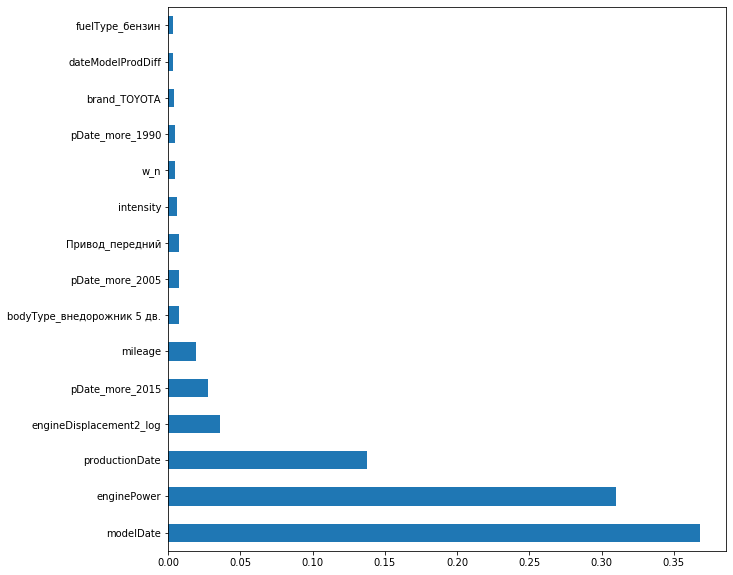

In [50]:
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X_train.columns)
feat_importances.nlargest(15).plot(kind='barh')

***Резюме*** белый шум на 11 месте из 583 переменных. Следовательно 572 (583-11) переменные можно удалить :). на самом деле попробуем поменять параметры и посмотреть как ведут себя метрики

#### 8.4.7 Тест различных моделей перед подбором оптимальных параметров (на параметрах по дефолту)

In [59]:
# попробуем Случайный лес только на БМВ
train = df_train[df_train['brand_BMW']==1].drop(['model2', 'model2_2', 'Train', 'id', 'price'], axis =1)

y_train = train.price_log.values            # наш таргет
X_train = train.drop(['price_log'], axis=1)

# проверяем
train.shape, X_train.shape, y_train.shape, val.shape, X_val.shape, y_val.shape

((3692, 585), (3692, 584), (3692,), (799, 585), (799, 584), (799,))

In [60]:
model = RandomForestRegressor(random_state = RANDOM_SEED, n_jobs = -1, verbose = 1)
model.fit(X_train, y_train)
y_pred = model.predict(X_val)
utils.test_last_pred(y_val, y_pred, y_pred) if (utils.last_pred[0].max() == 0) else 0
utils.all_metrics_MAE_MPE_MAPE_WAPE_MSE_RMSE(np.exp(y_val), np.exp(y_pred))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished


Значение  Дельта с предыдущим  \
MAE    1.615552e+05        -2.091139e+03   
MPE   -7.640000e-01         3.325000e-01   
MAPE   1.114990e+01        -8.560000e-02   
SMAPE  1.107250e+01        -3.500000e-03   
WMAPE  9.993400e+00        -1.293000e-01   
MSE    7.366488e+10        -4.381503e+08   
RMSE   2.714127e+05        -8.059693e+02   
R2     9.542020e-01         2.720000e-04   

                                                Описание  
MAE      mean absolute error (средняя абсолютная ошибка)  
MPE    (%) mean percentage error (средняя процентная ...  
MAPE   (%) mean absolute percentage error (средняя аб...  
SMAPE  (%) symmetric MAPE (симетричная средняя абсолю...  
WMAPE  (%) weighted absolute percent error (взвешенна...  
MSE       mean squared error (среднеквадратичная ошибка)  
RMSE   root mean squared error (корень из среднеквадр...  
R2     coefficient of determination (коэффициент дете...

***Резюме*** - МАРЕ снизилась но не сильно, в целом есть небольшое снижение метрик ошибки, а коэффициент детерминации немного подрос

In [63]:
# теперь Линейную регрессию на всем трейне
# Проверим LinearRegression
train = df_train.drop(['model2', 'model2_2', 'Train', 'id', 'price'], axis =1)
val = df_val.drop(['model2', 'model2_2', 'Train', 'id', 'price'], axis =1)

y_train = train.price_log.values            # наш таргет
X_train = train.drop(['price_log'], axis=1)

lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_val)
utils.test_last_pred(y_val, y_pred, y_pred) if (utils.last_pred[0].max() == 0) else 0
utils.all_metrics_MAE_MPE_MAPE_WAPE_MSE_RMSE(np.exp(y_val), np.exp(y_pred))

Значение  Дельта с предыдущим  \
MAE    2.219830e+05         6.042777e+04   
MPE   -1.835400e+00        -1.071400e+00   
MAPE   1.359710e+01         2.447200e+00   
SMAPE  1.339310e+01         2.320600e+00   
WMAPE  1.373130e+01         3.737900e+00   
MSE    1.669364e+11         9.327150e+10   
RMSE   4.085785e+05         1.371657e+05   
R2     8.962150e-01        -5.798700e-02   

                                                Описание  
MAE      mean absolute error (средняя абсолютная ошибка)  
MPE    (%) mean percentage error (средняя процентная ...  
MAPE   (%) mean absolute percentage error (средняя аб...  
SMAPE  (%) symmetric MAPE (симетричная средняя абсолю...  
WMAPE  (%) weighted absolute percent error (взвешенна...  
MSE       mean squared error (среднеквадратичная ошибка)  
RMSE   root mean squared error (корень из среднеквадр...  
R2     coefficient of determination (коэффициент дете...

***Резюме*** - МАРЕ вырос на 2.44. Почти все метрики высоли. RMSE на 137165 р. И даже коэфф детерминации упал. Пока случайный лес показывает лучший результат.

In [65]:
# попробуем ExtraTreeRegressor на всем трейне
etr = ExtraTreeRegressor(random_state = RANDOM_SEED)
etr.fit(X_train, y_train)
y_pred = etr.predict(X_val)
utils.test_last_pred(y_val, y_pred, y_pred) if (utils.last_pred[0].max() == 0) else 0
utils.all_metrics_MAE_MPE_MAPE_WAPE_MSE_RMSE(np.exp(y_val), np.exp(y_pred))

Значение  Дельта с предыдущим  \
MAE    2.395262e+05         1.754325e+04   
MPE   -2.966100e+00        -1.130700e+00   
MAPE   1.679570e+01         3.198600e+00   
SMAPE  1.588750e+01         2.494400e+00   
WMAPE  1.481640e+01         1.085100e+00   
MSE    1.526711e+11        -1.426524e+10   
RMSE   3.907315e+05        -1.784695e+04   
R2     9.050840e-01         8.869000e-03   

                                                Описание  
MAE      mean absolute error (средняя абсолютная ошибка)  
MPE    (%) mean percentage error (средняя процентная ...  
MAPE   (%) mean absolute percentage error (средняя аб...  
SMAPE  (%) symmetric MAPE (симетричная средняя абсолю...  
WMAPE  (%) weighted absolute percent error (взвешенна...  
MSE       mean squared error (среднеквадратичная ошибка)  
RMSE   root mean squared error (корень из среднеквадр...  
R2     coefficient of determination (коэффициент дете...

***Резюме*** - МАРЕ вырос еще на 3 %. Почти все метрики высоли, кроме MAE, MSE, RMSE на 137165 р. Коэфф детерминации немного поднялся. Несмотря на повышение процентных метрик, я считаю что процентные метрики нестабильны и плохо оценивают качество алгоритма. Поэтому тут ExtraTreeRegressor показал себя лучше Линейной регрессии, но пока случайный лес показывает лучший результат.

In [68]:
# проверим градиентный бустинг на всем трейне
gbr = GradientBoostingRegressor(n_estimators=250)
gbr.fit(X_train, y_train)
y_pred = gbr.predict(X_val)
utils.test_last_pred(y_val, y_pred, y_pred) if (utils.last_pred[0].max() == 0) else 0
utils.all_metrics_MAE_MPE_MAPE_WAPE_MSE_RMSE(np.exp(y_val), np.exp(y_pred))

Значение  Дельта с предыдущим  \
MAE    2.081644e+05        -3.136182e+04   
MPE   -1.386700e+00         1.579400e+00   
MAPE   1.418570e+01        -2.610000e+00   
SMAPE  1.398840e+01        -1.899100e+00   
WMAPE  1.287650e+01        -1.939900e+00   
MSE    1.084097e+11        -4.426142e+10   
RMSE   3.292563e+05        -6.147523e+04   
R2     9.326010e-01         2.751700e-02   

                                                Описание  
MAE      mean absolute error (средняя абсолютная ошибка)  
MPE    (%) mean percentage error (средняя процентная ...  
MAPE   (%) mean absolute percentage error (средняя аб...  
SMAPE  (%) symmetric MAPE (симетричная средняя абсолю...  
WMAPE  (%) weighted absolute percent error (взвешенна...  
MSE       mean squared error (среднеквадратичная ошибка)  
RMSE   root mean squared error (корень из среднеквадр...  
R2     coefficient of determination (коэффициент дете...

Резюме - МАРЕ снизился на 2.61 %. Почти все метрики снизились, кроме MPE. Коэфф детерминации немного поднялся. В целом градиентный бустинг показал себя лучше  ExtraTreeRegressor и Линейной регрессии, но пока случайный лес показывает лучший результат.

In [70]:
# проверим BaggingRegressor вместе со случайным лесом на всем трейне
bgr_rf = BaggingRegressor(model, n_estimators=3, n_jobs=-1, random_state=RANDOM_SEED)
bgr_rf.fit(X_train, y_train)
y_pred = bgr_rf.predict(X_val)
utils.test_last_pred(y_val, y_pred, y_pred) if (utils.last_pred[0].max() == 0) else 0
utils.all_metrics_MAE_MPE_MAPE_WAPE_MSE_RMSE(np.exp(y_val), np.exp(y_pred))

Значение  Дельта с предыдущим  \
MAE    1.702312e+05        -3.793325e+04   
MPE   -1.090200e+00         2.965000e-01   
MAPE   1.149910e+01        -2.686600e+00   
SMAPE  1.134160e+01        -2.646800e+00   
WMAPE  1.053000e+01        -2.346500e+00   
MSE    8.061224e+10        -2.779748e+10   
RMSE   2.839229e+05        -4.533336e+04   
R2     9.498830e-01         1.728200e-02   

                                                Описание  
MAE      mean absolute error (средняя абсолютная ошибка)  
MPE    (%) mean percentage error (средняя процентная ...  
MAPE   (%) mean absolute percentage error (средняя аб...  
SMAPE  (%) symmetric MAPE (симетричная средняя абсолю...  
WMAPE  (%) weighted absolute percent error (взвешенна...  
MSE       mean squared error (среднеквадратичная ошибка)  
RMSE   root mean squared error (корень из среднеквадр...  
R2     coefficient of determination (коэффициент дете...

***Резюме*** все метрики существенно снизились и коэффициент детерминации подрос. Запустим еще раз случайный лес, чтобы можно было сравнить прогресс

In [71]:
model = RandomForestRegressor(random_state = RANDOM_SEED, n_jobs = -1, verbose = 1)
model.fit(X_train, y_train)
y_pred = model.predict(X_val)
utils.test_last_pred(y_val, y_pred, y_pred) if (utils.last_pred[0].max() == 0) else 0
utils.all_metrics_MAE_MPE_MAPE_WAPE_MSE_RMSE(np.exp(y_val), np.exp(y_pred))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   21.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   51.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished


Значение  Дельта с предыдущим  \
MAE    1.636464e+05        -6.584799e+03   
MPE   -1.096500e+00        -6.300000e-03   
MAPE   1.123550e+01        -2.636000e-01   
SMAPE  1.107600e+01        -2.656000e-01   
WMAPE  1.012270e+01        -4.073000e-01   
MSE    7.410303e+10        -6.509211e+09   
RMSE   2.722187e+05        -1.170423e+04   
R2     9.539300e-01         4.047000e-03   

                                                Описание  
MAE      mean absolute error (средняя абсолютная ошибка)  
MPE    (%) mean percentage error (средняя процентная ...  
MAPE   (%) mean absolute percentage error (средняя аб...  
SMAPE  (%) symmetric MAPE (симетричная средняя абсолю...  
WMAPE  (%) weighted absolute percent error (взвешенна...  
MSE       mean squared error (среднеквадратичная ошибка)  
RMSE   root mean squared error (корень из среднеквадр...  
R2     coefficient of determination (коэффициент дете...

***Резюме*** - Случайный лес без Бэгинга оказался лучше чем с Бэгингом. Надо учитавыть что это без настройки параметров.

In [ ]:
d_df['y_pred'] = d_df.iloc[:,0:1].mean(axis=1)

In [104]:
# попробуем стекинг Случайного леса и беггинг, пока без мета модели, просто возьмем  среднее
models = [RandomForestRegressor(random_state = RANDOM_SEED, n_jobs = -1, verbose = 1),
         BaggingRegressor(ExtraTreeRegressor(random_state=RANDOM_SEED), random_state=RANDOM_SEED)]

def stacking_model_predict(d_models, d_X_train, d_y_train, d_X_val):
    d_df = pd.DataFrame()
    for model_ in tqdm(d_models):
        model_.fit(d_X_train, d_y_train)
        y_pred = model_.predict(d_X_val)
        d_df[str(model_)[:6]] = np.exp(y_pred)                   
    return d_df

temp_df = stacking_model_predict(models, X_train, y_train, X_val)
temp_df['y_pred']=temp_df.mean(axis=1)

0%|          | 0/2 [00:00<?, ?it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   20.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   53.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
100%|██████████| 2/2 [01:15<00:00, 37.70s/it]


In [113]:
y_pred = np.array(temp_df['y_pred'])
utils.test_last_pred(y_val, y_pred, y_pred) if (utils.last_pred[0].max() == 0) else 0
utils.all_metrics_MAE_MPE_MAPE_WAPE_MSE_RMSE(np.exp(y_val), y_pred)

Значение  Дельта с предыдущим  \
MAE    1.605877e+05                  0.0   
MPE   -1.156700e+00                  0.0   
MAPE   1.115530e+01                  0.0   
SMAPE  1.095010e+01                  0.0   
WMAPE  9.933500e+00                  0.0   
MSE    7.059491e+10                  0.0   
RMSE   2.656970e+05                  0.0   
R2     9.561110e-01                  0.0   

                                                Описание  
MAE      mean absolute error (средняя абсолютная ошибка)  
MPE    (%) mean percentage error (средняя процентная ...  
MAPE   (%) mean absolute percentage error (средняя аб...  
SMAPE  (%) symmetric MAPE (симетричная средняя абсолю...  
WMAPE  (%) weighted absolute percent error (взвешенна...  
MSE       mean squared error (среднеквадратичная ошибка)  
RMSE   root mean squared error (корень из среднеквадр...  
R2     coefficient of determination (коэффициент дете...

***Резюме*** Стеккинг показал самый лучший результат. Но мы пока не касались вопросa округления. Проверим насколько это помогает.

In [114]:
y_pred = np.round(np.array(temp_df['y_pred'])/1000,2)*1000
utils.test_last_pred(y_val, y_pred, y_pred) if (utils.last_pred[0].max() == 0) else 0
utils.all_metrics_MAE_MPE_MAPE_WAPE_MSE_RMSE(np.exp(y_val), y_pred)

Значение  Дельта с предыдущим  \
MAE    1.605877e+05             0.075786   
MPE   -1.156700e+00             0.000000   
MAPE   1.115530e+01             0.000000   
SMAPE  1.095010e+01             0.000000   
WMAPE  9.933500e+00             0.000000   
MSE    7.059492e+10         17116.901489   
RMSE   2.656971e+05             0.032211   
R2     9.561110e-01             0.000000   

                                                Описание  
MAE      mean absolute error (средняя абсолютная ошибка)  
MPE    (%) mean percentage error (средняя процентная ...  
MAPE   (%) mean absolute percentage error (средняя аб...  
SMAPE  (%) symmetric MAPE (симетричная средняя абсолю...  
WMAPE  (%) weighted absolute percent error (взвешенна...  
MSE       mean squared error (среднеквадратичная ошибка)  
RMSE   root mean squared error (корень из среднеквадр...  
R2     coefficient of determination (коэффициент дете...

In [115]:
y_pred = np.round(np.array(temp_df['y_pred'])/100,2)*100
utils.test_last_pred(y_val, y_pred, y_pred) if (utils.last_pred[0].max() == 0) else 0
utils.all_metrics_MAE_MPE_MAPE_WAPE_MSE_RMSE(np.exp(y_val), y_pred)

Значение  Дельта с предыдущим  \
MAE    1.605877e+05            -0.075094   
MPE   -1.156700e+00             0.000000   
MAPE   1.115530e+01             0.000000   
SMAPE  1.095010e+01             0.000000   
WMAPE  9.933500e+00             0.000000   
MSE    7.059490e+10        -19008.222763   
RMSE   2.656970e+05            -0.035771   
R2     9.561110e-01             0.000000   

                                                Описание  
MAE      mean absolute error (средняя абсолютная ошибка)  
MPE    (%) mean percentage error (средняя процентная ...  
MAPE   (%) mean absolute percentage error (средняя аб...  
SMAPE  (%) symmetric MAPE (симетричная средняя абсолю...  
WMAPE  (%) weighted absolute percent error (взвешенна...  
MSE       mean squared error (среднеквадратичная ошибка)  
RMSE   root mean squared error (корень из среднеквадр...  
R2     coefficient of determination (коэффициент дете...

In [116]:
y_pred = np.round(np.array(temp_df['y_pred'])/10000,2)*10000
utils.test_last_pred(y_val, y_pred, y_pred) if (utils.last_pred[0].max() == 0) else 0
utils.all_metrics_MAE_MPE_MAPE_WAPE_MSE_RMSE(np.exp(y_val), y_pred)

Значение  Дельта с предыдущим  \
MAE    1.605886e+05             0.951189   
MPE   -1.156500e+00             0.000200   
MAPE   1.115530e+01             0.000000   
SMAPE  1.095010e+01             0.000000   
WMAPE  9.933600e+00             0.000100   
MSE    7.059495e+10         44888.047546   
RMSE   2.656971e+05             0.084473   
R2     9.561110e-01             0.000000   

                                                Описание  
MAE      mean absolute error (средняя абсолютная ошибка)  
MPE    (%) mean percentage error (средняя процентная ...  
MAPE   (%) mean absolute percentage error (средняя аб...  
SMAPE  (%) symmetric MAPE (симетричная средняя абсолю...  
WMAPE  (%) weighted absolute percent error (взвешенна...  
MSE       mean squared error (среднеквадратичная ошибка)  
RMSE   root mean squared error (корень из среднеквадр...  
R2     coefficient of determination (коэффициент дете...

#### 8.4.8 Проверим где мы больше всего ошибаемся на MAPE

In [134]:
y_pred = np.round(np.array(temp_df['y_pred'])/1000,2)*1000
df_val['MAPE'] = np.abs((np.exp(y_val) - y_pred)/np.exp(y_val))*100
df_val['y_pred'] = y_pred

In [135]:
df_val['MAPE'].describe()

count    799.000000
mean      11.155317
std       13.228600
min        0.012022
25%        3.898579
50%        7.937804
75%       14.722205
max      241.660000
Name: MAPE, dtype: float64

In [143]:
df_val[df_val['MAPE']>35][['price', 'y_pred', 'MAPE', 'model2', 'modelDate','productionDate', 'enginePower', 'intensity', 'rarity', 'mileage', 'fuelType_бензин']]

price     y_pred        MAPE model2  modelDate  productionDate  \
4529  3200000.0  1694250.0   47.054687   640d       2011            2013   
6248  1499000.0  2032220.0   35.571714   M50d       2012            2013   
3594   850000.0  1230200.0   44.729412   528i       2009            2012   
3054  1710000.0  2831190.0   65.566667   330i       2015            2018   
2282   820000.0   496510.0   39.450000   116i       2007            2010   
4907   835000.0  1190970.0   42.631138    25i       2009            2011   
4680   780000.0  1130730.0   44.965385   750i       2008            2011   
5260   420000.0   635580.0   51.328571    30i       2003            2006   
5199   900000.0   484830.0   46.130000    25i       2003            2004   
2673   800000.0  1325630.0   65.703750   335i       2005            2007   
3070   290000.0   415420.0   43.248276   325i       2001            2004   
4702   500000.0   322920.0   35.416000   728i       1998            2001   
4231   700000.0   398030.0   43.138571   525i       2000            2002   
2663   800000.0   308910.0   61.386250   318i       1998            2001   
2750   690000.0   330550.0   52.094203   323i       1998            1999   
3107   200000.0   279790.0   39.895000   318i       1998            1999   
3067   160000.0   260980.0   63.112500   316i       1998            1999   
3373   120000.0   250120.0  108.433333   535i       1987            1989   
4624   300000.0  1024980.0  241.660000  750Li       1986            1989   
3678   100000.0   173500.0   73.500000   525i       1981            1984   

      enginePower     intensity  rarity  mileage  fuelType_бензин  
4529          313  14428.571429   False   101000                0  
6248          381  20600.714286   False   144205                0  
3594          258  28750.000000   False   230000                1  
3054          249  22500.000000   False    45000                1  
2282          115   7900.000000   False    79000                1  
4907          218  13111.111111   False   118000                1  
4680          407  21111.111111   False   190000                1  
5260          231  15000.000000   False   210000                1  
5199          192  12187.500000   False   195000                1  
2673          306   8513.384615   False   110674                1  
3070          192  16687.500000   False   267000                1  
4702          193  15526.315789   False   295000                1  
4231          192  14197.500000   False   255555                1  
2663          118   7631.578947   False   145000                1  
2750          170  14285.714286   False   300000                1  
3107          118  11440.333333   False   240247                1  
3067          105   5714.285714   False   120000                1  
3373          211   9677.419355   False   300000                1  
4624          300   9677.419355   False   300000                1  
3678          150   5119.444444   False   184300                1

In [145]:
df_val[df_val['MAPE']>35][['price', 'y_pred', 'MAPE', 'model2', 'modelDate','productionDate', 'enginePower', 'intensity', 'rarity', 'mileage', 'fuelType_бензин']].describe()

price        y_pred        MAPE    modelDate  productionDate  \
count  2.000000e+01  2.000000e+01   20.000000    20.000000       20.000000   
mean   7.837000e+05  8.408655e+05   62.250773  2001.350000     2003.600000   
std    7.098744e+05  7.129531e+05   45.510739     8.940005        8.923063   
min    1.000000e+05  1.735000e+05   35.416000  1981.000000     1984.000000   
25%    2.975000e+05  3.194175e+05   43.011713  1998.000000     1999.000000   
50%    7.400000e+05  4.906700e+05   46.592344  2002.000000     2004.000000   
75%    8.387500e+05  1.200778e+06   63.726042  2008.250000     2011.000000   
max    3.200000e+06  2.831190e+06  241.660000  2015.000000     2018.000000   

       enginePower     intensity        mileage  fuelType_бензин  
count    20.000000     20.000000      20.000000        20.000000  
mean    220.950000  13702.995189  191499.050000         0.900000  
std      86.251453   6054.254028   80738.226229         0.307794  
min     105.000000   5119.444444   45000.000000         0.000000  
25%     165.000000   9386.410670  119500.000000         1.000000  
50%     202.000000  13654.305556  192500.000000         1.000000  
75%     268.500000  15816.611842  258416.250000         1.000000  
max     407.000000  28750.000000  300000.000000         1.000000

***Резюме*** Мы ошибаемся более 35% MAPE на авто в среднем 2001 года, с мощностью бензинового двигателя 220 л.с. средней стоиомстью 783700 р.  

#### 8.4.9 Подбор параметров модели для Случайного леса

In [ ]:
# позволяет закрепить random_state во всей ячейке исполнения
np.random.seed(42)

n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1500, num = 50)]
max_features = ['auto', 'sqrt', 'log2']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rf = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator = rf, 
                               param_distributions = random_grid, 
                               n_iter = 100, 
                               cv = 3, 
                               verbose=2, 
                               random_state=RANDOM_SEED, 
                               n_jobs = -1)
rf_random.fit(X_train, y_train)

### 10. Построение итоговой модели 
---
### Разбиваем датасет на тренировочный и тестовый

In [ ]:
train = df3.query('Train==1').drop(['Train','id'], axis = 1)
test = df3.query('Train==0').drop(['Train', 'price_log','id'], axis = 1)

In [ ]:
X = train.drop(['price_log'], axis=1).reset_index(drop=True)
y = train['price_log'].values

In [ ]:
models = [RandomForestRegressor(random_state = RANDOM_SEED, n_jobs = -1, verbose = 1),
         BaggingRegressor(ExtraTreeRegressor(random_state=RANDOM_SEED), random_state=RANDOM_SEED)]

def stacking_model_predict(d_models, d_X, d_y, d_test, d_df_submit):
    for model_ in tqdm(d_models):
        model_.fit(d_X, d_y)
        pred_subm = model_.predict(d_test)
        d_df_submit[str(model_)[:6]] = pred_subm
        d_df_submit[str(model_)[:6]] = d_df_submit[str(model_)[:6]].apply(lambda x: np.exp(x) )
        d_df_submit[str(model_)[:6]] = d_df_submit[str(model_)[:6]].apply(lambda x: round(x/1000)*1000)
    d_df_submit['price'] = d_df_submit.iloc[:,2:].mean(axis=1)
    d_df_submit[['id', 'price']].to_csv(f'submission_25.csv', index=False)
    d_df_submit.head(10)
    return 

stacking_model_predict(models, X, y, test, df_submit)

In [ ]:
df_submit